In [1]:
#tflearn
import tflearn
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.estimator import regression
from tflearn.data_preprocessing import ImagePreprocessing
from tflearn.data_augmentation import ImageAugmentation

#numpy, plt
import numpy as np
import matplotlib.pyplot as plt
import matplotlib
import os
import cv2
from numpy import *

# SKLEARN
from sklearn.utils import shuffle
from sklearn.cross_validation import train_test_split

C:\Users\User\Anaconda3\lib\site-packages\h5py\__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


curses is not supported on this machine (please install/reinstall curses for an optimal experience)


C:\Users\User\Anaconda3\lib\site-packages\sklearn\cross_validation.py:44: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
#  data
train = r'dataset\data\traindata'    #path of folder of images 
train_names = os.listdir(train)
test = r'dataset\data\testdata'  #path of folder to save images   
test_names = os.listdir(test)

In [3]:
img_size = 200
lr = 1e-3
MODEL_NAME = 'huangshan-{}-{}.model'.format(lr,'5con-basic')

In [4]:
def imlist(path):
    """
    The function imlist returns all the names of the files in 
    the directory path supplied as argument to the function.
    """
    return [os.path.join(path, f) for f in os.listdir(path)]

In [5]:
def label_img(class_id):
    label = [0]*8
    label[class_id] = 1.0
    return label

In [6]:
def create_train_data():
    class_id = 0
    training_data = []
    for train_name in train_names:
        dir = os.path.join(train, train_name)
        class_path = imlist(dir)
        for path in class_path:
            img = cv2.resize(cv2.imread(path,cv2.IMREAD_GRAYSCALE), (img_size, img_size))
            img = img / 255.0
            training_data.append([np.array(img).astype('float32'), np.array(label_img(class_id))])
        class_id+=1
    training_data = shuffle(training_data)
    np.save('train_data.npy', training_data)
    return training_data

In [7]:
def create_test_data():
    class_id = 0
    testing_data = []
    for test_name in test_names:
        dir = os.path.join(test, test_name)
        class_path = imlist(dir)
        for path in class_path:
            img = cv2.resize(cv2.imread(path,cv2.IMREAD_GRAYSCALE), (img_size, img_size))
            img = img/255.0
            testing_data.append([np.array(img).astype('float32'), np.array(label_img(class_id))])
        class_id+=1
    testing_data = shuffle(testing_data)
    np.save('test_data.npy', testing_data)
    return testing_data

In [8]:
train_data = create_train_data()

In [9]:
test_data = create_test_data()

In [10]:
#load train_data, test_data
train_data = np.load('train_data.npy')
test_data = np.load('test_data.npy')

In [11]:
test_data[0][0].shape

(200, 200)

In [12]:
#all_data = np.concatenate((train_data, test_data), axis=0)

In [13]:
# Real-time data preprocessing
img_prep = ImagePreprocessing()
img_prep.add_featurewise_zero_center()
img_prep.add_featurewise_stdnorm()

# Real-time data augmentation
img_aug = ImageAugmentation()
img_aug.add_random_flip_leftright()
img_aug.add_random_rotation(max_angle=25.)

# Building convolutional convnet
convnet = input_data(shape=[None, img_size, img_size, 1], data_preprocessing=img_prep,
                     data_augmentation=img_aug, name='input')

convnet = conv_2d(convnet, 32, 3, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 3, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 32, 3, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = conv_2d(convnet, 64, 3, activation='relu')
convnet = max_pool_2d(convnet, 2)

convnet = fully_connected(convnet, 1024, activation='relu')
convnet = dropout(convnet, 0.8)

convnet = fully_connected(convnet, 8, activation='softmax')
convnet = regression(convnet, optimizer='adam', learning_rate=lr, loss='categorical_crossentropy', name='targets')

model = tflearn.DNN(convnet, tensorboard_dir='log')

Instructions for updating:
Use tf.initializers.variance_scaling instead with distribution=uniform to get equivalent behavior.
Instructions for updating:
keep_dims is deprecated, use keepdims instead


In [14]:
if os.path.exists('{}.meta'.format(MODEL_NAME)):
    model.load(MODEL_NAME)
    print('Model loaded!')

In [15]:
X = np.array([i[0] for i in train_data]).reshape(-1, img_size, img_size, 1)
Y = np.array([i[1] for i in train_data])

test_x = np.array([i[0] for i in test_data]).reshape(-1, img_size, img_size, 1)
test_y = np.array([i[1] for i in test_data])

In [16]:
model.fit({'input': X}, {'targets': Y}, n_epoch=1000, validation_set=({'input': test_x}, {'targets': test_y}), 
    snapshot_step=500, show_metric=True, run_id=MODEL_NAME)

Training Step: 12999  | total loss: 0.27828 | time: 23.451s
| Adam | epoch: 1000 | loss: 0.27828 - acc: 0.9635 -- iter: 768/800
Training Step: 13000  | total loss: 0.25435 | time: 30.320s
| Adam | epoch: 1000 | loss: 0.25435 - acc: 0.9672 | val_loss: 1.02947 - val_acc: 0.6625 -- iter: 800/800
--


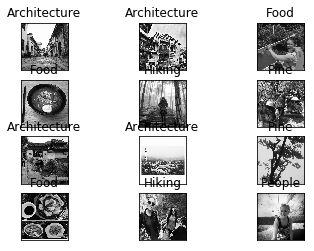

In [21]:
test_data = np.load('test_data.npy')

fig=plt.figure()
for num,data in enumerate(test_data[:12]):

    img_num = data[1]
    img_data = data[0]
    
    y = fig.add_subplot(3,4,num+1)
    orig = img_data
    data = img_data.reshape(img_size,img_size,1)
    #model_out = model.predict([data])[0]
    model_out = model.predict([data])
    
    if np.argmax(model_out[0]) == 0: str_label='Architecture'
    elif np.argmax(model_out[0]) == 1: str_label='Cloud'
    elif np.argmax(model_out[0]) == 2 : str_label = 'Food'
    elif np.argmax(model_out[0]) == 3 : str_label = 'Hiking'
    elif np.argmax(model_out[0]) == 4 : str_label = 'Mountain'    
    elif np.argmax(model_out[0]) == 5 : str_label = 'Other'
    elif np.argmax(model_out[0]) == 6 : str_label = 'People'    
    else: str_label = 'Pine'    
        
    y.imshow(orig,cmap='gray')
    plt.title(str_label)
    y.axes.get_xaxis().set_visible(False)
    y.axes.get_yaxis().set_visible(False)
plt.show()

In [18]:
 model_out = model.predict([test_data[0][0].reshape(img_size,img_size,1)])

In [19]:
model_out[0]

array([6.2975824e-01, 1.2361951e-04, 1.2035134e-05, 1.3829453e-05,
       3.6956307e-01, 4.0858623e-04, 1.1876563e-04, 1.8982946e-06],
      dtype=float32)

In [20]:
test_data[0]

array([array([[ 1.235394 ,  1.235394 ,  1.5027614, ..., -6.4736977, -6.56282  ,
        -6.6073813],
       [ 1.2799553,  1.3245165,  1.4582001, ..., -5.8944016, -6.4736977,
        -6.4736977],
       [ 1.3245165,  1.3245165,  1.5027614, ..., -5.3151054, -5.760718 ,
        -6.6965036],
       ...,
       [-3.8445852, -3.8445852, -3.7109017, ..., -3.0424833, -2.19582  ,
        -2.6414323],
       [-4.0673914, -3.4880955, -3.9337077, ..., -2.6859934, -2.8642385,
        -2.7305546],
       [-3.3544116, -3.2207282, -3.0870445, ..., -2.5523098, -2.4186263,
        -2.5523098]], dtype=float32),
       array([1., 0., 0., 0., 0., 0., 0., 0.])], dtype=object)

# Predict the whole data 

In [25]:
#save model 
model.save("cnnmodel.tfl")

INFO:tensorflow:C:\Users\User\Desktop\Instagram\cnnmodel.tfl is not in all_model_checkpoint_paths. Manually adding it.


In [24]:
# Load a model
#model.load("model.tfl")

In [38]:
all_path = r'data'
# load all unlabelled data
def predict_data(paths):
    predictions = []
    all_data = []
    for file in os.listdir(paths):
        if file[-3:] == 'jpg':
            path = os.path.join(all_path, file)
            img = cv2.resize(cv2.imread(path,cv2.IMREAD_GRAYSCALE), (img_size, img_size))
            img = img/255.0
            img = np.array(img).astype('float32')
            all_data.append(img)
            img = img.reshape(img_size,img_size,1)
            result = model.predict([img])
            print(file, argmax(result[0]))
            predictions.append(argmax(result[0]))
    return predictions

In [39]:
predictions  = predict_data(all_path)

10004118_682286928498293_891737426_n.jpg 2
10004124_444880689005140_920780912_n.jpg 4
10004129_700120676718038_1758719498_n.jpg 7
10004152_605230082892987_584072422_n.jpg 1
10004153_591150430981548_944833506_n.jpg 4
10004190_682780338446435_1435309841_n.jpg 6
10004235_264878183687079_686637174_n.jpg 1
10004235_741744029267020_395363348_n.jpg 4
10004257_909879692437286_744300993_n.jpg 6
10004282_331311647055664_753380968_n.jpg 3
10004289_674426929282504_365470944_n.jpg 1
10004292_1411909822405440_1984834542_n.jpg 6
10004296_717562384931540_847460110_n.jpg 4
10004342_1536878676538493_1637838799_n.jpg 1
10004354_1421956151388560_1077423984_n.jpg 1
10004355_666898993407779_1572503611_n.jpg 7
10004364_638427249544230_637756802_n.jpg 1
10005140_274770026033664_747511409_n.jpg 3
10005164_1466179503611032_166448314_n.jpg 1
10005174_1421597224756554_742843364_n.jpg 6
10005221_1531667163726752_560247160_n.jpg 1
10005225_479053818890458_2103960303_n.jpg 5
10005226_1402516556685927_1066844937_n.jp

10246064_309405745877371_2080780458_n.jpg 3
10246065_687513187962328_1029807997_n.jpg 2
10246071_394597314013655_1484919306_n.jpg 1
10246074_285495548286638_2062547027_n.jpg 5
10246074_682939708433565_835855635_n.jpg 6
10246080_930072317005888_2143420119_n.jpg 1
10246092_560171470769065_703868896_n.jpg 4
10246093_1410824729191410_1493075378_n.jpg 1
10246093_239433882919271_758878973_n.jpg 7
10246101_901344046546342_417554684_n.jpg 0
10246107_1500693696819964_283525222_n.jpg 6
10246130_530755863699412_1725489087_n.jpg 2
10246133_687883607936722_2000661361_n.jpg 2
10246138_1427314530857094_1067518468_n.jpg 6
10246140_228087450719560_1089019823_n.jpg 1
10246140_564284980357786_537300295_n.jpg 5
10246144_252681064916581_1645179757_n.jpg 3
10246152_469589216507945_991940124_n.jpg 4
10246156_620164638068505_1058453993_n.jpg 1
10246160_605312372884094_1142900983_n.jpg 7
10246164_537094003066451_622603140_n.jpg 7
10246173_1471692489728185_2140945623_n.jpg 7
10246173_258672110970322_729885924_n

10261207_491062400993797_633877854_n.jpg 3
10261212_478250865610502_1290539525_n.jpg 4
10261219_675306755876304_337965620_n.jpg 1
10261220_637315609639024_1788763485_n.jpg 1
10261220_645669475504644_1610323039_n.jpg 7
10261221_300304973460641_1015462841_n.jpg 3
10261245_298077553688021_123411554_n.jpg 2
10261265_489895024445072_2116870908_n.jpg 6
10261265_778451122167520_1211992827_n.jpg 6
10261272_231513970381093_145291862_n.jpg 4
10261272_256668304516950_1871381219_n.jpg 3
10261286_705523606137187_1368905706_n.jpg 2
10261306_302263703262039_911738276_n.jpg 0
10261308_532969590200206_1947386384_n.jpg 3
10261312_284348691731782_270132248_n.jpg 1
10261313_383700151768520_475939966_n.jpg 4
10261320_442879235856385_2025488726_n.jpg 1
10261321_788004437884014_240612048_n.jpg 7
10268731_557260124440313_74008871_n.jpg 4
10268759_237117363162045_84240699_n.jpg 3
10268771_1495913717287404_1237635192_n.jpg 1
10268771_1497270540492965_1848428446_n.jpg 1
10268772_1449101718669247_1950474583_n.jpg

10311294_664744290228560_1045565980_n.jpg 1
10311298_491314721048132_1544826332_n.jpg 1
10311302_1506485402902851_21765151_n.jpg 1
10311310_844047548956697_337517768_n.jpg 2
10311322_717160745011272_47069297_n.jpg 6
10311332_448529691950054_5623970_n.jpg 7
10326361_524249134347281_188284100_n.jpg 7
10326369_291404094361657_1470204529_n.jpg 1
10326379_299715646862552_618365058_n.jpg 1
10326404_671358836263562_2195762_n.jpg 7
10326418_561245460658160_493257087_n.jpg 1
10326446_1479656258931702_1518242906_n.jpg 4
10326474_741781445872137_922999154_n.jpg 4
10326476_632078060210977_1538681152_n.jpg 7
10326483_669633479789198_743358369_n.jpg 1
10326499_468339239979355_1948864338_n.jpg 6
10326520_241050419424026_897407525_n.jpg 4
10326520_661320297273948_672025371_n.jpg 4
10326525_277379725769244_328035433_n.jpg 4
10326537_749964165048174_2112871908_n.jpg 4
10326542_242460145946310_173193714_n.jpg 7
10326551_239046202954756_1684296223_n.jpg 6
10326557_1401579196792270_1123695492_n.jpg 5
10326

10362318_792566837422568_570955232_n.jpg 2
10362323_721736061206612_856132647_n.jpg 4
10362331_1440952586158903_440222907_n.jpg 4
10362331_643686555705923_1181172633_n.jpg 3
10362342_442390862565190_618236938_n.jpg 5
10369281_1668444523427673_425154627_n.jpg 6
10369285_913721648658920_1209387858_n.jpg 5
10369289_1424609034474941_1531537032_n.jpg 3
10369292_1620809964841488_1295241419_n.jpg 0
10369298_1487865458109920_1189343376_n.jpg 1
10369305_1483452501883815_1050576348_n.jpg 1
10369313_1720263058231712_532794819_n.jpg 1
10369319_687267261309900_432097856_n.jpg 6
10369344_1441839616097078_412593466_n.jpg 5
10369346_810090552360128_1624411360_n.jpg 0
10369346_906241182729536_997537279_n.jpg 1
10369350_390014184507842_733208217_n.jpg 0
10369352_455547311279005_1313994063_n.jpg 7
10369357_1584406275156449_792064291_n.jpg 4
10369363_1491335727745020_1168519496_n.jpg 4
10369371_1453585114881756_1242836848_n.jpg 6
10369373_341951922672638_1560738092_n.jpg 7
10369374_252671968259135_1483340

10412964_1119974831366943_929308908_n.jpg 5
10412972_859466767416000_627895005_n.jpg 7
10413010_735655956496779_1274592325_n.jpg 3
10413023_326253610857927_1943414825_n.jpg 1
10413024_517844818317577_992174017_n.jpg 1
10413032_1092916850727523_732155787_n.jpg 3
10413045_258224847713210_941754791_n.jpg 6
10413061_501419796719328_2087573133_n.jpg 1
10413123_281896405318584_1094909027_n.jpg 4
10413129_1414813252137110_709590449_n.jpg 5
10413132_267630040086931_1849582091_n.jpg 1
10413146_255415101329588_48921514_n.jpg 5
10413148_416705065138712_1826949357_n.jpg 6
10413160_1448430268739310_9730189_n.jpg 4
10413178_631685733594826_1491026888_n.jpg 1
10413189_643136305774444_477931249_n.jpg 2
10413207_1488638421369499_418034923_n.jpg 0
10413227_561595610625430_2008302394_n.jpg 1
10413236_589184077863428_226270284_n.jpg 1
10413236_607514222678793_686775449_n.jpg 1
10413247_316044248547034_1437781322_n.jpg 5
10413252_575626672556471_326453891_n.jpg 1
10413254_692727850762880_856752599_n.jpg 2


10453880_1567027333613597_1282678640_n.jpg 4
10453899_1510841595796158_2098955758_n.jpg 6
10453909_1453436134930922_1318625828_n.jpg 3
10453912_808225785856184_1696680142_n.jpg 5
10453923_1517311035148188_517028212_n.jpg 1
10453929_590603721055049_1974080483_n.jpg 1
10453929_780777501972698_266799406_n.jpg 1
10453932_334695050012692_119946924_n.jpg 0
10453949_722878551105237_1674225908_n.jpg 1
10453950_745410312176531_1187956417_n.jpg 7
10453966_1436421429961203_1426397406_n.jpg 2
10453966_308879142623025_1358295346_n.jpg 6
10453969_1434643750142824_1510801867_n.jpg 3
10453975_733848266672078_1718214431_n.jpg 4
10454003_303334389831648_1606712191_n.jpg 4
10454020_418007865004039_480529588_n.jpg 4
10454029_675201712553072_1877161406_n.jpg 2
10454043_511181552344244_315285495_n.jpg 6
10454049_331279110357299_369331691_n.jpg 1
10454058_614416855322988_2132138228_n.jpg 3
10454076_1436566596603162_1710139327_n.jpg 4
10454078_1509467105931324_1864251515_n.jpg 7
10454082_650519868362864_11520

10507814_1445869652333151_200761254_n.jpg 1
10507829_705025429534486_388910116_n.jpg 4
10507834_796454870394233_355665528_n.jpg 1
10507837_1450124255242638_739587204_n.jpg 0
10507857_695623473861732_501222763_n.jpg 2
10507867_819250631463443_838627164_n.jpg 1
10507871_1645189022372224_1214709417_n.jpg 6
10507882_664966526917297_295504461_n.jpg 6
10507903_819192644771710_1789828378_n.jpg 1
10507909_1437555193185308_708458274_n.jpg 2
10507914_314909785343511_849917357_n.jpg 0
10507936_495651243899430_1658364649_n.jpg 4
10507940_770209566376191_1866714849_n.jpg 4
10507952_604277019687131_1013391849_n.jpg 3
10507980_1449491728634978_1028380394_n.jpg 2
10507981_304339696414278_679673178_n.jpg 1
10508003_1507777392768526_288879800_n.jpg 4
10508011_338877372945993_1956998885_n.jpg 1
10508021_788059147913357_1737315595_n.jpg 1
10508039_640772509324893_421384444_n.jpg 2
10508065_1509989499214943_413482727_n.jpg 5
10508078_1448466542074531_1670453301_n.jpg 4
10508081_618522588259788_379082847_n.

10525509_992717380753660_822701265_n.jpg 4
10525523_478122965657811_1019373227_n.jpg 7
10525543_547086628726189_943337234_n.jpg 6
10525544_805458562837358_1898520127_n.jpg 1
10525547_251165381759674_773214518_n.jpg 6
10525551_285397155000701_1367287455_n.jpg 1
10525553_101592640191106_2074941312_n.jpg 0
10533025_1463011553956336_2031853657_n.jpg 7
10533042_812327878865454_110274678_n.jpg 4
10533269_316977011799733_1872980825_n.jpg 2
10533295_683502375036395_951998810_n.jpg 1
10533418_359324887568137_1821125556_n.jpg 4
10533580_927385830624412_1137780487_n.jpg 4
10533582_1529864000568122_1418579999_n.jpg 2
10533938_608803062550229_1152904977_n.jpg 3
10533945_576465449141541_1065082000_n.jpg 1
10533952_813657832031060_50700722_n.jpg 2
10533954_292168444288999_1357050964_n.jpg 6
10534350_588187581301493_1863296712_n.jpg 5
10534816_324846767680684_188018026_n.jpg 0
10534823_1452479708339972_1663577899_n.jpg 6
10534836_1417967365115645_861318209_n.jpg 1
10534836_478791525625594_1368234935_n

10549800_1438142409783086_365483877_n.jpg 2
10549806_718304754883690_1680535096_n.jpg 4
10549822_963913710313696_1799531053_n.jpg 5
10549826_1435170226763327_1233394181_n.jpg 6
10549830_323366477825805_1890635560_n.jpg 6
10549857_1441279656148519_146498629_n.jpg 2
10549866_667800166633872_53101267_n.jpg 7
10549879_986483684709905_1212734868_n.jpg 4
10549882_1449958861930194_1341756498_n.jpg 0
10549894_469066249863407_1833728931_n.jpg 1
10549911_838754419476184_1226318451_n.jpg 4
10549918_1482484021997885_893392823_n.jpg 1
10553973_684067375007162_1653022516_n.jpg 1
10553977_1448561745430851_1625659396_n.jpg 4
10553986_1480251642219168_442623155_n.jpg 2
10553994_1528778267343019_120550414_n.jpg 4
10553995_709964669059468_663473013_n.jpg 2
10553996_766067403416597_2012854574_n.jpg 0
10553998_1518920608326087_702560437_n.jpg 7
10553999_916704978346341_805417159_n.jpg 3
10554008_259555837577865_952044276_n.jpg 3
10554009_1455936087991899_316990847_n.jpg 6
10554018_895296113832579_348582535

10584682_1462813260652068_1196785230_n.jpg 4
10584702_1524034211145037_682569788_n.jpg 1
10584704_706354686104140_1214156078_n.jpg 5
10584706_880639828615907_1937164673_n.jpg 7
10584711_340464486110845_523659279_n.jpg 1
10584715_808564449188620_1186380185_n.jpg 7
10584722_1720176374897483_608557097_n.jpg 4
10584723_425263480989459_1855691945_n.jpg 4
10584729_1541160092774441_586636411_n.jpg 1
10584733_1086383814746868_518586544_n.jpg 5
10584744_676376865788607_273518369_n.jpg 6
10584763_713712788694081_583351447_n.jpg 3
10584768_1692612857685224_1732307720_n.jpg 4
10584769_260238520853949_2087911676_n.jpg 1
10584797_925549324128864_1093964359_n.jpg 1
10584804_554552178003972_1949227369_n.jpg 6
10584821_508673325933057_637061075_n.jpg 1
10584823_328286197336001_132543071_n.jpg 3
10593245_978103252276458_430675105_n.jpg 2
10593246_551027855003593_1585821491_n.jpg 2
10593248_781924238549350_673096370_n.jpg 0
10593259_835651596458822_1450603937_n.jpg 3
10593269_263001077157079_19172321_n.j

10601966_1471846436397021_546901822_n.jpg 1
10601972_1483465308569057_826456742_n.jpg 1
10607886_574918115963581_1121473808_n.jpg 6
10607892_1450219811912278_244068862_n.jpg 6
10607895_689670904460026_1102039180_n.jpg 1
10607898_698918000200518_786868829_n.jpg 4
10607904_1667881633436258_877920732_n.jpg 6
10607925_1562410327359104_34002977_n.jpg 4
10607935_893522090675271_924789185_n.jpg 7
10607982_283179068540543_13673245_n.jpg 2
10608027_1463507030571081_798459300_n.jpg 3
10608027_697208716999721_1112684053_n.jpg 2
10608038_443143009207369_1576186857_n.jpg 1
10608058_1456546507950484_1323165475_n.jpg 6
10608070_518835434918791_1386433917_n.jpg 6
10608075_888083751280454_339417619_n.jpg 1
10608087_1432400683718436_200896484_n.jpg 1
10608101_819215868123118_1675884280_n.jpg 4
10608106_242860229391252_424016620_n.jpg 1
10608116_710180939019026_1148297898_n.jpg 1
10608127_261881540676509_1711295585_n.jpg 5
10608132_750733108343088_1814752726_n.jpg 6
10608135_334550743380039_1692156650_n.

10632358_880271048762777_1637455210_n.jpg 1
10632366_1687413408204811_639028332_n.jpg 7
10632385_792374877479756_83797775_n.jpg 6
10632395_1641936292702607_1761178385_n.jpg 1
10632397_350281471795680_1842048534_n.jpg 4
10632433_1540050086210831_158094472_n.jpg 7
10632435_828752453835818_632770730_n.jpg 3
10632450_212840199055065_1765191395_n.jpg 4
10632467_1469099353339282_1514347477_n.jpg 1
10632469_327268707441938_1745714145_n.jpg 2
10632470_858985980786125_1103020902_n.jpg 7
10632489_296342157239002_1028027710_n.jpg 0
10632502_1530643987170896_1195982512_n.jpg 1
10632511_365593086952251_509536678_n.jpg 3
10632521_717715688263452_667256226_n.jpg 2
10632522_721664087883402_1994908427_n.jpg 3
10632523_468621480000404_1787085863_n.jpg 7
10632524_760696943975947_1180961818_n.jpg 4
10632528_294625050710276_1238526150_n.jpg 1
10632538_342674065892365_1578377710_n.jpg 1
10632547_642626389178894_525463528_n.jpg 6
10632554_682882745120748_747624112_n.jpg 6
10643784_602069556568498_1123838434_

10666178_552306484901854_2010012994_n.jpg 1
10666180_358818424270551_1958324474_n.jpg 4
10666215_330819573763286_1401795706_n.jpg 6
10666244_578279282276920_1102587464_n.jpg 6
10666249_1479044429037190_111324033_n.jpg 1
10666255_896585230370812_395212652_n.jpg 2
10666256_393190394175817_1071058864_n.jpg 1
10666259_1462118327395420_1104750976_n.jpg 6
10666260_834935389884830_2015383285_n.jpg 3
10666263_990188321006703_1840258090_n.jpg 2
10666268_1533832923497250_1108639497_n.jpg 2
10666268_283566811832523_838620579_n.jpg 3
10666284_569756509797664_159800666_n.jpg 5
10683749_567370563389478_947066822_n.jpg 1
10683752_863537843705342_1371289502_n.jpg 1
10683757_316444595183648_341443415_n.jpg 6
10683760_365785070245464_574173312_n.jpg 6
10683760_687865921303404_1633782336_n.jpg 4
10683768_163834933802797_64956115_n.jpg 4
10683771_690593481027676_1665331718_n.jpg 1
10683802_870059749672244_213089867_n.jpg 3
10683820_1508716912699692_1443550267_n.jpg 4
10683849_1229778803786908_279103361912

10706692_866483000042112_804745177_n.jpg 1
10706694_1476730955934868_1893343161_n.jpg 1
10706713_345765028932030_6382334_n.jpg 1
10706716_1472204056379718_1938979260_n.jpg 5
10706728_1560874644147040_233755639_n.jpg 4
10706746_717032028365815_1157228412_n.jpg 1
10706754_262902360585573_964531214_n.jpg 1
10706764_569144966520505_2109858035_n.jpg 4
10706786_259653404244582_77238503_n.jpg 1
10706794_988723941153951_358993301_n.jpg 3
10706799_383543825147940_1253408658_n.jpg 2
10706825_1482659225338296_1515299069_n.jpg 1
10706830_655132361270517_765507585_n.jpg 6
10706831_516686651799735_121201680_n.jpg 1
10706866_531286887015109_1634235761_n.jpg 1
10706875_377206295768577_1579361356_n.jpg 1
10706883_344322059061287_932785264_n.jpg 1
10706889_1615166038710369_1875763471_n.jpg 2
10706891_789195187806681_1951904422_n.jpg 1
10706892_941755389170062_2076200090_n.jpg 1
10706895_731228206968220_214129405_n.jpg 6
10706930_1563591753858816_1536188669_n.jpg 7
10706934_773423056034280_511645955_n.jp

10727500_546372338830981_164920047_n.jpg 3
10727511_303184733222669_787925058_n.jpg 1
10727514_593363177435925_823800664_n.jpg 6
10727519_702238476575547_1212739406_n.jpg 4
10727545_806187139403809_822894782_n.jpg 7
10727547_607628772693081_1581459863_n.jpg 1
10727549_292019974328873_256518408_n.jpg 6
10727562_1489522257993981_1890950145_n.jpg 1
10727598_305735819617511_575981641_n.jpg 7
10727610_583629428403978_709129647_n.jpg 2
10727612_1538163753087807_301733684_n.jpg 1
10727656_1048085545218527_884187902_n.jpg 7
10727657_290749021121632_1834754686_n.jpg 1
10727665_786866538023285_1949355718_n.jpg 6
10727670_364577590375981_677105205_n.jpg 6
10727670_397603467055010_429327623_n.jpg 2
10727676_1538112936406525_1064483850_n.jpg 1
10727690_751426254925937_1707746748_n.jpg 0
10727690_813747382009274_1131450916_n.jpg 6
10727697_620123158100431_817177643_n.jpg 5
10727709_344950292355778_35284380_n.jpg 3
10727710_360707217422421_597387303_n.jpg 6
10727716_1491466057784550_473307802_n.jpg 1

10747910_1535358143343750_2008671722_n.jpg 1
10747912_1536430703268474_42111638_n.jpg 2
10747914_809384289107084_476717000_n.jpg 6
10747923_358327327678307_442403689_n.jpg 0
10747937_649914491792485_2100874512_n.jpg 1
10747946_755936147810178_2137848705_n.jpg 4
10747948_1513294082275774_1122617980_n.jpg 2
10747957_294919204052547_1680351034_n.jpg 2
10747968_366479313515774_770219911_n.jpg 1
10747989_389294767901351_508087843_n.jpg 3
10747992_344727095651959_1001605020_n.jpg 7
10748018_333002440221066_1909302984_n.jpg 7
10748055_288092241391243_1225504892_n.jpg 1
10748086_293767247487133_589367274_n.jpg 7
10748125_322870411254983_1516284273_n.jpg 5
10748126_689085884531692_135769337_n.jpg 6
10748126_894153263936361_2099312688_n.jpg 3
10748132_301714170033118_1529347992_n.jpg 1
10748156_734575049924306_778394923_n.jpg 2
10748187_1500233556922413_1336809282_n.jpg 3
10748199_340672022771283_916219948_n.jpg 3
10748214_670927303014788_1691498762_n.jpg 1
10748287_345058942338994_743211747_n.j

10808925_1513962462213924_440717398_n.jpg 1
10808938_920379177980677_966300001_n.jpg 0
10808968_630959120342419_1290379218_n.jpg 4
10808969_893667717337967_2008999701_n.jpg 1
10808971_783704795001252_1093611084_n.jpg 6
10808978_802341446512402_1507109142_n.jpg 7
10808979_753329931406379_1853546860_n.jpg 1
10809002_1518418021754823_1844405771_n.jpg 5
10809002_274129326044545_1878890850_n.jpg 4
10809015_1516165915337050_1864421255_n.jpg 3
10809025_1537670759810623_1954331482_n.jpg 1
10809029_802418779818245_776900741_n.jpg 3
10809455_362376800600469_1436571323_n.jpg 7
10809462_761655670571840_1226302864_n.jpg 4
10809477_1532487023660396_2058193159_n.jpg 1
10809478_1519214615031763_163017678_n.jpg 4
10809498_1534299320148107_2021608123_n.jpg 6
10809501_798245016901892_1009354818_n.jpg 4
10809514_1509916099295387_1386769769_n.jpg 6
10809530_475485665927726_1884899544_n.jpg 2
10809539_1561312430748017_1066899797_n.jpg 5
10809540_1581834645373373_290527635_n.jpg 2
10809579_696461050472586_21

10843731_735044166591985_264356197_n.jpg 0
10843734_971956016161528_503808322_n.jpg 3
10843746_861548817200630_1999449996_n.jpg 2
10843756_1589970157889518_1022230582_n.jpg 7
10843766_558269680940986_1814909984_n.jpg 2
10843769_860820760624111_1212751744_n.jpg 0
10843775_769170169821644_1427721429_n.jpg 0
10843778_812532352118503_1912915690_n.jpg 7
10843789_366689373510069_1452153043_n.jpg 1
10843814_803184569738617_1784147478_n.jpg 4
10843832_347745725404564_846686008_n.jpg 3
10843833_985096201507355_1635237653_n.jpg 7
10843852_1652145678353592_1778367868_n.jpg 4
10843866_306265186238806_358365063_n.jpg 6
10843874_1550357978541866_2037059171_n.jpg 1
10843925_1521827898073311_1943633376_n.jpg 3
10843929_364195803759592_990787742_n.jpg 0
10843936_317712095084403_1371724318_n.jpg 1
10843938_694343867347112_1059192647_n.jpg 3
10843950_818219608240753_591245032_n.jpg 2
10843951_418285531659129_797100379_n.jpg 1
10843964_307383672783883_1273655887_n.jpg 4
10843971_1545620132350048_605275799

10865176_946924508664582_1321203516_n.jpg 4
10865187_1680369368856754_1331970304_n.jpg 4
10865198_743292849053056_905285672_n.jpg 3
10865211_754629977954561_1050276891_n.jpg 3
10865215_1566176900283702_1849019876_n.jpg 2
10865222_1539141952993731_1729678605_n.jpg 2
10865232_703211333126410_537470121_n.jpg 2
10865248_613489792114042_2009056080_n.jpg 6
10865266_879057218781781_1792983759_n.jpg 2
10865287_804624992917170_607895502_n.jpg 1
10881781_874905862553453_2137341775_n.jpg 4
10881783_917347771610753_999817457_n.jpg 5
10881799_1388633734771219_534686011_n.jpg 6
10881806_1526737060911854_1505495265_n.jpg 7
10881837_742988992461956_687701788_n.jpg 1
10881844_337908373077449_2110489623_n.jpg 6
10881854_427134884113020_1497637891_n.jpg 4
10881863_1579045818991744_970288806_n.jpg 5
10881900_1540327976235680_1038864775_n.jpg 1
10881910_714506698659897_313330135_n.jpg 4
10881916_876764992368974_1736456634_n.jpg 1
10881920_763528230367444_1782077201_n.jpg 1
10881923_616304198498646_80170796

10914284_749626338454701_1729812362_n.jpg 0
10914305_778197265587401_1201516056_n.jpg 2
10914312_1518513695076176_558596517_n.jpg 0
10914316_689778681138148_142479868_n.jpg 3
10914318_662912727152801_1381846897_n.jpg 6
10914346_881559661906089_1193426043_n.jpg 3
10914352_1402803480015221_1447429793_n.jpg 3
10914354_1453567338274268_1031996800_n.jpg 6
10914368_764783790257301_2024533101_n.jpg 3
10914380_656499334456681_337975391_n.jpg 6
10914381_397659140399654_2015015835_n.jpg 3
10914392_1584725201773622_1517463839_n.jpg 6
10914407_1381444585504507_299776904_n.jpg 4
10914408_402580096582555_1139504236_n.jpg 4
10914428_904037512950472_1207909118_n.jpg 1
10914455_630077420437732_1529008740_n.jpg 0
10914483_624323791030669_1861571241_n.jpg 5
10914525_1605830819662116_1043618621_n.jpg 1
10914546_757690627641200_2034457434_n.jpg 1
10914561_510000502475092_1718945071_n.jpg 3
10914563_660189444091634_2135257742_n.jpg 4
10914590_580321735431970_662188008_n.jpg 1
10914609_1576426799265365_48307

10950472_809902322410402_1786003153_n.jpg 4
10950494_453515548137055_1602118113_n.jpg 1
10950499_405157156311489_1477981504_n.jpg 1
10950502_408740236001961_164647000_n.jpg 2
10950502_456327574532377_1904585884_n.jpg 4
10950561_1661520484090876_1812164021_n.jpg 6
10950633_508602502612076_1591382976_n.jpg 5
10950634_865875433433963_1987443807_n.jpg 1
10952582_604078613069437_1570993779_n.jpg 4
10952591_751160621669506_241826386_n.jpg 0
10952600_701268843323542_1719425281_n.jpg 7
10952609_853431311386336_1892825295_n.jpg 1
10952704_654178601376312_1577865339_n.jpg 0
10952719_933444236687788_940290308_n.jpg 7
10952937_821383724622260_743565549_n.jpg 5
10952963_1692011811015580_199620547_n.jpg 1
10953099_447919638690341_397714563_n.jpg 3
10953113_775404829212520_1949905947_n.jpg 7
10953271_355253851338075_922230251_n.jpg 4
10953325_651483498306962_288353833_n.jpg 6
10953343_1397960413844156_1079405344_n.jpg 4
10953531_174875766192240_1766661040_n.jpg 1
10953569_488078878065616_1838009190_n

10986362_387733088064516_1186557343_n.jpg 3
10986367_1405195026453267_1738037723_n.jpg 5
10986390_639212066207883_454989001_n.jpg 6
10986399_860764000629617_1875556609_n.jpg 5
10986407_730659463721588_1513863798_n.jpg 6
10986410_890067584349284_1903929494_n.jpg 1
10986411_336681103202824_1788872140_n.jpg 6
10986417_1601412133408584_424911041_n.jpg 3
10990571_427619947395849_824189501_n.jpg 1
10990577_1573002352941816_1628850576_n.jpg 7
10990597_775588592516933_1523984700_n.jpg 2
10990607_1550787265184009_1513986320_n.jpg 1
10990612_793603897392722_1296631177_n.jpg 0
10990642_1551333121820842_1008709403_n.jpg 2
10990645_833260466709315_1032260261_n.jpg 5
10994992_798203806883975_615302586_n.jpg 4
10995002_342274409315258_408808056_n.jpg 6
10995045_1579752935599517_1898962827_n.jpg 0
10995062_804310859641197_590266322_n.jpg 6
10995075_913172582039590_1401424382_n.jpg 5
10995089_1626506934238275_1385233249_n.jpg 7
10995100_466612506822813_610487464_n.jpg 5
10995120_1549345931984832_147943

11024137_807037385998194_977821467_n.jpg 1
11024150_1420494164915848_1205879618_n.jpg 1
11024152_1420442771582688_1695418760_n.jpg 2
11024157_1630406320512797_1769681796_n.jpg 1
11024166_470360799787345_319026992_n.jpg 1
11024168_964860473525961_777421007_n.jpg 4
11024171_906389526069810_2059302027_n.jpg 6
11024185_837230423016055_877131141_n.jpg 3
11024192_413621058806440_496172268_n.jpg 1
11024321_678753322253793_102682482_n.jpg 7
11024333_787787481316334_939904991_n.jpg 6
11024378_963778843632888_447581642_n.jpg 0
11024397_786682001406462_796432370_n.jpg 4
11024421_1545058599088050_1343940206_n.jpg 4
11032791_1420653114902416_2102464939_n.jpg 6
11032815_1561127580810318_1291339821_n.jpg 4
11032875_335159123337117_293511526_n.jpg 2
11032897_1573222729612174_1852761563_n.jpg 3
11032897_846653615380391_1989330781_n.jpg 0
11032899_340439162833465_1834601960_n.jpg 6
11032900_653635238074015_646259053_n.jpg 0
11032912_1555228591424123_614572797_n.jpg 2
11032912_412681292263112_1426373656_

11085047_359766504212001_2073983196_n.jpg 2
11085050_1586241154956569_839099923_n.jpg 4
11085071_1648547888707061_323238139_n.jpg 4
11085115_1615721251975279_1736417369_n.jpg 3
11085139_690352081088104_404882554_n.jpg 3
11085150_1616399431927203_1789977166_n.jpg 7
11085162_1039415512752601_1415924887_n.jpg 4
11085164_843868869003609_1537483268_n.jpg 1
11085170_1593243940919169_1646443301_n.jpg 1
11085181_1627178280848024_1372940180_n.jpg 1
11085185_1418328335142447_1247787450_n.jpg 3
11085188_919676288072825_1561482063_n.jpg 6
11085200_590288937780931_727319359_n.jpg 6
11085200_751943204905086_449732356_n.jpg 2
11085200_815910095164364_54926196_n.jpg 3
11085212_1427821990863039_288012288_n.jpg 1
11085213_772158592881033_636111275_n.jpg 4
11092982_547518852055127_299809405_n.jpg 1
11092995_425943420912807_1251082201_n.jpg 7
11092996_1392893754368671_81152572_n.jpg 2
11093001_366291786912504_202141204_n.jpg 1
11093032_775506689232833_949712746_n.jpg 2
11093069_749208465193834_1001566768_

11123701_1620792891470258_1384977953_n.jpg 1
11123720_428666997311295_828238828_n.jpg 1
11123766_459106014255434_808977305_n.jpg 4
11123774_1395809037406979_192865013_n.jpg 1
11123775_1580794245504041_1759768657_n.jpg 1
11123803_716627458454621_184506018_n.jpg 1
11123833_1639842512913907_1821102077_n.jpg 1
11123840_380824095442921_1767976864_n.jpg 4
11123858_1391930311132406_2016796811_n.jpg 6
11123862_1438466856447265_585788638_n.jpg 3
11123862_432565263570173_793940230_n.jpg 1
11123864_813228638765967_562497050_n.jpg 2
11123867_844832935553804_2089389800_n.jpg 0
11123903_501671966653809_829565862_n.jpg 1
11123911_406651309516456_1749881729_n.jpg 0
11123942_574981642643769_440898749_n.jpg 2
11123949_1586644721624369_1834831967_n.jpg 1
11123951_1481064318851146_1226078062_n.jpg 2
11137590_891921530849235_912120522_n.jpg 5
11137614_783055971801756_1585672899_n.jpg 1
11137659_1736817799878250_1827558508_n.jpg 2
11137669_962508227113541_1614298067_n.jpg 1
11137686_387062054829529_10255062

11184609_477419622411712_1658298374_n.jpg 2
11184623_490861407733232_2075173226_n.jpg 7
11184642_956403391045636_935963631_n.jpg 1
11184644_1600701370208590_561335940_n.jpg 0
11184675_359361400934299_1750615158_n.jpg 7
11184708_1652913338265768_1269765826_n.jpg 6
11184725_1605202996403780_109262405_n.jpg 3
11186814_1576304289309203_1536330101_n.jpg 1
11186818_833200130096744_127193683_n.jpg 3
11186826_1603523599891863_1031011618_n.jpg 1
11186855_434914923346024_751419517_n.jpg 1
11186885_450281258477467_83153791_n.jpg 1
11186889_449016835263898_1749854606_n.jpg 4
11186897_102180306780987_1516014747_n.jpg 1
11186899_980974695248738_879973633_n.jpg 6
11186906_1560873944177746_556632334_n.jpg 4
11186918_1644116365817815_2021243328_n.jpg 4
11186931_1451574795135485_1871541252_n.jpg 3
11186931_557958284346498_1422576061_n.jpg 0
11186936_828314937236258_1623972821_n.jpg 1
11186941_1440324296261598_111595416_n.jpg 3
11186965_656190741182464_2128956004_n.jpg 2
11186967_357566814441505_11261423

11192593_701360799993274_233628474_n.jpg 6
11192601_881258998599851_41332891_n.jpg 1
11192603_476401675848728_917742829_n.jpg 7
11192605_884515934940830_284201909_n.jpg 2
11192606_1097810386900857_1133172707_n.jpg 7
11192629_1580464555555561_148846764_n.jpg 0
11192631_1423564754618115_950581888_n.jpg 6
11192641_452004408307045_73604061_n.jpg 3
11192656_101200673550992_911518663_n.jpg 3
11192660_1650632225167317_105148721_n.jpg 3
11192682_1582023252057327_1600566975_n.jpg 7
11192695_822108084541835_969121155_n.jpg 6
11192699_688365071275948_904421954_n.jpg 4
11192707_1597187607195811_1546960641_n.jpg 2
11192707_800187086725626_447378771_n.jpg 1
11192711_716344291811178_1898049102_n.jpg 5
11192715_1503133143279797_1183555090_n.jpg 1
11192724_473972256088926_1888718293_n.jpg 4
11192728_104479139883490_1413557414_n.jpg 3
11192735_434432853396962_720187537_n.jpg 0
11192744_1617474461818830_386630724_n.jpg 7
11192759_1430019807303392_1954243494_n.jpg 3
11192766_358629834335224_1165321250_n.j

11205888_1584262835156537_2571075_n.jpg 3
11205905_355553464654204_2044244231_n.jpg 2
11205925_1581741865409424_713227971_n.jpg 2
11205947_644370582329096_273101383_n.jpg 6
11205955_1632489856986116_1805922159_n.jpg 6
11208004_1467007923591419_623331041_n.jpg 3
11208007_844813945555767_695693811_n.jpg 1
11208012_1463503987284334_571228906_n.jpg 1
11208012_956205071089350_364423796_n.jpg 1
11208014_798372596945153_1122952449_n.jpg 2
11208047_1630411683846557_978438486_n.jpg 2
11208049_455927157897692_747675462_n.jpg 6
11208064_1409654959356621_1493733396_n.jpg 1
11208086_943092812407690_1988818184_n.jpg 6
11208101_1591393941150153_805979574_n.jpg 5
11208133_685141278256448_1876932990_n.jpg 3
11208141_359770774224498_484740246_n.jpg 2
11208150_1603760239896247_800443753_n.jpg 1
11208186_470655183086025_968264856_n.jpg 2
11208187_1387756661553666_983196421_n.jpg 4
11208204_842705045804702_1028822961_n.jpg 4
11208214_501474470000057_415436812_n.jpg 7
11208220_498419983641655_543014125_n.jp

11235980_464329820395260_968535180_n.jpg 2
11235994_1406173313039748_1128662231_n.jpg 0
11235996_815825198472881_1315084973_n.jpg 2
11236013_1116668665026542_1312094338_n.jpg 2
11236014_864976366895826_436208831_n.jpg 1
11236021_1573369542928844_2108779687_n.jpg 3
11236025_464928357008166_1230072560_n.jpg 0
11236045_909356479127357_1001786052_n.jpg 1
11236056_1436435036657535_181891614_n.jpg 6
11236059_617846131690171_694200092_n.jpg 7
11236059_744887895629249_1977357667_n.jpg 3
11236066_913735895315055_515547192_n.jpg 1
11236070_376052962582289_855216826_n.jpg 2
11236074_1393747137618776_450322950_n.jpg 2
11236084_1440711352908501_85875685_n.jpg 3
11236085_956139484425580_528405619_n.jpg 2
11236089_378668165662051_1173606801_n.jpg 1
11236091_1589130814692676_859211119_n.jpg 4
11236093_1605816946367482_1113257185_n.jpg 3
11236098_1584001755220992_433982002_n.jpg 3
11236115_1626845114228164_1077301436_n.jpg 1
11236120_359567324243735_1779324538_n.jpg 1
11236126_536858933120268_169958762

11243664_555769071249369_1463696628_n.jpg 1
11243668_378207465699797_1404366024_n.jpg 3
11243674_443204975846922_2009367130_n.jpg 7
11243680_668963643210188_1218907093_n.jpg 1
11243685_1469858723305877_2083654436_n.jpg 5
11243731_1642122459354034_1723139399_n.jpg 1
11243759_405600249625647_168774165_n.jpg 4
11243832_692607910843358_542354629_n.jpg 1
11243833_1583142201942915_1394100330_n.jpg 2
11243834_1780916682129225_1455075721_n.jpg 2
11243875_1583579301916677_1646578472_n.jpg 6
11243875_451108848391500_2107621549_n.jpg 4
11243954_1448723678772958_1308585123_n.jpg 3
11243955_823441641044593_92948791_n.jpg 1
11243956_1437563066546539_841782343_n.jpg 1
11243956_1620922414819946_895399898_n.jpg 4
11243956_821521591271011_265251023_n.jpg 1
11243957_1617504538489933_426127472_n.jpg 1
11244025_953182308059620_376708580_n.jpg 7
11244033_752321098199440_147302056_n.jpg 7
11244036_772842259481463_203336250_n.jpg 1
11244056_1424066221245664_362146630_n.jpg 6
11244420_373594169503134_238734825

11251290_623897337747307_408082786_n.jpg 1
11251642_1635412746741222_676811644_n.jpg 3
11251748_130990297255771_231948124_n.jpg 5
11251794_1671608669725362_733432398_n.jpg 3
11251797_1083280418354868_2042728117_n.jpg 3
11251826_1467078923610985_2040409324_n.jpg 3
11251830_1386529395011174_1664352759_n.jpg 3
11251860_1048620775190831_77225498_n.jpg 1
11251874_132200727116220_653254194_n.jpg 7
11251938_824545357621116_297068546_n.jpg 1
11251940_1433737740262267_1682503191_n.jpg 1
11252094_1660666760828923_953350604_n.jpg 5
11252097_828892080514794_1589714020_n.jpg 1
11252100_816559785046856_1891092889_n.jpg 6
11252133_1576726115933777_1557970612_n.jpg 7
11252138_471464743019430_1310887742_n.jpg 4
11252146_886398088068569_594076226_n.jpg 6
11252147_837173856336995_549276881_n.jpg 1
11252149_1444006489232709_1420780619_n.jpg 3
11252151_1427863597520677_169962156_n.jpg 3
11252183_997314530292571_1649844726_n.jpg 4
11252209_433507133483570_545981719_n.jpg 1
11252214_892651850773138_101599914

11258262_889346961110867_723457414_n.jpg 1
11258281_1648834952015848_2100555623_n.jpg 6
11258282_1807728452787710_1507469224_n.jpg 6
11258357_611733268968951_905271581_n.jpg 6
11258369_904237162970284_1714155215_n.jpg 4
11258529_1630971540468790_1003173217_n.jpg 4
11258667_1596152803965807_1253080034_n.jpg 1
11258670_1581853725400263_614724430_n.jpg 7
11258677_1441289296181154_1236820753_n.jpg 2
11258715_775841262533754_1168995947_n.jpg 7
11258781_101632776841461_2090858822_n.jpg 4
11258810_1433258530311697_1474712596_n.jpg 1
11258810_1589802074593245_1752879867_n.jpg 7
11258814_377897945754490_1597612111_n.jpg 1
11258848_402366303282667_1845772782_n.jpg 6
11258855_1630610243828438_1909411373_n.jpg 1
11258859_1584901031797718_1050190645_n.jpg 1
11258909_1455927344700346_847090191_n.jpg 1
11259110_672564636207435_1669983415_n.jpg 4
11259110_869985409757054_929536310_n.jpg 4
11259162_1581990135423958_1360762038_n.jpg 4
11259162_728709670573744_1189234978_n.jpg 6
11259163_1618538571695912

11266053_995331423824859_636459538_n.jpg 2
11266061_822263527810953_1189272057_n.jpg 1
11266260_1585989021642847_1353913863_n.jpg 2
11266267_1596988067206557_789912765_n.jpg 0
11266309_446549382173960_1964854536_n.jpg 1
11266361_390302227828450_100174477_n.jpg 1
11266361_481258682024736_263069720_n.jpg 3
11266362_847719868634203_1391512355_n.jpg 4
11266367_378412282366740_22922697_n.jpg 4
11266377_1597648020475378_1126682390_n.jpg 3
11266380_834516989935843_283828333_n.jpg 1
11266388_366695873528278_165738916_n.jpg 3
11266423_1436063043380151_1699707562_n.jpg 6
11266447_135003326834012_1714874005_n.jpg 6
11266450_1630695353858852_1083913472_n.jpg 1
11266605_106041199734473_1523648170_n.jpg 1
11266613_102847246717820_1635822349_n.jpg 6
11266618_978515822188924_1052309655_n.jpg 3
11266687_929392637117325_1639223102_n.jpg 1
11266709_1452551015070844_854896101_n.jpg 7
11266719_1612494699026194_300329192_n.jpg 7
11267358_971582159558765_1460385912_n.jpg 6
11267381_947409061977457_1289887910

11280134_567720290035646_1982940112_n.jpg 2
11280143_844860312218382_761309679_n.jpg 2
11280145_822725177782232_1138628158_n.jpg 5
11280167_668645289935926_218060100_n.jpg 4
11280171_939116682822032_1844803290_n.jpg 7
11280175_719502991506529_1011655450_n.jpg 2
11280183_1456899184604347_1331878786_n.jpg 1
11280187_703263823130375_50056543_n.jpg 6
11280194_988957944449222_2104733975_n.jpg 4
11280208_466899613458569_245234854_n.jpg 6
11280256_705470716246475_526081099_n.jpg 0
11280265_1588901091330440_650719943_n.jpg 0
11280265_389964381212177_951405474_n.jpg 1
11280267_1391852537812139_1875805390_n.jpg 4
11280310_775606025886173_2094686670_n.jpg 1
11280325_1596154550641504_547005312_n.jpg 0
11280325_837249929702860_127254372_n.jpg 6
11280335_645984675536992_389168994_n.jpg 1
11280359_1413154935674408_62967542_n.jpg 1
11280359_426425607528287_1562871338_n.jpg 2
11280361_843983488970210_411174118_n.jpg 4
11280362_1057340340961321_100801017_n.jpg 2
11280372_978940272125011_301104651_n.jpg 

11287804_690873431040135_250890588_n.jpg 1
11287805_840352756049361_1157120979_n.jpg 3
11287813_1599287950355702_1883602147_n.jpg 3
11287819_903549123021551_795502111_n.jpg 0
11287823_870421643037991_1684522733_n.jpg 1
11287828_1598722243713086_653199362_n.jpg 0
11287834_1660714290826150_1465511795_n.jpg 1
11287842_1749005898659641_990406097_n.jpg 0
11287860_416682151847728_1894874238_n.jpg 0
11287861_1653134954898872_1093786851_n.jpg 4
11287862_1595539850713665_517132421_n.jpg 7
11287870_917271378312027_1358267287_n.jpg 4
11287881_1445431342437996_752576504_n.jpg 2
11287882_447148085462271_2136497603_n.jpg 1
11287886_434041783442699_356102809_n.jpg 1
11287887_469079936577797_1959280459_n.jpg 1
11287889_1587813831508375_1069975489_n.jpg 1
11287904_1618488145036108_309185165_n.jpg 1
11287905_108835342786787_1504877242_n.jpg 3
11287929_394642810722188_172142358_n.jpg 1
11287930_1618000391745253_1427520211_n.jpg 7
11287932_935407416512248_1603878891_n.jpg 4
11287934_1088042551225196_71035

11312012_585884304886202_1708458257_n.jpg 1
11312031_1032176980133536_522310109_n.jpg 7
11312040_1481403808817867_1452733349_n.jpg 1
11312047_1639182232994392_1517552444_n.jpg 4
11312047_574480899358375_1420082289_n.jpg 1
11312051_400278090160351_1726297048_n.jpg 4
11312060_1605771516372420_899546111_n.jpg 2
11312061_902853086454640_1718245068_n.jpg 1
11312068_1575881385996620_2017790378_n.jpg 0
11312070_1587062808230529_1284999616_n.jpg 5
11312078_1184198851596551_94783888_n.jpg 7
11312079_469336573221899_75845109_n.jpg 6
11312092_1452569785036920_613778726_n.jpg 6
11312107_844586752296385_462903686_n.jpg 4
11312110_732133736909024_71161612_n.jpg 6
11312111_741632909278731_1003372781_n.jpg 3
11312115_818845744868056_1009013600_n.jpg 4
11312121_994621570549916_723738683_n.jpg 6
11312131_834445323277558_68002174_n.jpg 1
11312133_716688728442504_1365832854_n.jpg 4
11312137_489373474552377_359021278_n.jpg 0
11312139_869115886490749_1717327587_n.jpg 0
11312146_1616519661947840_418460583_n.

11324457_1659281604300368_1792566246_n.jpg 5
11324464_866684093402801_1190360904_n.jpg 6
11324469_1447424212221108_17630811_n.jpg 6
11324472_544210722394777_1932427189_n.jpg 1
11324479_513412838813073_1537411098_n.jpg 6
11324479_893046837423357_1202488138_n.jpg 2
11324485_476321455881909_917046084_n.jpg 5
11324499_1573217449595897_1656949442_n.jpg 6
11324507_962388567126738_1216319591_n.jpg 1
11324512_1075060262515884_1410818411_n.jpg 4
11324513_325664430913830_2060668778_n.jpg 5
11324873_976750975682816_1130937776_n.jpg 1
11324874_1116698525023445_973094124_n.jpg 6
11324875_891744464222655_327610442_n.jpg 6
11324877_598109316994820_1389386269_n.jpg 4
11324881_826242597483282_2033449646_n.jpg 3
11324887_1019422321486131_433628698_n.jpg 7
11324893_718374631625259_1307521248_n.jpg 1
11324900_273609432970239_1125312393_n.jpg 4
11324904_990003501043721_1750595604_n.jpg 1
11324915_1569681919948797_1377089185_n.jpg 3
11324921_847742711977013_2091864744_n.jpg 6
11324935_1461175967518041_27799

11326235_1499911770326245_1283209164_n.jpg 1
11326235_357548864437158_466209348_n.jpg 3
11326256_769733526476593_685758524_n.jpg 3
11326259_102292243442687_95599651_n.jpg 5
11326263_819648611417782_1570673992_n.jpg 1
11326267_826351984109080_1757317334_n.jpg 1
11326273_417993158402728_1843910049_n.jpg 1
11326289_1680506795513783_1945178256_n.jpg 1
11326295_1616100525330935_1823498277_n.jpg 6
11326302_1570421086558437_1454566596_n.jpg 2
11326306_1579346789019785_784208149_n.jpg 5
11326330_613552308748401_568967397_n.jpg 2
11326333_1659602184316723_926723362_n.jpg 1
11326378_843776562388409_295640469_n.jpg 1
11326382_736558869805011_2003824283_n.jpg 1
11326383_792596097521639_385567697_n.jpg 5
11326386_479472832242070_979556380_n.jpg 6
11326399_501475090006600_1482596339_n.jpg 4
11326418_1616824858589756_1994969851_n.jpg 1
11326430_1651732285062971_491901396_n.jpg 1
11326430_860940647306787_840035734_n.jpg 2
11326434_527249764095706_1051544932_n.jpg 0
11326462_559966224146598_1941680946_

11330668_361938630671477_1545317929_n.jpg 1
11330670_421516441364696_338780459_n.jpg 2
11330672_832851280133800_821877871_n.jpg 1
11330680_1123741374309701_507187576_n.jpg 4
11330685_377170672475504_1224871086_n.jpg 5
11330694_491355171012023_1201234954_n.jpg 4
11330706_367103423478344_226680145_n.jpg 2
11330714_1873841856173845_122488367_n.jpg 2
11330721_1588718078033597_1693854157_n.jpg 1
11330722_1462827747361457_1448373999_n.jpg 1
11330728_1141915159168986_983248087_n.jpg 1
11330735_958919504152767_1452508590_n.jpg 4
11330738_397826527068133_1367900075_n.jpg 5
11330753_1075810159103465_536722157_n.jpg 1
11330756_757077914391567_1737012304_n.jpg 6
11330757_1473331639650781_1118744491_n.jpg 3
11330759_842887092457967_127464624_n.jpg 6
11330780_385008351704650_393245193_n.jpg 4
11330791_1058702767473279_1088766829_n.jpg 2
11330796_1412735422386919_679562487_n.jpg 6
11330806_909226289135748_997505656_n.jpg 4
11330810_1652959954927714_706513902_n.jpg 1
11330815_864623006964621_103109363

11337175_189822731355857_415779957_n.jpg 3
11337186_980278002013037_2117921561_n.jpg 5
11337190_115271968805586_1092926367_n.jpg 3
11337196_637675066374823_2017981085_n.jpg 4
11337199_773141616145358_1825285053_n.jpg 4
11337208_438359406338412_631150885_n.jpg 1
11347773_1402548970074787_1008092170_n.jpg 0
11347878_1606632156265002_311256573_n.jpg 6
11348112_1453236501661238_1302050060_n.jpg 5
11348113_527710960709940_869022089_n.jpg 4
11348114_658649447612838_1379086846_n.jpg 5
11348121_154591381558137_250253548_n.jpg 1
11348122_1431955923790521_273504877_n.jpg 4
11348124_374181772789734_2057771614_n.jpg 3
11348130_897034760369749_280815140_n.jpg 0
11348134_107925786219203_882890718_n.jpg 6
11348147_1003743596356146_745361701_n.jpg 1
11348154_889550427770232_411145718_n.jpg 5
11348167_583022341840730_39468824_n.jpg 4
11348183_1420752824913531_58927234_n.jpg 1
11348185_1881493775410018_31617879_n.jpg 1
11348189_300998800023763_1284881270_n.jpg 1
11348204_1594893124086394_1309082825_n.jp

11352031_1478245642484565_236375740_n.jpg 0
11352036_1430789547245888_1937453783_n.jpg 1
11352042_1445394219113161_1469277757_n.jpg 1
11352042_390371597813651_1134156408_n.jpg 1
11352043_638425489591692_760759781_n.jpg 3
11352048_154037841599680_1245012838_n.jpg 1
11352092_963891736986614_1061415596_n.jpg 6
11352095_1598844183703983_885939215_n.jpg 1
11352105_580994692042900_1894303694_n.jpg 1
11352108_582458638562524_1722400673_n.jpg 6
11352109_836607329761045_1514071349_n.jpg 6
11352126_1585028791746963_1254103603_n.jpg 0
11352130_363131627227775_504247376_n.jpg 1
11352135_670864673042282_1592349231_n.jpg 7
11352139_968212546545408_1661243298_n.jpg 6
11352142_719728888172862_247931666_n.jpg 1
11352143_852137361506801_2015787989_n.jpg 0
11352144_470749846408496_237168371_n.jpg 6
11352149_1606617616252051_576380165_n.jpg 6
11352164_1059856634055005_1740872483_n.jpg 2
11352169_519957818179929_130742608_n.jpg 1
11352174_1414676985522541_1664634538_n.jpg 7
11352238_1431390620503456_198657

11356503_1442982232672311_1124334873_n.jpg 1
11356512_842845935765343_83732901_n.jpg 1
11356517_678738575603443_2133789874_n.jpg 1
11356526_1610385079244505_1853877373_n.jpg 4
11356527_961192470578767_1008732746_n.jpg 3
11356530_1645524659014876_5978035_n.jpg 5
11356533_495079043983604_1626688962_n.jpg 1
11356533_826355224098853_1039086592_n.jpg 1
11356544_744700255651479_2073541176_n.jpg 1
11356545_846063438817149_1140737104_n.jpg 1
11356559_1628721860748421_648169475_n.jpg 4
11356575_465023187010999_84573849_n.jpg 1
11356579_1686837848211759_319327990_n.jpg 1
11356580_1598901063705359_26921401_n.jpg 2
11356589_427258677454310_1639878074_n.jpg 5
11356591_1614660485467473_1500686394_n.jpg 7
11356594_1474526309532545_1611626995_n.jpg 4
11356598_103939583287646_23362863_n.jpg 7
11356605_710268612450820_1316789970_n.jpg 1
11356616_1433424886961725_1175834542_n.jpg 1
11356618_145281569139247_167422499_n.jpg 0
11356619_687373728031518_658576568_n.jpg 2
11356621_1430697093916660_2084308363_n

11363639_963984146985168_144430581_n.jpg 3
11363641_1484625955198745_100512033_n.jpg 5
11363644_784819018283646_460440222_n.jpg 5
11363656_890258264400515_2055498154_n.jpg 7
11363666_861331067268509_464355748_n.jpg 1
11363671_832337860188229_183211330_n.jpg 5
11363675_1150831274942633_1844936024_n.jpg 2
11363679_1580967308837944_809177978_n.jpg 4
11363692_1593287594261381_1348293664_n.jpg 7
11363693_1405640929762649_1556484340_n.jpg 2
11363707_1722894074636321_263460273_n.jpg 6
11363723_1646181975655334_644061507_n.jpg 7
11363723_462992840531487_1662614291_n.jpg 6
11363727_411277025729794_1679164449_n.jpg 4
11363731_1394749957521082_2017668815_n.jpg 7
11363778_910780858986852_1572951011_n.jpg 1
11363781_472406406270936_541789752_n.jpg 0
11363804_645966062206126_266786444_n.jpg 4
11363830_1436085453376925_972149413_n.jpg 4
11363839_512508865579761_248826487_n.jpg 1
11363846_430726140446375_732075267_n.jpg 5
11363847_1057371110939974_256872225_n.jpg 3
11363855_140374882987211_489773040_n

11373709_457324871109503_808265785_n.jpg 1
11373717_1478436272447439_1397085844_n.jpg 4
11373723_671694469642124_1404536605_n.jpg 4
11373723_963004337053874_984395584_n.jpg 5
11373728_486846514801053_919727691_n.jpg 1
11373739_971994446184313_1247089222_n.jpg 6
11373750_107485826255763_151524724_n.jpg 3
11373767_320903918033232_1012586298_n.jpg 5
11373770_466136203577865_32162257_n.jpg 3
11373781_1590654651209293_1278098269_n.jpg 7
11373782_851916901547069_307414549_n.jpg 4
11373790_293469174110417_653642834_n.jpg 3
11373793_1003352273031305_433012230_n.jpg 5
11373802_1574918359502947_1310246762_n.jpg 3
11373811_103478123324409_884014065_n.jpg 4
11373820_710071652430897_70887308_n.jpg 7
11373820_778193242294434_622273460_n.jpg 3
11373822_1638439469724754_748372367_n.jpg 7
11373824_1522747771281058_1673293082_n.jpg 0
11373840_1607363742870503_1587297660_n.jpg 1
11373853_1594313104228375_1179510297_n.jpg 0
11373855_1623951731150433_1798775725_n.jpg 1
11373858_604125123060338_1097566654_n

11375881_1418094571848619_1434833791_n.jpg 1
11375888_1646755688937828_362772857_n.jpg 0
11375902_1589375154647568_2005298546_n.jpg 6
11375923_784683041628623_103817761_n.jpg 2
11375929_1592884790990985_2052358362_n.jpg 6
11375930_631435246993980_1162047952_n.jpg 6
11375944_1657880697834979_307131334_n.jpg 1
11375947_823355127754233_899562427_n.jpg 4
11375954_1614667468776489_2013825061_n.jpg 5
11375955_1446252289009420_826737329_n.jpg 1
11375958_1456182541347291_966239451_n.jpg 1
11375961_1596773487264520_1232423836_n.jpg 0
11375969_972970046068017_408822624_n.jpg 1
11375979_481174528717206_2082600721_n.jpg 5
11375980_1399017410428186_2034458691_n.jpg 3
11375982_549709448503687_1252022585_n.jpg 6
11375992_1435902716713906_158024420_n.jpg 3
11375995_765194283579474_876154813_n.jpg 2
11375996_900487926674144_1824127221_n.jpg 1
11376006_1610004289217008_358140340_n.jpg 1
11376008_1437137519924452_1316435001_n.jpg 4
11376013_1512311265688980_34934771_n.jpg 3
11376028_1635379383352529_2037

11378221_1568950946701893_942999747_n.jpg 6
11378221_917253631654295_194529250_n.jpg 7
11378222_841528792604385_806379655_n.jpg 0
11378228_942671445797431_441242107_n.jpg 3
11378231_936981683019609_905031490_n.jpg 4
11378236_444626935706948_207876943_n.jpg 4
11378244_1603891063214130_1015619304_n.jpg 4
11378256_1590772831162097_1871206587_n.jpg 1
11378256_886730244733864_628633591_n.jpg 4
11378259_921866377873091_1767372022_n.jpg 1
11378270_1451819881781112_1480150862_n.jpg 4
11378283_703338659792717_1394224839_n.jpg 0
11378286_696882867105751_172684420_n.jpg 2
11378299_1466848010301125_1800302362_n.jpg 1
11378317_1621646321411413_575308722_n.jpg 3
11378322_120297284968992_1838213770_n.jpg 6
11378324_432399173608477_540565251_n.jpg 5
11378352_471912902993730_1152088684_n.jpg 2
11378353_1645012539076590_710808579_n.jpg 1
11378357_1171555506204369_500810719_n.jpg 3
11378364_1610372085870317_1350080249_n.jpg 1
11378364_497462563752199_990486241_n.jpg 1
11378369_723206834454443_1014913490_

11380109_1453412748303665_1534598076_n.jpg 1
11380114_897841183598418_1511682766_n.jpg 6
11380118_490806981126431_1039645507_n.jpg 4
11380121_962681673766380_131538832_n.jpg 6
11380129_949417028412144_404543633_n.jpg 1
11380141_959460154096531_855819625_n.jpg 2
11380147_638846866218949_431890167_n.jpg 4
11380150_1635967509950915_886050145_n.jpg 5
11380153_1432729643712903_1927981282_n.jpg 6
11380153_1632402773713202_1419111727_n.jpg 3
11380157_375095972682177_802786151_n.jpg 2
11380161_1447862922175472_1666192533_n.jpg 1
11380173_476164979206087_467319199_n.jpg 1
11380196_654267428041943_907596828_n.jpg 4
11380224_1598553030409291_285535841_n.jpg 1
11380232_139108663093388_1309077431_n.jpg 0
11380235_490642704419236_1375438682_n.jpg 3
11380255_1071870572831060_621039839_n.jpg 1
11380263_588653314606098_1209426464_n.jpg 1
11380272_888688727858852_1348226712_n.jpg 6
11380286_1052121524813014_673920764_n.jpg 0
11380286_408017902734718_16721373_n.jpg 7
11380292_1598353493779334_664974662_n

11417399_1475087396141280_1545090929_n.jpg 3
11417412_1699747120246677_13462300_n.jpg 1
11417417_134798900186483_339201185_n.jpg 6
11417417_1452674511714605_1735722299_n.jpg 4
11417464_507671539411178_1834217874_n.jpg 1
11417491_1634726140097660_1132424180_n.jpg 0
11417494_716378908490171_446260166_n.jpg 1
11417507_1438723053121338_1126147454_n.jpg 1
11417509_984553491585510_1859076335_n.jpg 6
11417512_389583327916436_82245163_n.jpg 4
11418898_592934180845034_275914666_n.jpg 1
11419019_592912637517319_1795396565_n.jpg 2
11419025_1660520457501699_1769335223_n.jpg 5
11419067_1646042068947849_1636187339_n.jpg 0
11419076_862972470422500_1028923654_n.jpg 7
11419129_1493479504277025_904237776_n.jpg 1
11419158_717491538373718_1949713514_n.jpg 4
11419170_1133718379987467_1989773888_n.jpg 0
11419173_677518209049525_1748635152_n.jpg 4
11419204_1686165404945739_1884487091_n.jpg 3
11419219_420153174830299_224897765_n.jpg 0
11419221_860677357344387_1048921218_n.jpg 2
11419223_1583345945248169_20415

1168478_398403733624166_168538519_n.jpg 0
1168518_563886623686070_494673455_n.jpg 1
1168523_269559359868125_478673401_n.jpg 3
1168528_1689050091342076_1293440281_n.jpg 1
1168528_665221056842015_2039623881_n.jpg 1
1168528_840275552784393_2063177943_n.jpg 0
1168561_1389281801332082_1898794523_n.jpg 6
1168562_793685680741342_480050300_n.jpg 6
1168564_469832286466494_1276083912_n.jpg 0
1168609_1426974570864089_1505760986_n.jpg 5
1168611_952484828192743_484761531_n.jpg 5
1168613_472872482834330_1547363304_n.jpg 3
1168616_1436960179853527_433418263_n.jpg 3
1168624_228368300659565_591376565_n.jpg 0
1168626_741472249220123_935407308_n.jpg 6
1168640_614453411949048_1548603968_n.jpg 6
1168643_1295331567150398_2134519978_n.jpg 1
1168651_677213388965213_98829293_n.jpg 2
1168661_199787657033725_468782041_n.jpg 5
1168669_630940633611539_795194404_n.jpg 2
1168689_493099537455861_1237755230_n.jpg 1
1168690_658010351007442_1241565580_n.jpg 6
1168698_312825808859888_1330172958_n.jpg 2
1168729_1522692731

1170458_583887008347206_1627462692_n.jpg 4
1170466_1459535024268472_1708408721_n.jpg 4
1170474_205571629652572_318943856_n.jpg 4
1170483_1443438775867575_1774084856_n.jpg 4
1170581_565360483517269_201924773_n.jpg 2
1170587_562400720479828_1425957198_n.jpg 1
1170590_628035623901294_817979586_n.jpg 6
1170970_184517495083075_151660652_n.jpg 5
1170973_1665384527036967_1053344412_n.jpg 4
1170980_1410140842582786_1550429138_n.jpg 5
1170982_471763296262844_1997378832_n.jpg 1
1170994_173795136157168_1121176779_n.jpg 4
1170995_660441520655424_1456273476_n.jpg 1
1171002_173287919542605_1979772686_n.jpg 6
1171002_740648412615220_1694647769_n.jpg 6
1171017_1442960225931867_1701007132_n.jpg 4
1171024_629973810377802_262061494_n.jpg 2
1171037_232568850284205_1874021831_n.jpg 7
1171038_189819504544099_1954058686_n.jpg 5
1171041_277085982472518_719476439_n.jpg 0
1171045_725686380796337_1862820538_n.jpg 6
1171052_604279533058447_1613698441_n.jpg 1
1171055_576306659110021_339874936_n.jpg 1
1171056_31379

11809538_1028405300543780_1623470313_n.jpg 0
11809544_1163707010322745_2034564868_n.jpg 3
11809551_925495264189079_2135494183_n.jpg 3
11809588_892403217512934_799964870_n.jpg 5
11809590_1619412761639409_356420202_n.jpg 4
11809593_417249921809101_1095954156_n.jpg 6
11809664_450722125128940_223349177_n.jpg 0
11809697_412119008983116_1608971285_n.jpg 1
11809744_394927070701151_647965322_n.jpg 4
11809816_489350564557719_2106094274_n.jpg 1
11809827_852066894886636_2070287594_n.jpg 1
11809835_412894682238199_286284151_n.jpg 2
11809838_821064394680364_394440613_n.jpg 1
11809857_713342575476485_1277279212_n.jpg 6
11809872_168306693505894_1867127235_n.jpg 1
11809886_1654900611419528_89274786_n.jpg 2
11809889_137269999946716_2094269821_n.jpg 1
11809899_1683211171911532_570815620_n.jpg 6
11809908_1240164169331461_398882902_n.jpg 1
11809915_1063335747030824_1497618255_n.jpg 6
11809931_1619166665030431_212535374_n.jpg 4
11809955_969469883092563_871588181_n.jpg 1
11809969_189578528040423_1888579404_

11850016_165827010415408_1174423639_n.jpg 1
11850046_1618786598343699_1923270257_n.jpg 6
11850068_1010581332315764_677906828_n.jpg 6
11850071_1002307473186047_1670863520_n.jpg 4
11850079_835610073220620_2141342519_n.jpg 3
11850080_752239201546999_1221206935_n.jpg 2
11850086_1669928206584289_1670054850_n.jpg 4
11850095_778904372219405_893022439_n.jpg 0
11850105_471219123039181_451210446_n.jpg 1
11850106_1619170411684400_823610158_n.jpg 1
11850111_862757530479376_1261421933_n.jpg 1
11850117_824173634368634_807744_n.jpg 4
11850122_738948776209234_536613848_n.jpg 3
11850123_395649253977594_1886965286_n.jpg 5
11850150_1067972269880190_1156135196_n.jpg 6
11850168_1469503120023813_1655934793_n.jpg 0
11850168_1689475714604997_2015657966_n.jpg 6
11850175_759483017495661_1302047206_n.jpg 0
11850192_1471223796506845_441230213_n.jpg 7
11850198_1648906408699335_1536448194_n.jpg 1
11850207_969806543039594_1017872842_n.jpg 5
11850217_1504902903155543_977690734_n.jpg 1
11850218_1622996337957078_533292

11909111_1665255743720298_1057406710_n.jpg 1
11909115_492522170907331_1474089751_n.jpg 0
11909127_862307673853658_1658946921_n.jpg 7
11909147_433828776805296_802040808_n.jpg 4
11909165_611631168976894_1268915715_n.jpg 4
11909175_192794124389354_1998468775_n.jpg 1
11909184_759579017485769_1537590686_n.jpg 2
11909212_921290147938869_285330192_n.jpg 6
11909230_906077666146182_568441337_n.jpg 4
11909244_109069179448051_1499381405_n.jpg 1
11909248_117093645311246_495634854_n.jpg 5
11909251_468700156643457_1706017399_n.jpg 7
11909253_159572817729857_1044825314_n.jpg 0
11909270_180429132289888_1667653339_n.jpg 4
11909313_1684684281767439_655409550_n.jpg 4
11909313_417386248466524_1576864151_n.jpg 1
11909316_1644410932482366_1317323862_n.jpg 3
11909318_456335977882353_474273_n.jpg 6
11909328_539244252893895_1930560958_n.jpg 4
11909330_903713306349697_32275566_n.jpg 6
11909339_422340881297705_160528888_n.jpg 7
11909340_516532441846115_1696102305_n.jpg 4
11909342_878298208926421_1391806863_n.jpg

11934901_896380630417627_923660362_n.jpg 6
11934903_438238539692915_1601712156_n.jpg 1
11934907_838167819629652_818727864_n.jpg 1
11934909_1616611518604027_1100380738_n.jpg 1
11939299_1041513965922057_1384990838_n.jpg 0
11939322_515633408604023_876212358_n.jpg 1
11939326_672057726228323_238048844_n.jpg 6
11939341_1172548462759000_1289267606_n.jpg 0
11939372_874277212650033_1737668340_n.jpg 0
11939374_451101635074090_1454165625_n.jpg 7
11939374_907868989262072_169530465_n.jpg 3
11939380_871955566220873_2045778307_n.jpg 1
11939387_913709082000237_1395304838_n.jpg 7
11939402_1167014786660015_1376077890_n.jpg 3
11939496_911869175525657_1435240158_n.jpg 4
11939501_490158741146010_962708362_n.jpg 2
11939524_1490437587943451_1779103692_n.jpg 1
11939531_391616367702551_405196_n.jpg 1
11939533_769254663202092_1422484144_n.jpg 1
11939551_1483239791972600_2069220123_n.jpg 0
11939566_413920812132742_742710471_n.jpg 4
11939576_508196686025140_380051332_n.jpg 2
11939577_490255624481413_203473863_n.j

12081182_115566435467335_1345334972_n.jpg 1
12081201_105362533158227_71018480_n.jpg 0
12081228_460093714192056_791312714_n.jpg 4
12081234_450028365208360_1028140577_n.jpg 1
12081241_956971634376381_2014849728_n.jpg 0
12081255_398405723700457_1643961798_n.jpg 4
12081278_909580669089075_2041272852_n.jpg 3
12081282_1496564170643920_374812960_n.jpg 2
12081287_1609379755993140_250463818_n.jpg 1
12081309_1022633554435621_156505606_n.jpg 3
12081320_883663495044846_1100817765_n.jpg 4
1208143_551587598251820_1449408245_n.jpg 6
1208175_266071950214833_2090002810_n.jpg 6
1208178_632372710135523_791847688_n.jpg 0
1208183_611692962201418_601349946_n.jpg 5
1208184_563675213717014_623774617_n.jpg 0
1208217_568970626509230_186166428_n.jpg 2
1208219_1423352107882429_1952816244_n.jpg 7
1208221_558409967568659_1692453818_n.jpg 0
1208245_198553476995371_1435208843_n.jpg 7
1208249_415631141873052_322169407_n.jpg 1
1208264_1425605680984726_1937926497_n.jpg 3
1208326_183195738544380_520787685_n.jpg 1
1208331

12106171_173520639655240_1174748358_n.jpg 4
12106185_138844909807161_1140413330_n.jpg 3
12106195_760479954080032_755341928_n.jpg 2
12106207_872514582845348_2051152666_n.jpg 3
12106211_474533799392029_962836820_n.jpg 1
12106220_158395004510941_1721410896_n.jpg 4
12106227_1664680167104524_2069602445_n.jpg 6
12106228_597688367075441_999711796_n.jpg 1
12106244_557065177775187_1194820060_n.jpg 0
12106245_1672069689702313_1600627497_n.jpg 7
12106250_1482577662047260_524251086_n.jpg 2
12106262_466547550136883_1256147483_n.jpg 3
12106264_1626068420978754_1006851152_n.jpg 6
12106289_1711393509079813_481179019_n.jpg 5
12107410_559428457539665_1883728249_n.jpg 1
12107430_1293660580654228_2087565995_n.jpg 1
12107439_1650930018457048_1901732168_n.jpg 1
12107445_1511795962446813_294473040_n.jpg 0
12107451_815944125190287_30435884_n.jpg 5
12107468_706681026132877_1957977580_n.jpg 1
12107503_1651284845151706_1502839117_n.jpg 4
12107508_826801977418702_871672117_n.jpg 0
12107521_1711623725735622_605858

12141895_886932044727867_1209974376_n.jpg 4
12141904_427304384129006_1759668813_n.jpg 6
12141905_1076508649048986_175510475_n.jpg 4
12141915_960353444049996_1062703140_n.jpg 7
12141929_196564270677517_266296923_n.jpg 6
12141941_688525764580565_597556778_n.jpg 1
12141951_776947605750709_1464914130_n.jpg 1
12141962_616756778467421_1893232546_n.jpg 4
12141982_1037808289571260_350028718_n.jpg 5
12141985_1506078466378151_1928391903_n.jpg 1
12142005_974079679324935_134720405_n.jpg 7
12142015_1661219420801900_893962022_n.jpg 6
12142025_908713022537703_52732240_n.jpg 4
12142026_1473265489670737_2086354288_n.jpg 2
12142026_889510177800581_847921948_n.jpg 4
12142044_906691859418718_1598233584_n.jpg 4
12142073_1211050842245397_1670666410_n.jpg 3
12142077_895204433902046_1786693567_n.jpg 0
12142082_453110264874519_1614525941_n.jpg 3
12142091_520063928149742_2128157675_n.jpg 0
12142118_459079594278855_2094315591_n.jpg 7
12142123_808170079300892_924862018_n.jpg 1
12142127_402034356668552_2084141820_

12224189_143093502716342_79894687_n.jpg 2
12224197_764154970379819_1345304425_n.jpg 4
12224207_1016390611715191_2037267012_n.jpg 3
12224212_462841913924008_1848227436_n.jpg 6
12224236_194976894169027_1660509204_n.jpg 3
12224265_712733645493165_994453800_n.jpg 1
12224266_919952878082494_1345558840_n.jpg 5
12224281_1523432374641018_1134061553_n.jpg 7
12224289_496981990484376_1450980881_n.jpg 6
12224296_430782740461384_1621054099_n.jpg 2
12224298_1031787610175649_1989489910_n.jpg 6
12224308_1480180355623779_85247466_n.jpg 4
12224327_914195688665024_285840915_n.jpg 1
12224334_161304540888351_18848804_n.jpg 4
12224335_482108225304407_1600405187_n.jpg 2
12224337_925945730823493_1337463800_n.jpg 4
12224341_435376066658601_341622641_n.jpg 0
12224346_499316220243323_258368519_n.jpg 4
12224389_165950730426614_258695446_n.jpg 6
12224394_635231666579370_1395058297_n.jpg 4
12224406_1041439342543337_1148893262_n.jpg 4
12224428_573179496169800_1021285729_n.jpg 2
12224436_911007512287628_243856720_n.j

12276777_1673777709527875_335904691_n.jpg 5
12276790_686938334775527_1648106600_n.jpg 2
12276790_800715143390412_959548991_n.jpg 1
12276801_1660951207494089_742404130_n.jpg 1
12276802_1659775097614662_1880168665_n.jpg 0
12276804_1022532741123469_464474113_n.jpg 1
12276838_400014663528201_1669163526_n.jpg 3
12276866_1085201624864811_1060000798_n.jpg 7
12276875_1691231304425075_1248437390_n.jpg 0
12276894_1667840030165226_604301343_n.jpg 5
12276896_199776763689967_1098955943_n.jpg 1
12276923_495721287274372_1015636788_n.jpg 7
12276926_1654013161536205_342603414_n.jpg 0
12276933_434438233415983_1615886833_n.jpg 1
12276934_1650053675251931_185476357_n.jpg 1
12276938_1518399341819894_1987518568_n.jpg 3
12276963_930708010299580_1782363535_n.jpg 1
12276974_873941642701965_1242487444_n.jpg 1
12276984_896453250443938_513091915_n.jpg 1
12276986_876866392434872_1003617765_n.jpg 6
12276987_942249269188166_604012909_n.jpg 7
12277000_642749032531382_1343076548_n.jpg 0
12277007_611377645667867_727787

12328236_1017104728355251_436835943_n.jpg 6
12328236_220337561648115_1232940153_n.jpg 4
12328239_1702365460044249_679762940_n.jpg 1
12328240_982039021873312_1303250283_n.jpg 4
12328259_1720518398206993_1056314007_n.jpg 3
12328260_207738199610266_2124534772_n.jpg 4
12328269_1027552617312225_367174399_n.jpg 5
12328272_1724548954423918_611946545_n.jpg 7
12328297_604561803029047_2114576590_n.jpg 2
12328308_496198853917287_2141022232_n.jpg 1
12328327_1654625931492621_1355112038_n.jpg 3
12328374_1686787398236271_200684074_n.jpg 3
12328399_1578949045755969_869434700_n.jpg 6
12328438_1751549218399843_1621588024_n.jpg 3
12328447_827352030710315_526016324_n.jpg 1
12328452_576207322555216_249437917_n.jpg 5
12328460_503169929855944_795563851_n.jpg 4
12328492_1683185495279500_46392726_n.jpg 4
12328504_1691466937802383_1440820541_n.jpg 7
12328525_1690753154531380_1199308452_n.jpg 1
12331368_193959070948719_1156540228_n.jpg 1
12331377_620192248129735_171960621_n.jpg 4
12331416_777919142353580_1679933

12356367_1194027340612290_711701860_n.jpg 7
12356370_621825244623151_1888383781_n.jpg 4
12356384_908907259158186_356164629_n.jpg 1
12356398_1023972907658819_523377699_n.jpg 4
12356454_1741540966076627_1000224370_n.jpg 4
12356507_440160012855151_1191181907_n.jpg 3
12356510_106303489741255_1040142802_n.jpg 1
12356510_1643416882579194_981748383_n.jpg 1
12356511_957483510954532_707493877_n.jpg 0
12356533_1650271391927048_993262920_n.jpg 1
12356539_1656436491291764_984956658_n.jpg 2
12356545_1024902067582731_644000308_n.jpg 1
12356553_479658455538501_1125865502_n.jpg 1
12356553_963188223768102_528237932_n.jpg 7
12356555_1663369080611580_605798718_n.jpg 6
12356558_782896168502603_567597515_n.jpg 1
12356562_1646176398971175_2083231238_n.jpg 1
12356576_1659786880960425_1836845233_n.jpg 0
12356579_941397292574008_651306028_n.jpg 1
12356580_926843567400518_688977073_n.jpg 1
12356582_200854916925084_1025739124_n.jpg 1
12356602_1719767231642908_2135327337_n.jpg 4
12356602_188517381500525_152780361

12394058_809349185860072_1687317830_n.jpg 1
12394080_195226510825810_671216773_n.jpg 4
12394100_942112669171024_671315148_n.jpg 3
12394115_1233693966646798_594866850_n.jpg 7
12394120_1129628023722307_125057913_n.jpg 6
12394126_1766925546873992_1452158757_n.jpg 7
12394134_1675042512780508_1893058923_n.jpg 3
12394145_1666769780252085_690732303_n.jpg 5
12394148_443961945792526_1636753298_n.jpg 3
12394175_103287600048502_622230285_n.jpg 0
12394203_1794267950800872_19381358_n.jpg 6
12394215_1554430224847117_404269119_n.jpg 0
12407178_481526478722200_2115678442_n.jpg 1
12407185_1721379321466055_797085177_n.jpg 1
12407191_940704839382373_2009333930_n.jpg 2
12407209_200083553673745_872485607_n.jpg 5
12407240_440348139497548_396797245_n.jpg 3
12407255_1159475984064181_1208453782_n.jpg 3
12407258_1091521350893189_511762238_n.jpg 4
12407262_1028337693890865_2106955671_n.jpg 4
12407303_1016822795028212_879268361_n.jpg 3
12407312_1078013135564388_1112281303_n.jpg 6
12407316_1539760109650051_6877990

12479530_156715074700681_1973011568_n.jpg 3
12479540_546188568892551_836451284_n.jpg 4
12479547_726512760819516_154657650_n.jpg 1
12479561_523035824542005_362966590_n.jpg 4
12479587_163271394037068_218085719_n.jpg 7
12479600_1703641589881694_234547685_n.jpg 3
12479604_1569007156743086_499394022_n.jpg 4
12479605_950801448307269_1109182770_n.jpg 6
12479608_1017872048303965_496184786_n.jpg 6
12479611_528952160620736_960397402_n.jpg 1
12479616_944066619042757_1001064874_n.jpg 1
12479618_1002162363185280_1233141564_n.jpg 1
12479621_883375955105785_1960898377_n.jpg 1
12479624_619854781516233_1870796927_n.jpg 3
12479629_548286651998659_459508927_n.jpg 4
12479631_251253295215240_1831290690_n.jpg 2
12479644_1543187222642320_1400605652_n.jpg 1
12479647_183236965394956_1982307265_n.jpg 4
12501463_1011579155531344_3507563_n.jpg 4
12501478_983574978352458_1525762137_n.jpg 0
12501527_546435195529176_1795362189_n.jpg 2
12501534_1162273500451446_274893493_n.jpg 4
12501535_998401043542369_1711368733_n.

12534216_1698309430384431_1732880987_n.jpg 4
12534228_1547399345574163_363433538_n.jpg 4
12534235_515387295310146_1173168150_n.jpg 3
12534237_760576124042965_410981503_n.jpg 1
12534238_1698070873807623_999768524_n.jpg 1
12534240_155771278133785_122184799_n.jpg 3
12534261_223966691275047_1435639854_n.jpg 4
12534267_1872103826349193_1199584300_n.jpg 6
12534277_1697040397176064_1796335134_n.jpg 0
12534304_1200655189963711_392394313_n.jpg 2
12534306_477641612443278_1070174534_n.jpg 7
12534313_220201991648869_38200710_n.jpg 4
12534314_1510441429257815_500038440_n.jpg 2
12534325_443899962401559_893144775_n.jpg 3
12534335_1644421155819569_236216159_n.jpg 2
12534336_925653210858404_1179553419_n.jpg 4
12534345_1699704523584202_486695011_n.jpg 4
12534352_984827898229680_1406646929_n.jpg 3
12534376_1633380570258144_496588194_n.jpg 4
12534384_538898616283628_1080773224_n.jpg 0
12534390_988667824527717_324812913_n.jpg 1
12534409_452929271562945_1167213850_n.jpg 7
12534447_196046434079205_1080349627

12558484_107073736348049_460481634_n.jpg 2
12558484_1529801137347853_1612945852_n.jpg 1
12558491_1659322381009195_636038045_n.jpg 1
12558499_1677747219174861_490732762_n.jpg 6
12558514_181951848835403_1622693150_n.jpg 4
12558548_585956361553183_495703468_n.jpg 7
12558552_229029730764243_562686028_n.jpg 5
12558563_1565552167101062_155915479_n.jpg 1
12558617_972012722845087_225728511_n.jpg 4
12558647_943018169109971_387416369_n.jpg 1
12558653_1679212442319318_1600008115_n.jpg 1
12558653_175931072776624_1154605768_n.jpg 6
12558658_642502495900946_173870941_n.jpg 5
12558665_1674668476152073_1606095507_n.jpg 1
12558666_1216718391690089_522451941_n.jpg 6
12558674_952564164823325_833972694_n.jpg 7
12558687_632859050185992_969357085_n.jpg 4
12558688_1042052962499950_250635735_n.jpg 6
12558698_1702318566656968_1334697890_n.jpg 5
12558710_881886865266034_1220628476_n.jpg 3
12558733_225708584435949_1310016793_n.jpg 6
12558739_220832491582688_30791666_n.jpg 3
12558741_1001175839941105_369089376_n.

12677428_221756821503946_1962245925_n.jpg 1
12677428_513148542188464_185761659_n.jpg 1
12677428_529163100598855_982619688_n.jpg 5
12677446_1558988781085816_1841367367_n.jpg 4
12677499_547467432080142_1427868626_n.jpg 1
12677544_221036694919158_360355399_n.jpg 7
12677548_1536490646652384_694198650_n.jpg 4
12677551_582987665203304_1383018296_n.jpg 1
12677586_174976206206937_615060651_n.jpg 4
12677597_467618210103293_163899760_n.jpg 1
12677626_1075266349185414_2137696937_n.jpg 3
12677638_1035703686502667_2004850215_n.jpg 6
12677653_1724790451077705_1665510380_n.jpg 1
12677662_952905151452140_1867034298_n.jpg 2
12677700_144956859222007_1322538556_n.jpg 3
12677726_836947856451181_1598301763_n.jpg 5
12677740_1734197553494223_1002042855_n.jpg 0
12716449_526887414185277_234902741_n.jpg 1
12716450_1502691836705750_1253088960_n.jpg 4
12716482_604394063045990_1462712814_n.jpg 5
12716499_1720570681511403_1346043390_n.jpg 0
12716504_956044837807372_1490164329_n.jpg 4
12716546_1515696765401341_20300

12748392_790696137703733_2142234860_n.jpg 3
12748413_232642883736939_200852349_n.jpg 5
12748444_664336470373970_880800792_n.jpg 6
12748449_1023171197755289_663937384_n.jpg 0
12748450_859855170792461_2091630642_n.jpg 3
12748458_203046550050643_465871799_n.jpg 0
12748470_184935981872638_298152597_n.jpg 1
12749782_764254507009145_333854798_n.jpg 6
12749809_1678001175774362_485082616_n.jpg 0
12749812_192126381154750_537282470_n.jpg 7
12749817_1024991920942448_433717679_n.jpg 1
12749817_1052416864820288_1569683356_n.jpg 7
12749821_1552747288371229_1318340741_n.jpg 7
12749825_1055720974487824_823279883_n.jpg 6
12749825_831320333646119_765044788_n.jpg 7
12749829_945981908783660_1029150334_n.jpg 1
12749843_1713113145627626_764256763_n.jpg 3
12749853_990717077675387_1293627145_n.jpg 1
12749885_1759513887611376_135965463_n.jpg 3
12749894_199227840436509_1036412967_n.jpg 5
12749904_569580903198763_1000096948_n.jpg 0
12749919_540560252778555_630043895_n.jpg 6
12749937_565433970283417_816772442_n.j

12816820_1311508115532651_1992449603_n.jpg 4
12816827_1573388582983233_826364482_n.jpg 1
12816835_1040390472716604_1763652965_n.jpg 0
12816856_1687073568216196_1961563449_n.jpg 3
12816861_1766972753539299_975306539_n.jpg 2
12816874_570746623127648_804722040_n.jpg 6
12816882_1657738817824807_1378993859_n.jpg 1
12816884_973665632728988_320206929_n.jpg 2
12816906_479703545554950_698913932_n.jpg 6
12816919_854718421323163_1877647761_n.jpg 2
12816974_236391910031593_249197070_n.jpg 4
12816987_1033476173362070_1638766010_n.jpg 4
12818860_122469114812649_484862782_n.jpg 5
12818864_788946214544826_104610969_n.jpg 1
12818865_150841921971893_782444296_n.jpg 4
12818902_191333177907269_792880226_n.jpg 4
12818941_461239824067452_1697563113_n.jpg 0
12818945_1288365054523295_843520885_n.jpg 3
12818946_1587904084867157_362583725_n.jpg 4
12818953_1101807439882659_1934950108_n.jpg 1
12818973_1398131967152755_1084973769_n.jpg 7
12818976_204070533286217_1830362287_n.jpg 4
12818985_1284152594945334_1057955

12912665_211560289219022_1355067757_n.jpg 2
12912666_869082659868748_760242903_n.jpg 4
12912669_476009805923617_1117603884_n.jpg 3
12912669_795819497229012_1419894778_n.jpg 1
12912690_453686648176007_487066239_n.jpg 1
12912728_1679833238933351_1314736371_n.jpg 2
12912732_1346863725329088_1284872918_n.jpg 7
12912744_1139254406108779_490769658_n.jpg 4
12912748_1048750075164014_196224510_n.jpg 6
12912774_499479123570234_451219117_n.jpg 7
12912779_1709658852637129_1681385647_n.jpg 6
12912781_156189371441824_398238745_n.jpg 3
12912781_751417284960135_613266371_n.jpg 1
12912807_1763360377216860_1758020398_n.jpg 3
12912836_1070284206363838_187990684_n.jpg 4
12917783_620243221474637_1080194089_n.jpg 6
12917785_1140817492607976_1938386186_n.jpg 4
12917791_1098632250186846_1378613364_n.jpg 4
12917791_207163419655783_817024880_n.jpg 4
12917807_1088336777890941_249639346_n.jpg 5
12917821_1534162563547194_450156296_n.jpg 5
12917830_1723744041197180_1062936687_n.jpg 4
12917831_1131552663555926_48940

12940855_1693082987631830_960838852_n.jpg 7
12940857_1530655250574161_1572841820_n.jpg 7
12940857_606915056142028_777173384_n.jpg 1
12940860_880041502117661_926979468_n.jpg 1
12940868_227188277649884_1995161488_n.jpg 7
12940870_903305883119517_1743248329_n.jpg 1
12940871_1190500934295409_1147582592_n.jpg 1
12940871_1712111719001443_1359156087_n.jpg 4
12940877_592352230926635_369897781_n.jpg 7
12940878_1621049134782398_698239795_n.jpg 4
12940893_1606732846314771_2013458408_n.jpg 4
12940895_1273453812683007_1941007486_n.jpg 3
12940903_275123862819247_2051060668_n.jpg 6
12940910_1076777175677921_1594189761_n.jpg 3
12940952_496718253859573_540853048_n.jpg 0
12940958_605846072904134_1627959380_n.jpg 6
12940967_1336326753050935_2085369875_n.jpg 4
12950199_616721438476964_494375025_n.jpg 1
12950219_880967318691994_164757079_n.jpg 2
12950231_1711639229075978_1126198333_n.jpg 3
12950239_955562707897561_1643157726_n.jpg 3
12950280_1583509151959569_1132346091_n.jpg 6
12950284_1017195171683017_214

13092472_512619365607095_245376078_n.jpg 6
13092475_606180696214427_2053561500_n.jpg 6
13092476_240594456302663_134617329_n.jpg 6
13092485_509342515933597_1354520438_n.jpg 6
13092495_1071736679539936_1430307582_n.jpg 0
13092500_226706887699080_604684395_n.jpg 4
13092511_1015756285173920_1699912427_n.jpg 1
13098857_102642676814386_1674471759_n.jpg 7
13098868_765225283613233_627403043_n.jpg 3
13098896_240331322993412_1657121290_n.jpg 1
13098927_1336953462988026_2132346645_n.jpg 4
13098932_940472806070685_2002916460_n.jpg 1
13098944_706289399474250_1686667607_n.jpg 7
13098946_680072178798713_345402513_n.jpg 3
13098994_1089349051128790_1412008005_n.jpg 1
13098998_1677340222530816_1863282418_n.jpg 6
13099009_247230378963528_1318252287_n.jpg 3
13099009_951478678301414_1028273529_n.jpg 7
13099011_369695789820936_1488033527_n.jpg 0
13099012_1713489325594471_1339277239_n.jpg 7
13099058_1683749768543312_1844240085_n.jpg 4
13099068_234070793622015_874107124_n.jpg 7
13099077_1108652895822494_18727

13118257_979415045505989_1505142433_n.jpg 2
13118266_1677133685880482_301674097_n.jpg 0
13118275_1719305531679541_402843680_n.jpg 0
13118280_1734990273409248_995737481_n.jpg 4
13118281_968364896566306_183483477_n.jpg 1
13118286_562957330551271_250212431_n.jpg 4
13118293_1271154702914486_991440251_n.jpg 1
13118306_269583433375270_1907692440_n.jpg 4
13118310_1704372376503279_52775869_n.jpg 6
13118330_590884021078576_922279061_n.jpg 7
13118337_1569872910010019_1079748874_n.jpg 3
13118351_211673409215087_461310549_n.jpg 1
13126631_1125090947550711_1350493530_n.jpg 3
13126659_640334616114792_1250200199_n.jpg 1
13126662_163689037362661_1063467238_n.jpg 1
13126668_812228502242537_166284940_n.jpg 7
13126685_912930842160415_935622122_n.jpg 1
13126692_226373144400637_1603458091_n.jpg 4
13126700_2047383332153532_1109834919_n.jpg 6
13126727_621906427975705_2137238310_n.jpg 1
13126745_1604263939796116_944550436_n.jpg 1
13126749_230394820657323_1827487407_n.jpg 4
13126762_1787229881509163_1570843792

13167271_1152473528120881_1435894947_n.jpg 0
13167286_1590889834573138_1769602582_n.jpg 3
13167297_699453513529981_1389394408_n.jpg 7
13167299_798133300322587_674206415_n.jpg 4
13167300_213324105719993_627592152_n.jpg 3
13167304_624303657724263_836361007_n.jpg 6
13167326_1299002720128690_1872051296_n.jpg 1
13167336_1793135430918916_1489483757_n.jpg 7
13167354_1079940732071603_1954518552_n.jpg 2
13167386_1018005331609597_1158502016_n.jpg 2
13167393_1072736829469763_1143657111_n.jpg 3
13167394_1588123264849772_564074445_n.jpg 4
13167408_169251583471472_415857858_n.jpg 4
13167409_1718735388343644_50808846_n.jpg 4
13167433_170523016677648_178913025_n.jpg 4
13167433_284673438531724_418900446_n.jpg 0
13167437_1408065732552833_750386712_n.jpg 5
13167472_1726253460990900_900087306_n.jpg 3
13167485_253388761716569_490930337_n.jpg 2
13181245_1683816681868589_1325020226_n.jpg 6
13181255_1030898890319911_628383712_n.jpg 1
13181271_100696017015279_1739190032_n.jpg 3
13181294_1800102136885193_187541

13259035_635245573290375_1875116869_n.jpg 3
13259068_241308156243770_1924549431_n.jpg 6
13259080_101942503559735_572697033_n.jpg 5
13259088_1612307595674513_2133228935_n.jpg 1
13259094_129848934093834_88757_n.jpg 1
13259463_1168108053314773_453811247_n.jpg 6
13259494_515877455289887_2068007745_n.jpg 4
13259504_268295646893078_1436104552_n.jpg 1
13259511_511979948998470_1263329566_n.jpg 4
13259512_244361905932761_2067220325_n.jpg 4
13259516_1802052410018412_110896683_n.jpg 7
13259553_284866688521226_361335252_n.jpg 6
13259580_1402023473430633_909100935_n.jpg 4
13259596_1101012403303141_1556056481_n.jpg 7
13259597_611570932324901_44780990_n.jpg 4
13259605_965506943565513_1065627718_n.jpg 7
13259611_1682206705377562_1650942723_n.jpg 4
13259635_283238815347989_1424972562_n.jpg 4
13259654_1738183006419794_1429132717_n.jpg 0
13259656_1794472560772648_41722036_n.jpg 7
13260803_960267857427558_1214656672_n.jpg 4
13260805_501866433356155_1066282927_n.jpg 0
13260811_1548552548779814_837158077_n.

13320218_529421007264529_11508949_n.jpg 7
13320224_755371871269496_287698292_n.jpg 1
13320235_594121237422681_1421831678_n.jpg 1
13320237_1190268677670453_49794797_n.jpg 0
13320244_1651792251729301_1221797012_n.jpg 6
13320248_267518720265979_256534537_n.jpg 3
13320274_1755445618009308_1975323217_n.jpg 1
13320276_147983965616567_867234730_n.jpg 1
13320298_1732968486938004_1225039761_n.jpg 4
13320309_1700989050161210_2025885093_n.jpg 3
13320327_1564381523862162_916912835_n.jpg 6
13328939_1044998355591057_252127639_n.jpg 4
13328940_1719451371675549_976435773_n.jpg 4
13328970_1635078826815303_1726341092_n.jpg 7
13328977_1048851191874862_1711842729_n.jpg 1
13329000_253972821635331_1830095396_n.jpg 1
13329006_1725330251020927_2084600537_n.jpg 6
13329023_515694071937435_575832397_n.jpg 3
13329036_1708359179414598_335724282_n.jpg 2
13329047_238051936580932_725808192_n.jpg 4
13329049_980918392027620_470978762_n.jpg 1
13329063_590780701082370_11017681_n.jpg 2
13329078_1029122627170665_1379042765

13392695_1054049131355654_1286878404_n.jpg 2
13392708_619660598191285_114486602_n.jpg 2
13392709_1607879799540334_187468834_n.jpg 3
13392735_1618159151832680_1063383430_n.jpg 3
13392742_1633052313684507_1459248037_n.jpg 1
13392759_626811200806829_893917021_n.jpg 4
13392816_1741147429504626_1619090336_n.jpg 3
13392816_259902201052216_1855422841_n.jpg 4
13392819_797378843745010_1845750286_n.jpg 1
13392834_1750984878456289_905754536_n.jpg 2
13392843_968776629908963_81306458_n.jpg 0
13392854_141422512934984_1401138078_n.jpg 7
13392873_529848820539449_154147063_n.jpg 7
13392903_273779936309796_1719221083_n.jpg 2
13392922_1040835696015752_1267968192_n.jpg 0
13392922_197709893959835_1377083867_n.jpg 4
13392923_584715145044585_685158978_n.jpg 3
13394867_564354740410731_1618478328_n.jpg 7
13394900_1059905790760480_2125632645_n.jpg 3
13394942_251081228599422_1229845199_n.jpg 4
13394945_1752290271707733_2085742318_n.jpg 4
13394984_1586088831721784_1300420165_n.jpg 4
13395012_1048473438604794_1034

13408903_242020376179235_471992401_n.jpg 6
13408905_1726784970903719_911039353_n.jpg 1
13408914_282872908732746_2042313696_n.jpg 6
13408918_280693498948496_502433234_n.jpg 4
13408922_202003213529145_1578353082_n.jpg 1
13408947_1720420298216704_1030290023_n.jpg 1
13408952_588586337976924_522615527_n.jpg 5
13408956_280667272285308_163221436_n.jpg 7
13408969_256727834695686_895538894_n.jpg 4
13408969_646482752171117_945643000_n.jpg 2
13408989_1145065712224426_1085278556_n.jpg 6
13413187_1021950801219872_2102541195_n.jpg 1
13413204_1779250098977925_916712383_n.jpg 1
13413209_1579113929053020_1567395605_n.jpg 1
13413216_647592445397452_2044629000_n.jpg 4
13413239_842447759221193_555220275_n.jpg 1
13413243_252142141809569_1521982631_n.jpg 1
13413262_300831216919499_1031053088_n.jpg 0
13413273_727558384051433_151961946_n.jpg 6
13413290_300916443582502_1259236537_n.jpg 6
13413294_1053225694713667_328570510_n.jpg 6
13413296_151959941874160_241673051_n.jpg 1
13413306_296641280678863_1514619206_n

13534129_1737592289852114_662134356_n.jpg 6
13534172_248821702176642_1504795951_n.jpg 4
13534199_1114200601980482_1033094944_n.jpg 4
13534231_566033906938601_1166939996_n.jpg 4
13534243_1758015427745642_134305918_n.jpg 4
13534260_234240623635795_248932397_n.jpg 4
13534278_1733714090234869_1548759762_n.jpg 0
13534283_1040044439382188_1432787481_n.jpg 2
13534301_1155308191250923_735143080_n.jpg 4
13534303_1746053632319787_1464799281_n.jpg 2
13534309_1719284438289389_1115238642_n.jpg 2
13534330_1725956760954655_1433926864_n.jpg 3
13534342_1648765438782597_1768228678_n.jpg 4
13534342_1724945454439093_797907737_n.jpg 6
13534343_1068669386532153_309470344_n.jpg 4
13534369_1780004598878552_1462161904_n.jpg 0
13534430_1066145203478230_934978580_n.jpg 7
13534436_1763139497233630_325143934_n.jpg 1
13534437_1565349207092898_1539707260_n.jpg 3
13534438_997245283724159_1600839300_n.jpg 1
13534440_671984316289042_1568774657_n.jpg 6
13534486_1025264764208875_1362142083_n.jpg 6
13534495_17364020799578

13584297_246154052436698_1326483254_n.jpg 6
13584315_1647291398924232_1616544758_n.jpg 4
13597532_324215661242876_150134852_n.jpg 3
13597559_871119899658939_1826108284_n.jpg 4
13597597_1752660521658014_2051061063_n.jpg 6
13597625_1608939966102698_2143681250_n.jpg 3
13597650_644772352364516_1375869063_n.jpg 6
13597670_1566978153610481_1137373291_n.jpg 1
13597674_115010395642951_1242398717198204928_n.jpg 0
13597678_985400854910980_915741978_n.jpg 4
13597688_335389873459452_1292344732_n.jpg 6
13597718_259474461098210_1049246407_n.jpg 1
13597741_989511671168999_956192583_n.jpg 6
13597746_201353766932545_726973445_n.jpg 4
13597752_1300560789974049_1540237229_n.jpg 5
13597756_322432991480653_790264854_n.jpg 4
13597774_1389406624419867_492791002_n.jpg 7
13597825_297719560574665_1015332566_n.jpg 5
13597831_135211523572104_148635979_n.jpg 7
13597845_304712556531030_733375361_n.jpg 3
13627904_1261814597192359_1388722636_n.jpg 3
13627909_818237021643932_691633405_n.jpg 4
13627950_207371566326209_

13652274_289758464748114_372764206_n.jpg 3
13658321_1097486396999811_1222008987_n.jpg 0
13658342_166452517106129_618094351_n.jpg 4
13658355_1132761470118961_244642758_n.jpg 4
13658361_1085171541566558_1391273140_n.jpg 5
13658362_290782154606977_1047191280_n.jpg 1
13658377_1184242011620415_978070351_n.jpg 1
13658378_871064859664792_120989300_n.jpg 4
13658397_566031930250000_1922993668_n.jpg 7
13658400_266726953696165_1561651344_n.jpg 0
13658417_311780342495190_1154823108_n.jpg 2
13658427_256875128033032_251887476_n.jpg 1
13658465_1850160558545561_534072825_n.jpg 4
13658468_235294343532800_924038529_n.jpg 4
13658485_1066574826766557_981883369_n.jpg 1
13658489_1020661044697231_14324289_n.jpg 4
13658493_1254672504575571_445550490_n.jpg 3
13658496_1722367544682740_517194326_n.jpg 3
13658510_885455084921705_272831929_n.jpg 1
13658513_298443470515270_1835553615_n.jpg 2
13658531_1718562968404758_1931080212_n.jpg 1
13658538_1764931397123808_1360683501_n.jpg 4
13658542_111612179287577_1732700162

13703047_155488994860565_1786435553_n.jpg 4
13703054_1738846903049945_919935295_n.jpg 1
13703063_890918957697901_35466984_n.jpg 1
13703074_532816750236568_288203896_n.jpg 4
13703080_255429448175364_1798508817_n.jpg 1
13703172_1770291316517045_1750132098_n.jpg 4
13703191_851809228282384_1940008143_n.jpg 4
13703201_1675658039426896_657421508_n.jpg 0
13703211_1845106799109906_1570508936_n.jpg 4
13703237_647289885429260_355276353_n.jpg 6
13704132_1931403647086305_1067874057_n.jpg 1
13704132_639886609500592_974506742_n.jpg 4
13704133_1028927193889047_1178338802_n.jpg 1
13704136_274938286230815_1179343265_n.jpg 0
13704165_500228256836839_1608831310_n.jpg 6
13704174_1408793549419151_173308761_n.jpg 1
13704218_607678742725330_69268316_n.jpg 5
13704220_541196629414810_2104627044_n.jpg 2
13704237_1081586915271507_348168733_n.jpg 4
13704270_1358067867540141_1413432008_n.jpg 4
13704273_1740354162891441_242084167_n.jpg 4
13704307_177316062690734_248727780_n.jpg 5
13704321_1731557427105627_955747689

13722278_290708314628188_779089923_n.jpg 4
13722296_1078539062223053_1423789438_n.jpg 1
13722308_1776080986013495_1144690392_n.jpg 4
13724456_1353080724705601_1205488572_n.jpg 2
13724460_1122837787754333_1575501579_n.jpg 5
13724463_1746736982241084_602986516_n.jpg 6
13724482_162809207477907_22276969_n.jpg 4
13724493_1765472263724248_1741403564_n.jpg 4
13724497_304665629874837_687727439_n.jpg 6
13724509_185456901873081_887149961_n.jpg 4
13724512_271386459900644_77164665_n.jpg 4
13724513_1068418143206181_247062251_n.jpg 5
13724534_639144942927802_951424467_n.jpg 1
13724535_595536047292764_1379532181_n.jpg 4
13724540_1822977877931338_1289790814_n.jpg 7
13724567_908380245957425_1404898519_n.jpg 1
13724568_178787959199487_1429100101_n.jpg 1
13724599_568614863309936_821775521_n.jpg 4
13724609_1063003307118049_1546552127_n.jpg 2
13724620_271630179861429_2008177539_n.jpg 7
13724630_1734531933481480_176755268_n.jpg 2
13724661_1660051514321121_93073508_n.jpg 3
13724665_812243245474576_1992196483

13741281_1355874974441353_368892420_n.jpg 5
13741330_476454012553570_1405164097_n.jpg 4
13741357_1159991354064228_1001283881_n.jpg 7
13741381_1756288064610969_2140847700_n.jpg 6
13741382_807506242718044_565097997_n.jpg 1
13741402_1731073177152163_1103582200_n.jpg 2
13741407_664833730358378_1919586779_n.jpg 2
13741433_281426378900197_330269604_n.jpg 3
13741457_1933518220208289_1994493570_n.jpg 1
13741463_1286423831398294_2134890747_n.jpg 5
13741472_1078791822217447_34766779_n.jpg 3
13741486_1564676277161790_586486240_n.jpg 4
13741489_1274907839188806_26514300_n.jpg 4
13743090_1142872892422620_1480492737_n.jpg 4
13743097_1674732029513759_984018226_n.jpg 0
13743103_1162183100511691_1091853106_n.jpg 1
13743103_1201105326606581_1979161470_n.jpg 6
13743131_1045677358815145_1378865071_n.jpg 1
13743157_1217614301582171_1392326496_n.jpg 4
13743162_1637200759941808_765502247_n.jpg 3
13743164_263321620726847_663491167_n.jpg 2
13743173_1097739333638618_820835953_n.jpg 1
13743185_1839189789650207_1

13774754_267791400259420_958511292_n.jpg 3
13774761_278124235882090_132437395_n.jpg 7
13774804_652211601594681_676373260_n.jpg 4
13774821_1620537968258739_2145433993_n.jpg 3
13774831_271677179881195_1042510540_n.jpg 6
13774880_2065837663640754_638241321_n.jpg 1
13774884_552478624960178_152903109_n.jpg 1
13774886_1760770047528805_1884724918_n.jpg 5
13774888_1321367321230178_982096659_n.jpg 1
13774890_937630626345423_1424936634_n.jpg 2
13774894_1618280125150350_2055737227_n.jpg 1
13774896_316983785300660_1075951571_n.jpg 4
13827196_1755132834750885_2007930457_n.jpg 5
13827231_1778960615724362_1588495271_n.jpg 0
13827231_303760493306511_1056821611_n.jpg 6
13827296_1317636544931916_1505619063_n.jpg 4
13827298_915471638581296_2102218985_n.jpg 3
13827323_1065991246820850_2055481438_n.jpg 1
13827354_1409058016060442_1161829540_n.jpg 1
13827364_595915330586346_740388014_n.jpg 7
13827368_1112466085476982_108572209_n.jpg 4
13827413_1070589649690340_630332412_n.jpg 2
13827416_166588380411531_6517

1389778_1503606033192747_951390079_n.jpg 6
1389788_1649877018627291_1962038739_n.jpg 2
1389788_525043007653990_264816180_n.jpg 2
1389791_336578389854052_1730400708_n.jpg 1
1389793_575287652542258_255631729_n.jpg 1
1389800_345327288945648_1515961826_n.jpg 4
1389808_579983892128144_1726373847_n.jpg 7
1389829_464171827024739_440781888_n.jpg 7
1389834_231655903662220_1617746910_n.jpg 1
1389842_229800407187873_2022919102_n.jpg 1
1389846_405335926235056_1225217610_n.jpg 7
1389846_721250757902997_195285130_n.jpg 3
1389858_358323827657796_1636524286_n.jpg 4
1389861_700352476644189_1292270149_n.jpg 3
1389876_611126012285019_861095837_n.jpg 3
1389884_763976820354778_1681169698_n.jpg 3
1389893_389983951154198_835177943_n.jpg 5
1389897_250027551814057_1312016746_n.jpg 4
1389910_244857385672322_1177420048_n.jpg 4
1389913_294429440754949_1437547158_n.jpg 1
1389921_215789705260588_118589957_n.jpg 5
1389922_1404421603128662_1465759923_n.jpg 1
1389924_1429088150646280_993900450_n.jpg 1
1389927_53212796

14032863_1088160791233200_837285503_n.jpg 1
14032871_678618668960591_364321135_n.jpg 3
14032902_1096364807066278_1050651068_n.jpg 6
14032902_1167793349953843_1755649269_n.jpg 1
14032909_1192962924097035_1380736398_n.jpg 6
14032917_501384516732379_335237543_n.jpg 7
14032983_1743819559168786_1532499030_n.jpg 4
14033001_1577247769244985_1368510222_n.jpg 4
14033040_915894178538934_1023666714_n.jpg 3
14033044_106190766499748_1686814882_n.jpg 1
14033430_151310695307810_171793972_n.jpg 0
14033440_853912871409870_773289430_n.jpg 4
14033484_997005860413912_817134582_n.jpg 1
14033507_286656678360386_393256202_n.jpg 4
14033510_1253715461330008_321608425_n.jpg 6
14033529_629403820566897_901953798_n.jpg 3
14033554_534353770093485_1566234582_n.jpg 4
14033564_1236649993053927_1406656417_n.jpg 4
14033576_876392685905307_741758113_n.jpg 4
14033577_316939915320496_1734373464_n.jpg 1
14033585_1222607364426693_2014232703_n.jpg 7
14033589_1826099060942997_1830740823_n.jpg 4
14033603_636575009834370_1089480

14134490_1237187569665628_1040928389_n.jpg 0
14134504_507465526130113_1774317068_n.jpg 4
14134505_1111887035527650_1111126496_n.jpg 5
14134515_650297418460019_862489783_n.jpg 1
14134532_176355592798438_2093164996_n.jpg 1
14134541_173465029728918_2104958210_n.jpg 4
14134584_527376547467242_273085883_n.jpg 1
14134609_333265050348660_1637358151_n.jpg 3
14134627_330710453986160_490278304_n.jpg 0
14134634_688722321281523_824410180_n.jpg 1
14134650_1315706728454366_1402225164_n.jpg 7
14134650_134834440302965_1890483140_n.jpg 5
14134654_1161064593939567_729818895_n.jpg 4
14134674_1050242501740538_844345108_n.jpg 5
14134718_188055654941459_1288632766_n.jpg 4
14134730_172790223145998_1175940522_n.jpg 7
14134730_203563150061031_61724519_n.jpg 0
14134735_1211431692231692_419396939_n.jpg 1
14134741_515214928667918_784473884_n.jpg 1
14134775_1022598677838990_599943260_n.jpg 1
14134779_1145771798815843_70192427_n.jpg 5
14134781_306734946360210_1688489936_n.jpg 4
14134789_281515715567335_1211990921_n

14269027_1202817473072671_1550788321_n.jpg 2
14269036_227843624280434_502495629_n.jpg 4
14269068_1609370022690142_1364954490_n.jpg 0
14269079_521216854753977_8878034791987937280_n.jpg 0
14269088_574076179446557_8790541854287331328_n.jpg 1
14269115_107346396392959_277682000_n.jpg 7
14269118_941612645984444_178334817_n.jpg 6
14269140_1854204971466142_266924699_n.jpg 2
14269171_303223876714972_1960232246_n.jpg 1
14269185_1074174362668047_1213208591_n.jpg 2
14269227_1815757505304018_1473980371_n.jpg 4
14271976_1305098206214011_4857220365207732224_n.jpg 6
14271992_1382582525137336_1367704761_n.jpg 1
14271992_1864163723804435_920020890_n.jpg 7
14272022_328352420845128_1444477335_n.jpg 3
14272033_1503070393043485_1018957006_n.jpg 0
14272076_1787832578106653_1639216378_n.jpg 4
14272108_1746956562230578_1365717971_n.jpg 3
14272109_1643784755932564_39018172_n.jpg 6
14272114_181989952225368_1881776643_n.jpg 1
14272122_959012240911929_574330983_n.jpg 7
14272130_1800293610254337_1631320782_n.jpg 1


14309686_1493622003998301_516404735_n.jpg 4
14309689_170144710058344_1789238467335553024_n.jpg 1
14309690_1970911819802470_4051234696590262272_n.jpg 1
14309709_1186043414790862_95208932_n.jpg 7
14309710_1752640288336519_705748024_n.jpg 0
14309728_1212895015440898_1098766268_n.jpg 1
14309741_181462642285013_217513015_n.jpg 2
14309742_153815041735644_1419753551_n.jpg 1
14309744_210042599415314_1057216756940013568_n.jpg 1
14309745_1754898734768088_778729357_n.jpg 4
14309754_605660156278918_346062367_n.jpg 3
14309769_317540045266345_1418990422_n.jpg 4
14309778_1272763426089634_7693103475944587264_n.jpg 5
14309786_515226735336579_185549514_n.jpg 4
14309798_1772676076324511_697258477_n.jpg 3
14309803_1128844217194175_618965767299268608_n.jpg 4
14309811_301783520186809_544062959_n.jpg 5
14309812_1280805425265449_1285379467_n.jpg 3
14309814_1756057814666879_1559212445_n.jpg 0
14309830_915838065226264_935047247_n.jpg 6
14309832_267889716943024_39821398_n.jpg 7
14309833_1093121787422822_61755024

14360097_205156549899956_240086_n.jpg 6
14360103_183615855405213_1760159449_n.jpg 0
14360147_1782954381981711_2156588175508635648_n.jpg 4
14360152_1786539681561091_226097338_n.jpg 2
14360160_1773195292960069_3870698297513476096_n.jpg 1
14360168_1193254440737627_7614827009780219904_n.jpg 4
14360187_1849461058609083_6033597300398358528_n.jpg 0
14360191_296987537353153_293436095557795840_n.jpg 6
14360221_1154841867916391_1516605810380111872_n.jpg 1
14368930_1880807855485879_3931315374280146944_n.jpg 0
14368937_528500874010816_1662496323187769344_n.jpg 1
14368948_1799937036958026_5084345726243176448_n.jpg 4
14368954_595519600642850_292720218998833152_n.jpg 7
14368959_1135044256563158_1241911351_n.jpg 1
14368962_1624043534557097_6883674501981143040_n.jpg 1
14368962_312935555735911_685091295_n.jpg 1
14368964_1008411215924951_589312318_n.jpg 4
14368975_178499182587593_1675829907_n.jpg 2
14368976_169405106798106_4107749177646120960_n.jpg 1
14369032_215332168883046_2431190409976741888_n.jpg 1
1

14474139_1335539686465610_3697417554193547264_n.jpg 6
14474144_1344844312193761_7831603522561900544_n.jpg 3
14474186_1575697806071162_7831459108581539840_n.jpg 1
14474194_346900238977423_531744344546213888_n.jpg 1
14474284_186513815091864_4503600198601146368_n.jpg 1
14474298_331783217199339_1967102275767762944_n.jpg 2
14474303_311977729177954_3836064492987351040_n.jpg 4
14474315_1072423909538646_2919629234932547584_n.jpg 2
14474374_260323564362650_345225408213417984_n.jpg 4
14474379_175779519536873_7958815518951997440_n.jpg 6
14474382_1695608864094830_2019930583961960448_n.jpg 7
14474389_189217961505609_4279385708700893184_n.jpg 7
14474401_1705740633081914_6739504106395664384_n.jpg 6
14474402_1819935714888920_7445467176464547840_n.jpg 3
14474412_225609954521305_4734655222784196608_n.jpg 1
14474417_1623312081300143_4426068277902442496_n.jpg 4
14474439_1786562284959741_7920406416697851904_n.jpg 1
14474472_979975782114637_9065991000471633920_n.jpg 4
14474475_694434740711380_74572913588693

14488322_1155887144500019_1624017947406106624_n.jpg 3
14488322_1806326862916014_4507417943490953216_n.jpg 1
14488326_144345712707566_130644379634237440_n.jpg 5
14488332_1133922786644252_1328975040158367744_n.jpg 1
14488333_173737329741844_3661307565112819712_n.jpg 4
14488335_317572085293955_6680362999435231232_n.jpg 2
14488373_297824563922268_7248835898547109888_n.jpg 7
14488375_613875155476720_7518591472875077632_n.jpg 1
14498826_185051098569592_647616927195201536_n.jpg 3
14498832_188105141641782_7341813887441829888_n.jpg 4
14498864_1424173500930113_3741634676297564160_n.jpg 7
14498873_1105589989526854_4212190880930463744_n.jpg 4
14498877_1665509307072697_5715550857550888960_n.jpg 6
14498878_1825547714395150_641454572543410176_n.jpg 1
14498881_974599179350835_5465665580050677760_n.jpg 2
14498908_203982273347021_2437393828810850304_n.jpg 4
14498920_1798955967029528_6719416071905869824_n.jpg 0
14498921_1671987449692822_8763312689343627264_n.jpg 1
14498921_196275777472457_428051427148745

14540559_883909285079778_7193689867086200832_n.jpg 4
14540628_1255056087848157_5239229904863625216_n.jpg 7
14540636_688825097937636_8817169547715936256_n.jpg 2
14540653_1799587130320670_999499882609770496_n.jpg 3
14540656_684409945055845_512473741117095936_n.jpg 6
14540662_1006862432759283_1387255998313398272_n.jpg 0
14540687_1779414982327587_1261519293124706304_n.jpg 2
14547556_850491015050664_893421775310815232_n.jpg 6
14547567_191500457974818_877008695228104704_n.jpg 7
14547568_344018105966386_5621922069441675264_n.jpg 2
14547575_641122746066553_7816828925257973760_n.jpg 7
14547583_1393903357300716_5862222491765702656_n.jpg 7
14547610_200480387029239_8318780116758953984_n.jpg 3
14547612_1818995551704777_562582162486853632_n.jpg 1
14547615_374085136314164_5309915441534074880_n.jpg 4
14547620_171434713327365_7815720377019006976_n.jpg 5
14547620_308962099470931_7224009072020815872_n.jpg 7
14547627_1790793361133994_5459880220448260096_n.jpg 1
14547666_1660949104219156_573895861399768268

14566570_1832001067076726_1205362063153561600_n.jpg 6
14566574_691707854316804_6425456488554168320_n.jpg 3
14566575_1779444192271982_8087910484839235584_n.jpg 0
14566578_1734092160244778_8033613881945358336_n.jpg 6
14566580_344280722593097_5259898228089815040_n.jpg 1
14566590_180507015726927_1821290055918944256_n.jpg 1
14566596_1804044279868094_1753208476315680768_n.jpg 0
14566606_1639628753034256_7495296025528107008_n.jpg 5
14566612_676383409194575_8043990772040597504_n.jpg 2
14566614_136866013459503_3608978555456716800_n.jpg 1
14566625_549327725257167_2775249962202562560_n.jpg 7
14566626_1547682138592184_4913559152036413440_n.jpg 1
14566629_1109732085813483_5690092443198816256_n.jpg 1
14566637_671324103028825_6413543864182767616_n.jpg 1
14566665_1175560922518302_7387043676934897664_n.jpg 4
14566670_195728527523590_389578607766274048_n.jpg 1
14566695_911100195686781_6336377634179514368_n.jpg 4
14566701_1607399136229084_858687545859375104_n.jpg 1
14566701_1763176883949562_9220086597326

14592072_329964700723536_2965941450673487872_n.jpg 4
14592099_194132637695238_4923702026543562752_n.jpg 2
14592100_1173531822716026_8299554709270691840_n.jpg 3
14592117_1127620400692868_4342972446115102720_n.jpg 5
14592118_1801309266807862_1216176537401819136_n.jpg 7
14592126_1777369009196705_8985548367551528960_n.jpg 0
14592127_1654175894911822_9042951417211387904_n.jpg 4
14592152_1788734664733566_441702983705559040_n.jpg 1
14592171_1172326449518197_3553942956194922496_n.jpg 0
14592182_1189690841088811_8746352958708383744_n.jpg 0
14592189_218159895260263_618387608866652160_n.jpg 7
14596606_168903893591824_3025432425669853184_n.jpg 4
14596610_171549189958559_7185011481937707008_n.jpg 3
14596614_1685705798386777_2738247809630208_n.jpg 7
14596639_117351592064866_4403583406848344064_n.jpg 6
14596641_1823237644626611_260022821952946176_n.jpg 4
14596642_237861439963242_6940915098797998080_n.jpg 7
14596667_1707761439550984_6473506349278822400_n.jpg 0
14596674_171121700004450_2903966472751546

14624619_319297901788534_6115149727097946112_n.jpg 5
14624639_288825278178395_3437775751674331136_n.jpg 3
14624642_1563064933719779_4752191986570625024_n.jpg 4
14624648_1723584137969017_1698271957654437888_n.jpg 4
14624649_142268606253664_2084417417672392704_n.jpg 1
14624654_712243732267005_2338169896610824192_n.jpg 2
14624672_363033147378460_3163353291652333568_n.jpg 1
14624673_1774809459452815_7352140015318597632_n.jpg 7
14624683_252922561800000_4924947567059402752_n.jpg 6
14624685_1933579596926720_5420365597907091456_n.jpg 0
14624688_715451128642149_4721337800509620224_n.jpg 0
14624693_196983690752936_7936002727144849408_n.jpg 1
14624695_1790993367784289_904046527968706560_n.jpg 6
14624717_281994325535636_5490481385690890240_n.jpg 3
14624720_1247614235319766_1175171995000635392_n.jpg 7
14624722_1113723715371876_3990963025388503040_n.jpg 7
14624728_1396232857083488_3187891273038036992_n.jpg 2
14624730_1802755293333292_7773163659206852608_n.jpg 6
14624733_887825858036587_5424150146994

14701159_1234520156604682_4562715076196302848_n.jpg 0
14701160_300092933723165_843522707826933760_n.jpg 1
14701183_1136551603046701_5601342274081390592_n.jpg 4
14701188_1815415562076210_2919161762102116352_n.jpg 1
14701189_650598958428624_6402079604332298240_n.jpg 7
14701192_160988301032516_6179520712655503360_n.jpg 4
14701215_708226792674814_3787620418689433600_n.jpg 7
14701229_1592433091064261_7100587994154795008_n.jpg 3
14701233_310231019362925_1683388349785571328_n.jpg 3
14701249_1221270931244291_60676489049276416_n.jpg 1
14701262_294727730926776_7258468500874723328_n.jpg 7
14701297_903168573160061_4163724180744830976_n.jpg 4
14701314_194105081044218_2226791125358739456_n.jpg 4
14701330_1177541235667677_1029600993400061952_n.jpg 5
14701343_1071953146191337_923891866741506048_n.jpg 2
14701344_183712432032909_658156738284879872_n.jpg 2
14701346_1462063553820690_7544402478272348160_n.jpg 4
14701348_1725078227813878_442685096697266176_n.jpg 2
14701351_196363740805845_233940327377928192

14714656_1208937885848340_2577027712434569216_n.jpg 6
14714658_995062570599899_1534288310996828160_n.jpg 3
14714659_977021155759442_5780257082485768192_n.jpg 4
14714660_1068154313310727_7239392626967838720_n.jpg 7
14714662_998920770237092_3645474069391867904_n.jpg 4
14714683_1708184636170990_5808719122086756352_n.jpg 2
14714693_1180535368636059_5876247771895300096_n.jpg 6
14714697_515933031950810_7546092577968095232_n.jpg 1
14716366_1860475104181900_7161364177984946176_n.jpg 4
14716388_1597154963913912_4575639985704665088_n.jpg 0
14716403_256049961458912_7780109488907878400_n.jpg 4
14716419_1322720434428288_1787624727863361536_n.jpg 1
14716423_969258253179992_9035299125519712256_n.jpg 4
14716443_198322487261312_4311045957044142080_n.jpg 4
14716449_1189291937795043_4976528977528094720_n.jpg 7
14716455_208807636197521_7128705117817143296_n.jpg 1
14716456_685199411646479_1448342579430031360_n.jpg 1
14716466_1805428059674228_1135069412911480832_n.jpg 1
14716500_364621020543063_433793918682

14719270_332340047152352_2366661137694457856_n.jpg 3
14719273_264071803988238_9171078645362458624_n.jpg 6
14719284_1411490498891236_7410682004406009856_n.jpg 0
14719310_1894384184181248_13290080512770048_n.jpg 1
14719314_371587813202966_3382227810058764288_n.jpg 3
14719315_150496615419211_1569625287568654336_n.jpg 1
14719315_566481343558028_6695056542116347904_n.jpg 7
14719315_566954286824201_8147115853100351488_n.jpg 1
14719320_211023919322877_8992650010076119040_n.jpg 0
14719330_1080013658713822_1892079612402335744_n.jpg 3
14719343_137406490068427_8492010321198710784_n.jpg 7
14719544_217689491976140_4733359594359750656_n.jpg 2
14719552_563937207124811_5877170098942246912_n.jpg 4
14719566_898211970323399_7327899980109185024_n.jpg 2
14719569_1097031360394816_3423825440198885376_n.jpg 4
14719575_698661360326748_2844979198634754048_n.jpg 2
14719576_1685671708320214_7165342056435417088_n.jpg 7
14719578_1134525596628358_8385922730611965952_n.jpg 1
14719598_213126502444232_31185593167857582

14727533_1083848705065493_9082612493842382848_n.jpg 1
14727555_303359540061518_9216396404375683072_n.jpg 3
14727557_662734160599859_2207243505128964096_n.jpg 1
14727561_705137712983948_5823675138809266176_n.jpg 6
14727564_341986759510368_7993244509372678144_n.jpg 7
14727567_1265559063482189_4349418019500326912_n.jpg 0
14727588_706075742873441_4456641663296602112_n.jpg 4
14727597_581480765370431_7475643552261734400_n.jpg 6
14727602_590883044416661_8684826671724888064_n.jpg 7
14727612_1149394301809540_2703368397399261184_n.jpg 0
14727639_340647179627444_5198602649569591296_n.jpg 0
14727643_2133120310246692_5417925395057999872_n.jpg 6
14727650_1292181390813397_1461451008595984384_n.jpg 6
14727673_1605622033077048_1428170853207506944_n.jpg 4
14727682_653702131477345_2344761185351499776_n.jpg 7
14727683_1767347930205684_1631402847318835200_n.jpg 2
14727687_1078019148987974_4751312643556376576_n.jpg 1
14727693_1720571761602307_3267017421172506624_n.jpg 1
14727723_331760830526161_434523174064

15034718_1688585324784866_4483184926258102272_n.jpg 7
15034718_1814526355467673_396782225699373056_n.jpg 1
15034728_574959649295580_8202939080644755456_n.jpg 1
15034735_425586271163702_1250804530837192704_n.jpg 4
15034736_1834764176805650_5976632401827201024_n.jpg 6
15034737_1136723166443738_8543921022515019776_n.jpg 3
15034746_218094948624241_6386241637550391296_n.jpg 1
15034752_1861238737492129_3168763283997982720_n.jpg 1
15034754_1747268985524756_8286894438467239936_n.jpg 1
15034754_333047407065068_8031560226152906752_n.jpg 1
15034759_1783953551877927_1365546862777466880_n.jpg 6
15034760_1199610560107836_8852893032689696768_n.jpg 0
15034763_1278271448897634_6218531660086902784_n.jpg 3
15034800_1837178739849039_1993203161392742400_n.jpg 4
15034801_1811839012392859_3341502517841231872_n.jpg 6
15034807_1161662860547459_2042760465443979264_n.jpg 4
15034833_1188409774578582_886393817245155328_n.jpg 3
15034834_1224661380954853_4911687714526461952_n.jpg 4
15034841_1686498638328997_49391469

15043769_1780073948921748_8574658123472568320_n.jpg 4
15043772_742058285949818_8565627529530966016_n.jpg 5
15043777_341571986217763_7610243442156765184_n.jpg 1
15043777_586683704864974_5894330726672760832_n.jpg 1
15043782_1299421630116716_8195792916489175040_n.jpg 7
15043784_711066972380317_2363209976853299200_n.jpg 2
15043785_1811245632455334_5682905012997455872_n.jpg 1
15043789_1768583253394531_7901319362991095808_n.jpg 5
15043796_721945804628459_6137533494621896704_n.jpg 4
15043806_730902303740094_1869915210333028352_n.jpg 3
15043815_1729296730723480_1943388318217535488_n.jpg 2
15043823_220022691765670_8188371092742602752_n.jpg 1
15043830_904116966386930_7828080768910884864_n.jpg 4
15043835_1008825942580596_6477996767651561472_n.jpg 1
15043850_1229116920498316_2117604879076687872_n.jpg 1
15043850_1344332785617020_5349419163448246272_n.jpg 0
15043853_403673000021449_991684008498692096_n.jpg 5
15043873_1706898262960203_1056790554450329600_n.jpg 1
15043879_321841898201929_7119319308605

15056742_1741884499471090_8532580560801890304_n.jpg 1
15056743_597738017088805_5630455400659681280_n.jpg 0
15056762_1700240126958007_5157104907483873280_n.jpg 2
15056764_1805101603062030_2116859603466584064_n.jpg 4
15056776_117597462059561_5353499519818399744_n.jpg 0
15056788_789526371189948_7102983533638975488_n.jpg 4
15056798_127922851018794_3931132614831767552_n.jpg 5
15056810_544451245744510_7145777934941290496_n.jpg 6
15057121_229149670849048_4506919534011088896_n.jpg 7
15057127_1271685492904553_6690525493352988672_n.jpg 6
15057139_1271385112913475_3481348512719831040_n.jpg 1
15057144_245552369193302_9196758551177986048_n.jpg 1
15057156_222385661521407_783851881075048448_n.jpg 3
15057156_694139687429171_5747259136513409024_n.jpg 6
15057156_864306330371547_2048617727093899264_n.jpg 6
15057163_1730227350629241_9055289930539859968_n.jpg 5
15057166_1792517574355318_8182445120205881344_n.jpg 4
15057169_1738344073155539_8186550705213931520_n.jpg 3
15057196_1847565552123931_4911437579926

1515356_228140720718900_413815561_n.jpg 3
1515358_251914551641006_1034437072_n.jpg 2
1515418_613829608652497_286187139_n.jpg 4
1515445_610194362381500_1109254316_n.jpg 6
1515472_595545940518768_469583627_n.jpg 4
1515484_213590198824352_851050473_n.jpg 6
1515486_663622190351661_132356908_n.jpg 1
1515496_1441663806049087_1562103820_n.jpg 7
1515506_1444774712409208_1705085930_n.jpg 4
1515510_1458565841033190_1353162353_n.jpg 2
1515535_202979936571526_8753997_n.jpg 6
1515536_260939197396159_1635117254_n.jpg 4
1515542_586392898113479_307653384_n.jpg 4
1515561_512756928838622_1017149095_n.jpg 5
1515574_381240368687867_588597441_n.jpg 6
1515575_587712391304405_595039109_n.jpg 3
1515582_1424598047776686_2012542971_n.jpg 7
1515601_582127268539173_42847846_n.jpg 6
1515619_636787533073313_949866907_n.jpg 0
1515626_404765692989060_2001863015_n.jpg 4
1515628_540763406101394_2120698329_n.jpg 1
1515635_1409492849329127_1753877540_n.jpg 6
1515641_240278066134143_597424150_n.jpg 1
1515643_2406822061067

1517272_318937274956178_1559097234_n.jpg 4
1517285_1449664501923764_1688467324_n.jpg 4
1517313_195686440635980_1110276704_n.jpg 2
1517322_703280259690663_1380404939_n.jpg 4
1517332_522279947870963_776815875_n.jpg 0
1517338_195311747337407_831653150_n.jpg 4
1517347_1448816722004912_1896169421_n.jpg 2
1517355_443765602417679_1172673051_n.jpg 0
1517363_262215017268591_256795577_n.jpg 5
1517366_758459264183667_509480612_n.jpg 6
15251567_1400513073310501_5395346369730838528_n.jpg 0
15251572_1804021403218550_2482587982960263168_n.jpg 1
15251572_603305706543222_5941547380921860096_n.jpg 6
15251587_383109712033494_8048707131462909952_n.jpg 4
15251593_1108007259314385_4362947634634162176_n.jpg 7
15251606_166663387141019_5941617822680481792_n.jpg 6
15251611_1819493061661243_8321756984361615360_n.jpg 1
15251614_598601460323851_1846200136091303936_n.jpg 3
15251620_373214176367083_878539975623180288_n.jpg 2
15251621_1135888863197067_2672735303369752576_n.jpg 1
15251627_572165146320160_6240335873313

15258980_643926835786691_1414461235994296320_n.jpg 1
15258981_288133718254647_8499021997043351552_n.jpg 2
15259001_616289481907159_6836203164761325568_n.jpg 1
15259017_648003242039478_8923835623152812032_n.jpg 4
15259024_1039987539445340_2955822159831760896_n.jpg 1
15259026_907953895973033_5574845959407403008_n.jpg 6
15259030_663886727116589_86570481804640256_n.jpg 7
15259037_1262773373778924_4141525496246566912_n.jpg 6
15259038_1836565893254860_5211801406192746496_n.jpg 0
15259040_388291014844280_3991933086701977600_n.jpg 1
15259044_1448227861871874_6319563683324231680_n.jpg 6
15259045_1755449181447173_2265360176489955328_n.jpg 4
15259052_217323518712082_5932061387302895616_n.jpg 3
15259054_1320869694624351_2683748746272964608_n.jpg 4
15259060_1188947807858875_9220824416873611264_n.jpg 4
15259065_1797807467123883_9205557311374884864_n.jpg 7
15259067_142896386190305_3202907384942952448_n.jpg 4
15259075_1800138686907596_8039751205527748608_n.jpg 7
15259078_1279075172152494_2681188911404

15306093_227396121032120_815289547033149440_n.jpg 0
15306097_1855718411326875_6159531367924236288_n.jpg 4
15306126_1304932446224624_6941573384140488704_n.jpg 2
15306134_142006876285534_7781649500971466752_n.jpg 4
15306134_1610221159287570_532761805118767104_n.jpg 2
15306135_1269838406371942_9185128007373684736_n.jpg 4
15306143_157363871407232_6774867385347211264_n.jpg 1
15306150_1856869854548401_6977990562167128064_n.jpg 4
15306158_193935747732946_8472212291490676736_n.jpg 0
1530616_711379358896571_1235614166_n.jpg 1
1530620_489436257894536_91479720_n.jpg 5
1530639_275431319273544_1122765223_n.jpg 1
15306509_742089652607225_8288868633069748224_n.jpg 1
15306516_601853933357572_2363778480199434240_n.jpg 4
15306519_623582517827353_7965294047621283840_n.jpg 4
15306528_1274494445940123_7875489464032690176_n.jpg 7
15306539_232854053809493_54132586682777600_n.jpg 7
15306542_419963638391623_7617981255237238784_n.jpg 3
15306547_718284094990652_7327394526882955264_n.jpg 5
15306556_34676714904931

1538393_721868171209623_151360601_n.jpg 3
1538408_472558569615892_596895398_n.jpg 3
1538417_225472730982233_892087866_n.jpg 1
1538435_1605953022981600_526550392_n.jpg 6
1538439_193160844221851_1685298391_n.jpg 3
1538447_1460637260837468_146989238_n.jpg 3
1538449_1411760419062480_1131676888_n.jpg 4
1538466_1441201209426994_1894526338_n.jpg 3
1538479_621079117979753_1384276621_n.jpg 2
1538480_201189333400317_662565545_n.jpg 2
1538495_806056322802469_1965600461_n.jpg 1
1538496_708080105968045_1169591602_n.jpg 2
1538502_440080252809515_181492842_n.jpg 3
1538506_1393761450873744_1802724604_n.jpg 3
1538517_675949495848461_1458755048_n.jpg 2
1538523_1401387816829651_985197210_n.jpg 1
1538525_1648813865386362_1506447898_n.jpg 1
1538528_644024208998305_1708030722_n.jpg 1
1538542_532014163564341_449788400_n.jpg 4
1538564_628907027170482_48970670_n.jpg 1
1538565_691978040847364_1301225396_n.jpg 4
1538569_567943756620339_1604492873_n.jpg 3
1538577_1460321654201328_2143560039_n.jpg 2
1538581_291862

15535579_1828607567421068_5348736267943149568_n.jpg 0
15535598_362724950754113_6257427919006597120_n.jpg 4
15538108_104030613430720_1261933233482760192_n.jpg 2
15538120_247982672281704_8016181451504484352_n.jpg 3
15538135_680483862112382_4866372884680933376_n.jpg 0
15538190_1270695939655903_5717550375280574464_n.jpg 3
15538202_132455520577731_652784253888626688_n.jpg 0
15538208_767277786754844_69770412283658240_n.jpg 1
15538211_1686764974948452_327699579413725184_n.jpg 4
15538219_608020596052889_5863913433275039744_n.jpg 1
15538219_802041516601485_544642273070022656_n.jpg 6
15538220_121992331632552_5881791604011827200_n.jpg 4
15538220_367324900295818_4110711463834812416_n.jpg 1
15538235_1611348472505817_993749037364543488_n.jpg 4
15538239_226929044426549_7852249159770832896_n.jpg 5
15538242_583561748500821_7137101710161346560_n.jpg 1
15538246_204873553251914_3172073883444445184_n.jpg 1
15538261_1359307837454256_8897156411591491584_n.jpg 3
15538262_233190230425868_1282816648671133696_n.

15624389_384416631891558_6319785930701930496_n.jpg 0
15624393_762345137250882_7556181649419927552_n.jpg 1
15624394_1165221183597393_1470533034770956288_n.jpg 1
15624419_476043446060385_880626122843226112_n.jpg 2
15624419_564203053754870_1221145870397865984_n.jpg 2
15624456_109281392903806_1035408235860852736_n.jpg 1
15624461_695341077306046_9096277245827219456_n.jpg 1
15624475_1179898052127338_7192850999843749888_n.jpg 4
15624489_1019766948134965_3812018671904096256_n.jpg 4
15624491_1793352624251996_373635444350386176_n.jpg 3
15624505_1302961746430193_8681513280549683200_n.jpg 2
15624514_1241555509269895_3164169721985630208_n.jpg 0
15624517_1805560673043039_1641076913260724224_n.jpg 1
15624517_1835355053409229_86973388391710720_n.jpg 4
15624521_676037152575060_4701850954067083264_n.jpg 2
15624524_1192421017540768_4829037129113796608_n.jpg 3
15624557_383160205353108_6888248715165827072_n.jpg 1
15624560_245208675899902_55620840095481856_n.jpg 7
15624591_1231481030278686_27428819504935731

15802572_623803224487444_9015164340310900736_n.jpg 1
15802593_1081507925294972_7493509344902774784_n.jpg 2
15802593_172640746551190_8013228502574694400_n.jpg 5
15802601_228458190898295_6598336700403941376_n.jpg 1
15802615_1630674953903425_8673909238520610816_n.jpg 1
15802634_1849071148644589_555557520135946240_n.jpg 1
15802644_1609812179035986_3772372653428441088_n.jpg 1
15802689_1798716993727799_4044476028679094272_n.jpg 4
15802718_1356940944349994_3968080650816192512_n.jpg 1
15802762_305991203131588_5965576481697431552_n.jpg 0
15802797_715916328565196_7194454809351553024_n.jpg 3
15802820_232209370558239_1415768778658021376_n.jpg 3
15802834_1639072003053338_8774036453882593280_n.jpg 3
15802869_1757799344539220_1190207709136289792_n.jpg 3
15802870_356593891392474_5739365536379174912_n.jpg 4
15802872_1849030622008999_8676947691659329536_n.jpg 2
15802879_1453425568025684_3125071934610472960_n.jpg 4
15802885_1813020715621312_2341678678733225984_n.jpg 1
15802891_374535799577958_67337922036

15876172_352258571811988_159625246989615104_n.jpg 1
15876175_1235411863221081_5301489226800431104_n.jpg 4
15876187_396863250650667_5095471297857585152_n.jpg 7
15876190_719592548207966_3160349219726819328_n.jpg 0
15876191_1583363358346745_4938910286695366656_n.jpg 1
15876204_1346970895353414_5148404557872627712_n.jpg 4
15876230_781513435333732_5393051100553150464_n.jpg 2
15876240_768116116676070_6658501590128787456_n.jpg 1
15876267_628889683988271_5561813564047491072_n.jpg 2
15876280_232729040506072_7373226526625497088_n.jpg 5
15876296_1718480491776230_6153972993048444928_n.jpg 1
15876296_369214386779981_5232495911539572736_n.jpg 1
15876299_1933518873542610_5247455802322583552_n.jpg 4
15876323_1213519165362095_2286828042238033920_n.jpg 4
15876324_369628973418086_7139360613850939392_n.jpg 1
15876332_1807470132851389_868061921868251136_n.jpg 1
15876338_1996587120568896_4249319704973279232_n.jpg 1
15876340_1826556380953038_701815106618523648_n.jpg 2
15876341_376346362723160_870997854137614

1599668_245807115587249_1911341321_n.jpg 3
1599693_957805464234701_1305837499_n.jpg 1
1599729_618497124854752_454470105_n.jpg 3
1599729_654016621362802_45250362_n.jpg 1
1599840_670213986363147_64403114_n.jpg 1
1599860_274978322686503_1513951580_n.jpg 6
1599865_448934461938616_318064455_n.jpg 6
1599944_574624099346989_709951088_n.jpg 3
1600002_208123956051050_922553264_n.jpg 4
1600004_616852015052061_1255281126_n.jpg 4
16110086_1584519841563312_1237419797835153408_n.jpg 4
16110113_1762245917429696_8046630424580980736_n.jpg 1
16110121_2360236667448433_6665122904985829376_n.jpg 3
16110138_1474334645923576_1389863271095336960_n.jpg 1
16110145_229781900814581_6008452599047520256_n.jpg 3
16110149_116765352164938_557942996511752192_n.jpg 1
16110149_1229385253763585_2869711767808770048_n.jpg 3
16110172_1720393314938977_6649269695364988928_n.jpg 3
16110190_1313050415384070_5198983170787115008_n.jpg 2
16110209_1671718999792775_1259400598642491392_n.jpg 1
16110227_156489971516651_3794953332318011

16122936_1721354628103699_1872397293408223232_n.jpg 1
16122950_1029290020548750_2449760800592625664_n.jpg 3
16122957_307945436269866_3813661917801611264_n.jpg 4
16122972_1775540586102679_8821424258283470848_n.jpg 4
16122976_148200219009994_8806735783663763456_n.jpg 7
16122982_1609354995757805_3332250556990226432_n.jpg 4
16122990_1741939539467809_5110801285972492288_n.jpg 4
16123009_622233401320493_3955556251303149568_n.jpg 3
16123024_767567990076746_1696040868173053952_n.jpg 3
16123027_208738842929281_5713976756331872256_n.jpg 2
16123065_407943989554816_6760605572778688512_n.jpg 0
16123077_2198361330390064_5622851122407407616_n.jpg 1
16123095_594949990703801_5411198505609854976_n.jpg 4
16123102_208332546299842_22911000529338368_n.jpg 6
16123103_1234724576610914_6779879869879681024_n.jpg 4
16123111_1629963200632011_157618487945068544_n.jpg 4
16123124_781739485313776_5473925403456307200_n.jpg 7
16123138_580941955434411_7994328791046422528_n.jpg 2
16123142_311790055889366_1659584322476179

16228983_186745815135690_7657366388809400320_n.jpg 3
16228990_1241890082568667_3342792124721528832_n.jpg 6
16228992_210325639438454_1096573582382727168_n.jpg 4
16228996_1124920867617252_4541455391808028672_n.jpg 1
16229017_1825485811052257_7523686871751196672_n.jpg 5
16229019_307108773025151_1361913183006097408_n.jpg 7
16229041_400887610303382_7618551691318657024_n.jpg 4
16229058_393701714315076_4540573866950393856_n.jpg 5
16229061_167761017045576_5731531670650093568_n.jpg 1
16229066_692220500950895_931500117838528512_n.jpg 5
16229070_263653950721923_5459197741554991104_n.jpg 7
16229073_1845255382421550_3340952371185319936_n.jpg 4
16229077_1847963592148998_1375495939770286080_n.jpg 6
16229081_470316350025075_3914590848938934272_n.jpg 5
16229100_1872044239718058_9175462509891551232_n.jpg 2
16229101_409982386017089_177073667593732096_n.jpg 1
16229123_246130169131758_7783706682932068352_n.jpg 7
16229162_1839323156329499_3563891277273497600_n.jpg 6
16229163_225393167922778_7383569757062037

16463899_1259488554140809_6354693552278077440_n.jpg 6
16463924_284875358595177_7366184356513054720_n.jpg 3
16463932_198376553977285_7070236516835917824_n.jpg 7
16463935_791904294290267_7115723089538711552_n.jpg 7
16463939_972223479574989_8745934654663557120_n.jpg 1
16463942_254375768319099_5763967843490070528_n.jpg 6
16463947_715170525328385_9068375184062283776_n.jpg 5
16463959_369091786809261_2246959230923833344_n.jpg 3
16463961_1370309909710792_4178876013616300032_n.jpg 7
16463970_407165612960951_8961310101868642304_n.jpg 1
16463991_1893808504171326_3598443520370671616_n.jpg 7
16463996_620357508149095_7418521204484472832_n.jpg 5
16464007_1274645579295337_643634350050508800_n.jpg 0
16464016_316084565454952_7219986276802363392_n.jpg 3
16464032_419692071696673_3927645964675842048_n.jpg 7
16464035_371805946508732_5744916588335726592_n.jpg 6
16464036_1900531036846094_2666803635706396672_n.jpg 3
16464041_872046459602496_2359667096985534464_n.jpg 5
16464046_1847583255479969_9199777943251845

16465378_436139673400013_6536011283215417344_n.jpg 3
16465386_399508223774438_5971070479308423168_n.jpg 6
16465387_1876958502582957_8770398908640657408_n.jpg 7
16465389_1632827097026800_3411417842321457152_n.jpg 6
16465396_151931075316305_880127992536236032_n.jpg 5
16465402_253126935113747_78946764530384896_n.jpg 7
16465404_1034296816675494_1567766189499744256_n.jpg 1
16465407_1202047083226655_2542013627209089024_n.jpg 6
16465411_251703458603238_4075345139751452672_n.jpg 6
16465423_1247153022033670_6439564395264606208_n.jpg 4
16465429_1055464391231954_1541661193591062528_n.jpg 0
16465456_1744107882569969_3122880333058408448_n.jpg 4
16465481_1951480781742217_6530150787455123456_n.jpg 6
16465483_182459952239500_7902568773272469504_n.jpg 1
16465495_761570440658721_7480017121754218496_n.jpg 4
16465524_1335363603174096_9082356024165269504_n.jpg 2
16465528_255973801504572_2148318821570576384_n.jpg 5
16465532_425523371118537_3388369282579562496_n.jpg 4
16465538_1223910337655996_73445233203158

16585019_1115637651892874_3650308690738675712_n.jpg 1
16585034_260642087693617_2874754398716690432_n.jpg 7
16585053_1311786875554185_7943462630071468032_n.jpg 2
16585059_1249484091832501_4960628772375101440_n.jpg 3
16585059_243980769392938_5281031807943311360_n.jpg 5
16585060_404570536562181_810374992049995776_n.jpg 1
16585066_1643096975987136_1414438691710959616_n.jpg 4
16585068_1817519198507600_7555035331238559744_n.jpg 4
16585070_941558375981722_4394316495216181248_n.jpg 4
16585072_372842816428895_2469301007708848128_n.jpg 4
16585095_2026247220935727_7174376666171441152_n.jpg 4
16585101_252191631900808_7515388406524805120_n.jpg 4
16585103_118702368648230_5809003139684106240_n.jpg 6
16585104_371961159826501_5150594948243914752_n.jpg 4
16585115_295127257570384_7552468323775021056_n.jpg 4
16585144_1639210273052886_5124420953685622784_n.jpg 4
16585179_179778029175064_9127013530740981760_n.jpg 1
16585189_1401061653297583_6186696177077977088_n.jpg 4
16585196_1885282531729333_5224594434435

16789284_224007328066361_1672055850941808640_n.jpg 7
16789293_1422866454451820_4698165837767376896_n.jpg 5
16789316_1850663195218861_8184487020672843776_n.jpg 4
16789354_1402280663163023_8184276966707298304_n.jpg 4
16789357_340130183050995_5485681192801927168_n.jpg 2
16789370_270943940006657_4830082459729133568_n.jpg 1
16789388_771796679647551_3018301323964579840_n.jpg 4
16789390_404137126606460_7141442908485320704_n.jpg 1
16789417_212998459176328_6761072787911081984_n.jpg 3
16789436_1864767493738703_7508246764969787392_n.jpg 4
16789438_273415756417500_857701399893377024_n.jpg 7
16789442_246493699143847_5688900645608751104_n.jpg 4
16789496_419775075027007_2997589488424714240_n.jpg 1
16789510_272630686503319_6309842608965287936_n.jpg 4
16789512_195875364228927_1525470820447551488_n.jpg 1
16789532_1257956357593400_2064800700008759296_n.jpg 5
16789532_1658189451142406_7600513631834341376_n.jpg 4
16789532_213506992456522_3220511150219198464_n.jpg 1
16789547_271747213250733_4149374536095105

16908363_246393792472716_365896471628742656_n.jpg 3
16908380_1367126940016837_3510846893569605632_n.jpg 0
16908392_161824167660081_646034704193028096_n.jpg 4
16908418_410074259353091_8014479815526580224_n.jpg 5
16908432_1440842932621699_4528417314206384128_n.jpg 4
16908433_1259031704185136_1348055956356857856_n.jpg 5
16908443_114215729106748_5168678693295357952_n.jpg 7
16908451_1793590070961260_7942951829610954752_n.jpg 6
16908455_180369639119878_102398827859804160_n.jpg 4
16908469_104784573364479_2380156414564761600_n.jpg 6
16908472_1233182596737072_1328298986536173568_n.jpg 1
16908507_1887853954823348_6712130304133300224_n.jpg 1
16908512_1283523298409181_3031239131259731968_n.jpg 1
16908531_1442457912431520_7404846333556686848_n.jpg 4
16908547_1416683171738445_5029382935266983936_n.jpg 1
16908570_427340784268817_3361702874315751424_n.jpg 4
16908571_1670518969915227_7884606335277334528_n.jpg 6
16908582_400773783650140_1357838397208526848_n.jpg 6
16908628_1290090777748723_6112632992226

17125478_845852425552476_3733627289594757120_n.jpg 1
17125519_806855956128948_7241319044354146304_n.jpg 3
17125520_294804160938539_1588278236045901824_n.jpg 7
17125541_203556186790225_9094524645767380992_n.jpg 3
17125547_1476503105701491_392852648451112960_n.jpg 0
17125570_688879491293537_286867286675947520_n.jpg 6
17125587_1429438290431443_1657187361357824000_n.jpg 2
17125596_304743159940915_3558485807528411136_n.jpg 4
17125605_1874426746165828_5720026630085148672_n.jpg 4
17125639_1884362255109420_5031974827771035648_n.jpg 3
17125647_1886047441653764_2688057981450321920_n.jpg 1
17125680_1297144580361659_4148997133023838208_n.jpg 1
17125683_284042068698244_732938733157875712_n.jpg 3
17125686_1857202291214877_9026117421743734784_n.jpg 3
17125701_260633267712429_4837038206509645824_n.jpg 1
17125720_1690185467945487_6674986323150897152_n.jpg 3
17125767_1889700731267086_6691522539945984000_n.jpg 0
17125796_261356940988096_3955546050755821568_n.jpg 4
17125805_1618348604848432_78380033073007

17265618_263492744109436_110755412583645184_n.jpg 2
17265639_744294609073788_7871067232560742400_n.jpg 6
17265648_616436235223824_3166538516708458496_n.jpg 7
17265654_1372548836141700_4653120383975686144_n.jpg 6
17265658_105263736680295_1966343771658387456_n.jpg 6
17265693_788669454629405_5648135096662753280_n.jpg 1
17265732_986369188159841_3625626467171303424_n.jpg 5
17265754_1387624451295990_7917211141418254336_n.jpg 3
17265775_1929015257333770_1363369335833231360_n.jpg 4
17265784_1356097344449138_8569845698516746240_n.jpg 3
17265785_432975937047310_2068753319756562432_n.jpg 3
17265786_176979539475713_3149713978758791168_n.jpg 6
17265794_250857558706915_6479926054076022784_n.jpg 7
17265842_207005153112433_4696257141416132608_n.jpg 7
17265847_1093710904074163_3637722426516701184_n.jpg 1
17265850_1852177718429540_5878562918181634048_n.jpg 3
17265883_274034643018508_2827725662171693056_n.jpg 2
17265898_423841604628922_1189051911962099712_n.jpg 7
17265980_267234717021916_6250706239353782

17333281_409179496106435_1496953483142627328_n.jpg 1
17333313_1881692298713415_8162177268320305152_n.jpg 6
17333328_328102904254683_4005441398798024704_n.jpg 6
17333337_195665997587680_3452581126713901056_n.jpg 6
17333345_101695990369198_1899561548511182848_n.jpg 3
17333348_1807936852565786_7714495191922507776_n.jpg 2
17333358_124365668096912_4827185521467850752_n.jpg 1
17333380_168956100288406_1979548498286084096_n.jpg 2
17333395_395434027491626_1148956330669637632_n.jpg 4
17333424_757280054437353_8440635094930030592_n.jpg 3
17333443_1863597230546564_6026758814814961664_n.jpg 1
17333448_1274617502633666_4840991908589207552_n.jpg 4
17333476_282101525552655_6580505821552050176_n.jpg 6
17333488_1087920954647677_4002057286691323904_n.jpg 2
17333496_1256559117714253_8037433340527116288_n.jpg 1
17333506_1838603469734056_106931470056030208_n.jpg 3
17333508_1819021838358923_4241322948314529792_n.jpg 1
17333512_1923967431167099_5291125036923486208_n.jpg 4
17333540_1874906449447687_440980790967

17437474_242861962846238_3377814860011143168_n.jpg 3
17437477_1926499120927847_8012206570941186048_n.jpg 1
17437544_1197213103740024_3497146660859936768_n.jpg 6
17437562_1252522301469651_1528324302229733376_n.jpg 5
17437567_241032766363337_1975927016221835264_n.jpg 4
17437590_797896457034864_4929057532934094848_n.jpg 7
17437592_267418437035093_7690759458888089600_n.jpg 7
17437595_1402593349804370_6197772635741356032_n.jpg 1
17437639_1909003902713143_5906177990231851008_n.jpg 0
17437648_1578650878830460_1414822683262058496_n.jpg 6
17437651_1843088459263167_1256397707832983552_n.jpg 4
17437656_1899660743603136_5864087233421639680_n.jpg 3
17437664_1252987531488346_7745975820438470656_n.jpg 1
17437693_408599586186060_1764265757950083072_n.jpg 4
17437701_590231991172898_398404606645764096_n.jpg 7
17437725_1875911596024787_5535406120836792320_n.jpg 0
17437742_443724775971959_8443909852874407936_n.jpg 3
17437767_169109426941345_1162473017951911936_n.jpg 1
17437789_1482105888497637_88422377642

17493822_1332387273517178_3308411727560835072_n.jpg 6
17493844_1258517874263169_6644248006717603840_n.jpg 4
17493859_803830156439706_9038270276520902656_n.jpg 4
17493862_361650310895422_1341087187235504128_n.jpg 1
17493866_1783061002010994_8380965256020623360_n.jpg 0
17493914_1394347467253006_3396920918948184064_n.jpg 1
17493919_124370538098406_683222940518449152_n.jpg 0
17493947_1238894526230314_743552074087661568_n.jpg 4
17493948_1015169558613107_2541195135291490304_n.jpg 1
17493950_448421635524706_6546378299180843008_n.jpg 4
17493978_116595755552597_6592398465735589888_n.jpg 6
17493983_1299004640186934_4915748219557773312_n.jpg 1
17493991_798270770338451_3382546844524478464_n.jpg 1
17493994_182870288891556_307768809446440960_n.jpg 0
17493998_742556825912653_8268374586731528192_n.jpg 3
17493999_1797387783914348_6086044009338241024_n.jpg 0
17494004_200968320391769_3596745492165296128_n.jpg 2
17494006_1712953105386886_3793402995153043456_n.jpg 3
17494006_1932738270293878_49014151491868

17586682_1868074476742310_6715596862432215040_n.jpg 1
17586684_1065258606912214_9131187513103220736_n.jpg 0
17586688_108178506396211_684024587574312960_n.jpg 4
17586697_1421705464539486_684822781476470784_n.jpg 7
17586722_520321681689106_6459467424038125568_n.jpg 5
17586730_1304224376325566_1079330809107709952_n.jpg 4
17586731_695846857286484_2731407240987672576_n.jpg 1
17586732_279181892516888_7366635328079134720_n.jpg 4
17586733_1139555032857457_8574983321216352256_n.jpg 2
17586734_681190225419411_8868052948689616896_n.jpg 4
17586746_281293838950304_3636119334268436480_n.jpg 3
17586761_291579231274000_4149807979899650048_n.jpg 4
17586765_1165091493636701_7908683634175901696_n.jpg 3
17586773_244992675966168_8697566970653966336_n.jpg 1
17586776_1375319639195251_3154942431426772992_n.jpg 6
17586777_1957784877788341_1966627385528811520_n.jpg 1
17586780_1941086812802479_5982689929212198912_n.jpg 4
17586782_204067956756445_2050904234538303488_n.jpg 1
17586791_242417299499467_48269777953745

17596344_1958881931000692_4938210202731151360_n.jpg 7
17596350_1903363176611538_271450243868917760_n.jpg 1
17596350_760797704098033_3011894349450444800_n.jpg 1
17596359_1452473778136106_7675357688984764416_n.jpg 7
17596371_682443668625888_4817033825097875456_n.jpg 4
17596423_197813687381508_7346048059475755008_n.jpg 4
17596432_690006121183724_8107806117679071232_n.jpg 4
17596439_223400418137070_3401515868234973184_n.jpg 3
17596442_707833112720073_1698635195923562496_n.jpg 1
17596461_286852165077503_852623915325849600_n.jpg 6
17596482_401071326938568_4981810494517018624_n.jpg 1
17596503_184809565367246_6550770899673415680_n.jpg 1
17596504_195690554266816_5751158391292559360_n.jpg 2
17596515_1669708929998678_2257101787603402752_n.jpg 4
17596517_307587676324918_7158634799282782208_n.jpg 2
17596545_218514771963238_7515352479123374080_n.jpg 0
17596548_541530626041431_7370943657018392576_n.jpg 2
17596556_436843753322019_3023458450110676992_n.jpg 1
17596563_179554152555147_3476540962551889920

17663035_398821480503398_2233532965588041728_n.jpg 3
17663037_206467216515455_7273262966697361408_n.jpg 3
17663038_313340245747669_8755832308012941312_n.jpg 5
17663043_1159833167459928_5895442805374844928_n.jpg 4
17663061_1878287399094508_772632301216464896_n.jpg 3
17663063_240334769765862_4026123182451720192_n.jpg 7
17663099_436897619995831_8746507779394502656_n.jpg 0
17663101_430001547349458_7184018657297563648_n.jpg 1
17663118_175699939617578_3073444151379886080_n.jpg 1
17663124_420684308286391_5798339792450093056_n.jpg 1
17663132_1145162968945149_9116386385786306560_n.jpg 3
17663141_303270136774628_732129015858462720_n.jpg 2
17663154_995678927233695_5441000952964317184_n.jpg 0
17663156_1263707996999019_7910990224887382016_n.jpg 6
17663159_296455110767202_4598537616000811008_n.jpg 3
17663166_738850792955578_8374748260794892288_n.jpg 4
17663186_1825761404411482_7883731227100839936_n.jpg 6
17663201_199792853853768_8234019061726445568_n.jpg 4
17663203_657762547749792_405917491000455987

17881246_275865982866248_4032032589299580928_n.jpg 4
17881248_1268619866567300_2029086298890829824_n.jpg 7
17881248_197532054087498_3646964165345542144_n.jpg 6
17881269_200971397070223_553360463975415808_n.jpg 1
17881279_354195894977330_3355244733856219136_n.jpg 5
17881289_287131021729815_6228239798004350976_n.jpg 4
17881296_1757340477909919_1354827590774292480_n.jpg 4
17881299_1279303978822364_6318533582662926336_n.jpg 6
17881317_631859197005710_7129012689015144448_n.jpg 0
17881323_1481086031950510_9086042188436996096_n.jpg 4
17881335_282702392167710_8872819567819227136_n.jpg 7
17881336_283931148700347_15722960442621952_n.jpg 3
17881340_280692449055420_1130823734660169728_n.jpg 5
17881344_1341573125882191_8176683563312218112_n.jpg 6
17881371_447921202207224_6725635051406491648_n.jpg 4
17881376_124343728123338_2698075515926872064_n.jpg 3
17881377_1497887570252943_2425859642597834752_n.jpg 2
17881385_118405095382826_6235977035559206912_n.jpg 3
17881400_1321413194607701_81384356597706260

17883074_1871126426479542_2609642143597199360_n.jpg 5
17883085_197056297476095_8775033981511925760_n.jpg 3
17883093_1297900500257748_4062312598362652672_n.jpg 1
17883115_228877237591195_3195321609409789952_n.jpg 7
17883117_515302162192244_4322659359633965056_n.jpg 3
17883121_1153325728113086_5327923904398753792_n.jpg 4
17883136_410218906003626_2748264253185064960_n.jpg 2
17883143_1339883402763972_5486816872349302784_n.jpg 3
17883146_148595655673421_962830744621678592_n.jpg 5
17883150_692920454221267_3700851685489377280_n.jpg 4
17883150_770600143115632_1448941641468477440_n.jpg 5
17883152_687015121488108_4535616035876765696_n.jpg 0
17883178_1389120184484086_6602081722907492352_n.jpg 1
17883181_1482053968484215_8754435339835146240_n.jpg 2
17883182_414523948904966_5236932101655232512_n.jpg 4
17883202_1284412468323189_560684465546854400_n.jpg 1
17883205_774184409425342_7173423114712252416_n.jpg 1
17883207_1728852384073668_6775227127512956928_n.jpg 5
17883210_300306477056385_610019669537770

17934042_1055598647906815_6930156124117139456_n.jpg 4
17934044_289912431432989_8600870502153584640_n.jpg 1
17934060_289352321486651_2348799378027708416_n.jpg 7
17934060_352915518444028_2961113061324226560_n.jpg 4
17934061_117126335507047_6366764042467409920_n.jpg 3
17934063_205061816663547_5953290882366046208_n.jpg 4
17934064_162077000984927_4761473136019374080_n.jpg 7
17934067_192274934623597_7949723464028389376_n.jpg 3
17934072_1568411409844616_6339433460460945408_n.jpg 1
17934093_292770307810592_2895176203704991744_n.jpg 1
17934109_426435591051328_6444496516664000512_n.jpg 1
17934117_1419767304713492_6565180265843392512_n.jpg 6
17934137_1331720306949729_1197050983608221696_n.jpg 1
17934150_205898079898800_5620875695149285376_n.jpg 2
17934155_287202688388096_6722153112829689856_n.jpg 3
17934188_1731359400489558_5067928248113954816_n.jpg 6
17934196_121599815052823_1652669197496352768_n.jpg 1
17934201_256826741387748_1719503995338227712_n.jpg 7
17934209_1267416289979797_348547567564357

18011999_1928944103988721_195167660437143552_n.jpg 4
18012041_1021587337941720_2913212321864089600_n.jpg 1
18012052_415533848820106_5536119712473153536_n.jpg 5
18012057_288835131577647_8821519980219596800_n.jpg 5
18012060_1734982043460052_2721314424324358144_n.jpg 4
18012063_289535338164557_1456247917709885440_n.jpg 6
18012065_1338467246246868_9175755482495713280_n.jpg 4
18012086_162972504228616_998259015018348544_n.jpg 6
18012090_208469006312217_8072224044503531520_n.jpg 2
18012090_280624569058463_4995647010833956864_n.jpg 5
18012096_213049805862898_1910227343876554752_n.jpg 5
18012105_1821369504857731_3398962127925411840_n.jpg 1
18012152_1704473249850301_8293298346374725632_n.jpg 1
18012168_283067328816535_9106901749377007616_n.jpg 4
18012171_775028275990747_3580102648512118784_n.jpg 1
18012178_779738482183892_8891591001559269376_n.jpg 3
18013106_818961031596369_1176076347609448448_n.jpg 3
18013116_1369977939726371_3354708361160425472_n.jpg 2
18013139_449436625404071_7856179093501378

18094676_1877948665789572_4959373503758336000_n.jpg 3
18094679_1028852883881516_6440169397242822656_n.jpg 1
18094681_1693536227615336_3277264646205079552_n.jpg 4
18094685_429438210722616_3928020155111571456_n.jpg 0
18094689_101229930445389_2539108416840794112_n.jpg 6
18094689_1872961962917271_7318726226317672448_n.jpg 6
18094689_294553297636004_4199542391222304768_n.jpg 2
18094694_1501122753260446_6757518749718282240_n.jpg 3
18094716_1291318567631646_612748106353606656_n.jpg 0
18094722_1520821921284629_1488196173675102208_n.jpg 1
18094723_136234576919741_272938905303515136_n.jpg 0
18094749_440496752952492_4264084720205168640_n.jpg 1
18094750_376883209373349_6112848346181795840_n.jpg 2
18094754_350224702042207_7560213794782183424_n.jpg 1
18094770_198528177325492_6605322945747222528_n.jpg 1
18094774_1365546876866492_6275908102424363008_n.jpg 4
18094784_1114135072066633_184525616240918528_n.jpg 3
18094794_291795061261428_9114374850738126848_n.jpg 4
18094812_445867822431382_210092793767814

18096114_725713800939250_2620698360079712256_n.jpg 2
18096116_1891598411098386_3461421664057688064_n.jpg 2
18096117_185245728662243_2950772596846624768_n.jpg 3
18096132_463288507347907_2288800304105259008_n.jpg 6
18096157_1936925889928905_4852317028679155712_n.jpg 3
18096158_1042877015843044_6450698835986481152_n.jpg 4
18096165_279083692543156_506497564707651584_n.jpg 1
18096173_1880163678916791_2827029778685493248_n.jpg 4
18096197_747600068741767_9148222611824574464_n.jpg 4
18096198_796685423828778_300615803407958016_n.jpg 3
18096200_1253035188129048_737592055345184768_n.jpg 4
18096213_832003623618652_1355474730676649984_n.jpg 7
18096214_283492508744425_1924303497893773312_n.jpg 3
18096229_1675990536030373_8038449692998107136_n.jpg 5
18096237_742118292622907_7232193574584975360_n.jpg 1
18096240_783446118480420_763178717420716032_n.jpg 7
18096247_235038633642486_8533748624402677760_n.jpg 4
18096260_1961042674124808_2374288003179741184_n.jpg 6
18096276_107426166458181_790258516286767104

18161208_300791643692370_8150447824304078848_n.jpg 6
18161210_1934337160111879_6567476089071861760_n.jpg 4
18161222_1835593046691000_3204686673929568256_n.jpg 4
18161229_305722059860473_9196917147140358144_n.jpg 6
18161237_1933590616921115_6461018164930019328_n.jpg 1
18161257_749857738517341_7435336830377000960_n.jpg 4
18161289_1041462665987285_3181567981666697216_n.jpg 1
18161292_404921519889199_7440235180448546816_n.jpg 2
18161301_1260872204010014_4116981828324163584_n.jpg 3
18161301_222335274919210_1641420596543750144_n.jpg 7
18161315_1054769764626076_8268130550984736768_n.jpg 7
18161318_489395058118402_7074005651285868544_n.jpg 1
18161331_159791167885091_1815282728111702016_n.jpg 4
18161340_1400990173294269_1523297094549372928_n.jpg 1
18161341_290331681390368_7537057809318281216_n.jpg 1
18161360_287837515010068_5346101601859796992_n.jpg 7
18161362_100363103870626_1288503408709337088_n.jpg 5
18161371_1892559851019288_4033493470885707776_n.jpg 6
18161382_316146778803845_7636389905974

18251816_417624648608793_7650357474628730880_n.jpg 4
18251843_694580654077917_2105084400868786176_n.jpg 7
18251845_1691410594494817_6075989104351248384_n.jpg 5
18251862_1456594881071861_3075279330775924736_n.jpg 2
18251862_456096921396637_1301661174164619264_n.jpg 3
18251863_287833434974863_5077183842507292672_n.jpg 3
18251872_1287850444626281_6042570638130937856_n.jpg 1
18251872_210499886117297_6105302226081677312_n.jpg 0
18251879_1421831644541589_1483594219296653312_n.jpg 7
18251886_508171699572652_942771752700739584_n.jpg 0
18251903_1892442067676478_8029634311277772800_n.jpg 6
18251928_1881860758697058_7819890635644600320_n.jpg 6
18251933_1321250634655875_401858009459851264_n.jpg 2
18251934_654681044726885_1875658234442809344_n.jpg 4
18251939_985447701622698_5513668105940762624_n.jpg 2
18251944_619069158299825_3765762402407153664_n.jpg 1
18251955_1384887828261115_9001928861717364736_n.jpg 6
18251964_1911587039131150_4240803815617462272_n.jpg 0
18251980_1443683962368856_3609642299702

18298642_521085634949151_3007183689449734144_n.jpg 2
18298652_298489333912969_5686707034011992064_n.jpg 6
18298653_1813897218927175_1322678613807464448_n.jpg 1
18298655_215272532302084_5397462019081240576_n.jpg 4
18298658_453321588343909_6733609096278179840_n.jpg 3
18298660_133538040526487_8900084307977043968_n.jpg 3
18298662_199953520521883_938718536228929536_n.jpg 4
18298677_2298544790371560_2686302615431544832_n.jpg 3
18298687_308283362938124_3185500105830563840_n.jpg 6
18298693_760451997475880_8031703089650073600_n.jpg 3
18298697_650661648467308_7997486055865450496_n.jpg 4
18298702_290894814688571_9086769214731059200_n.jpg 4
18298725_1690178791285907_3893450255403843584_n.jpg 1
18298731_256779201396814_5500946704867786752_n.jpg 4
18298756_1705156566451630_5653061136388456448_n.jpg 7
18298765_125254261358347_6763154902156836864_n.jpg 2
18298772_379041105829420_4047873974875455488_n.jpg 4
18298788_430927337274408_1151932940574261248_n.jpg 3
18298792_419927428389787_676878982193977753

18380102_297214990700546_397392540552134656_n.jpg 2
18380104_282585905524028_5103970338056699904_n.jpg 4
18380117_673507552856274_5511153406883921920_n.jpg 4
18380120_308635696224283_3064850089324314624_n.jpg 4
18380121_1793941277558679_4837852119992107008_n.jpg 1
18380133_1562047240503077_7283884442295205888_n.jpg 7
18380147_145121619361085_5855469682189926400_n.jpg 1
18380152_1690542011247985_1619302507106795520_n.jpg 1
18380169_1200688370054595_7741267522669772800_n.jpg 6
18380174_738556979640747_9155088666803044352_n.jpg 1
18380181_1901726643407149_2406019032584028160_n.jpg 7
18380192_1920528368184024_6017548987593129984_n.jpg 4
18380203_219144225251148_3831525026088091648_n.jpg 0
18380203_285677931856658_642472733195632640_n.jpg 1
18380210_313235599110095_360134064331554816_n.jpg 4
18380221_137409186802065_8544122546675515392_n.jpg 4
18380225_451906658480722_8805017478917783552_n.jpg 4
18380226_643870919152505_9141814370295087104_n.jpg 6
18380230_1307013709384473_65816494124291850

18382295_205917393250767_6055785183053873152_n.jpg 5
18382296_1711996189099457_1793504177314332672_n.jpg 7
18382306_413186872371325_9055419063026581504_n.jpg 3
18382318_293453837749333_7816608988572680192_n.jpg 2
18382319_295366217567068_6009323888998088704_n.jpg 3
18382329_1940741032860013_2076893575567638528_n.jpg 1
18382330_735852649930096_1536696056778063872_n.jpg 5
18382381_421901331521165_5914270971337900032_n.jpg 2
18382396_455238584810338_2638590961906614272_n.jpg 4
18382411_186424388546664_2875823360242089984_n.jpg 4
18382423_1141559295948564_816882331359903744_n.jpg 7
18382458_1237751276322150_5025596169976283136_n.jpg 4
18382472_425080067873261_536120800256720896_n.jpg 1
18382474_530848590637788_6294057487460990976_n.jpg 0
18382477_1869972266595088_7811213375777538048_n.jpg 2
18382489_1952992988254057_6589145667958996992_n.jpg 4
18382508_352828325119718_1013381337169526784_n.jpg 3
18382546_690892254416684_8591687570016960512_n.jpg 2
18382556_1769700179946206_7145965625012125

18444869_1892992520971922_5043493534921916416_n.jpg 2
18444878_460538850960316_3724761613807386624_n.jpg 5
18444884_1926338244289515_1380071381315616768_n.jpg 1
18444906_674233152701280_3774190189098827776_n.jpg 0
18444913_308351452928487_6970517744273850368_n.jpg 1
18444913_767980290037424_4364183270955417600_n.jpg 6
18444916_1513484162036614_158258777374588928_n.jpg 3
18444917_126545437909207_8992342035151192064_n.jpg 3
18444920_1369792946423883_8639764824043028480_n.jpg 6
18444921_417449171969226_5200634864885301248_n.jpg 1
18444923_1861272184138893_7486668303813836800_n.jpg 6
18444988_302033743572442_708367809373011968_n.jpg 3
18445006_238446316637566_3781488648499757056_n.jpg 6
18445042_447227248964896_7872258858352115712_n.jpg 1
18445046_224191174737204_2390780205149978624_n.jpg 1
18445062_1438616579509886_7130424650923769856_n.jpg 6
18445064_1914792918739275_8019540107340021760_n.jpg 7
18445070_1033702943431413_5972516946984304640_n.jpg 0
18445081_422771824760831_712149605386551

18513724_956673001102901_163886515972210688_n.jpg 7
18513727_229053517586679_6753886616135139328_n.jpg 2
18513730_1041448869288263_9009644714630053888_n.jpg 4
18513735_1698256253801433_7943116137879830528_n.jpg 4
18513743_1275276025922577_2039524662852976640_n.jpg 7
18513761_684105675130475_2168835085774618624_n.jpg 4
18513762_128300427724364_1703662669891895296_n.jpg 4
18513770_1932215017035740_4997491291265695744_n.jpg 1
18513799_231394240680170_8878700198386204672_n.jpg 5
18513804_421160004929929_2983723835049639936_n.jpg 4
18513807_1329096367204464_8433460395011735552_n.jpg 3
18513816_465214887203935_3344510528251756544_n.jpg 1
18513819_1464965730244626_6572033221171609600_n.jpg 6
18513826_178580126000979_4258043891653017600_n.jpg 7
18513834_362707000793583_1502145364164083712_n.jpg 1
18513849_157959578074512_7895652578845786112_n.jpg 4
18513868_255465061523973_76673245067083776_n.jpg 1
18513879_384416541959493_5508469060913856512_n.jpg 1
18513883_788598907975658_341196174838988800

18580571_129428620945265_1254151100634759168_n.jpg 4
18580587_1686012018094460_1857546950061064192_n.jpg 4
18580596_273011756504213_1303904792065605632_n.jpg 4
18580612_860435557443693_3035287838015881216_n.jpg 1
18580616_1707855269512992_8782819881046245376_n.jpg 1
18580616_1885585911711554_4324551464526544896_n.jpg 4
18580624_1402595716489646_555060369081499648_n.jpg 1
18580631_126304741268156_2334170431654723584_n.jpg 1
18580631_630133930527398_7531535413383528448_n.jpg 4
18580656_1163171377121960_2551807161961283584_n.jpg 6
18580674_1479708615393892_4062554924712460288_n.jpg 4
18580678_451210001880774_3084967213627604992_n.jpg 1
18580699_1354497517971111_8822534335530795008_n.jpg 4
18580706_379804592416133_8775194896756637696_n.jpg 2
18580713_1495133880537803_1013342330276544512_n.jpg 1
18580716_287143615045568_475900393784606720_n.jpg 4
18580725_1059401277494618_2106676270367506432_n.jpg 3
18580745_1869967533241910_7385778014497275904_n.jpg 4
18580747_1981363945417408_415552281613

18645399_104798530108617_4844952474026508288_n.jpg 6
18645404_1182956921830358_5157337522912624640_n.jpg 7
18645424_1296622353790864_2715596495708487680_n.jpg 5
18645431_466061117063935_1364662297082986496_n.jpg 6
18645441_1715635448737919_1284234219807047680_n.jpg 1
18645476_104306170159768_715259178888724480_n.jpg 2
18645493_297439434016289_2526804087157030912_n.jpg 0
18645503_1859538914295426_5434756061925998592_n.jpg 1
18645506_413901945662250_7581740832294699008_n.jpg 1
18645508_1862362890670596_3490048982590160896_n.jpg 4
18645512_420288581689073_7698525545738272768_n.jpg 4
18645521_1888749928064351_2449856642787835904_n.jpg 7
18645523_689325721251626_8732843916467896320_n.jpg 3
18645537_261037001038317_1926152279451238400_n.jpg 3
18645539_561299910924978_2765709542758023168_n.jpg 5
18645546_342299982852027_7404889364834025472_n.jpg 7
18645606_129025814335172_8745697344835551232_n.jpg 1
18645620_1899181587024311_1047719824039346176_n.jpg 5
18645622_1345959528822443_52658987140141

18722055_672590116258524_8982005376014614528_n.jpg 4
18722057_1953089201586991_1067043680767967232_n.jpg 4
18722080_108344933043429_6280769507187228672_n.jpg 7
18722083_1336524886443072_7608035820376686592_n.jpg 4
18722083_1848761138777677_5822633506160771072_n.jpg 6
18722090_385451825184659_4555164789977907200_n.jpg 1
18722091_132881597263179_5264509541202001920_n.jpg 6
18722097_668139686710183_4526077540577574912_n.jpg 1
18722113_792418160931499_3241084288380174336_n.jpg 4
18722136_105501456709628_5309798502459506688_n.jpg 3
18722139_225708094585561_3639390789382963200_n.jpg 4
18722143_436213603418169_7756153780533460992_n.jpg 4
18722150_341253916292392_3660073187216982016_n.jpg 2
18722161_413038112416263_1774521053226205184_n.jpg 0
18722162_753872911452945_6361497918641274880_n.jpg 3
18722185_247093332362323_1481747568042967040_n.jpg 4
18722187_627466360797083_4802084233646440448_n.jpg 6
18722195_294891424303675_3572102846721556480_n.jpg 6
18722204_458486351153525_112782472220613017

18723557_830700537095334_8695695223906369536_n.jpg 6
18723561_744563772390881_5384780531139346432_n.jpg 0
18723565_1127283147415124_7664639739831517184_n.jpg 2
18723585_1364562473611786_2284273168057106432_n.jpg 5
18723592_823359537812390_1646444844991643648_n.jpg 4
18723604_142592959621643_5471398034245943296_n.jpg 4
18723605_181019619095714_6032212641596833792_n.jpg 0
18723607_230855724076425_4846166382108213248_n.jpg 3
18723633_794163314084605_1217665233196154880_n.jpg 1
18723665_1951118135099591_6743507685930434560_n.jpg 3
18723682_1394306033956573_6717707950527348736_n.jpg 4
18723688_1938061299764524_1661237326539390976_n.jpg 4
18723720_1501505119920555_5393278175474089984_n.jpg 0
18723741_1472732549455282_7058043581423943680_n.jpg 4
18723751_1702527896713227_2077279761847025664_n.jpg 6
18723752_1504703909592085_1897614867469172736_n.jpg 1
18723755_1381241295289491_6197908962298298368_n.jpg 6
18723755_997602780343503_6182731887904030720_n.jpg 3
18723762_239935156492618_46144474805

18812429_1056062424524938_4453030772621705216_n.jpg 7
18812436_444900665887792_2978612819672432640_n.jpg 1
18812440_300949597024410_32903370792501248_n.jpg 4
18812448_230653164103992_4279062959088467968_n.jpg 4
18812449_249704262100879_6164610733687439360_n.jpg 7
18812459_1368301723247178_6957840065967947776_n.jpg 3
18812472_126235121286966_4735964303046213632_n.jpg 0
18812472_452312171789142_7763339995259076608_n.jpg 4
18812483_1448602402107983_2089961365753036800_n.jpg 5
18812492_1995175890710442_6021752029704093696_n.jpg 7
18812500_423015014744613_8689521268547911680_n.jpg 1
18812505_628364754020341_5411355362110472192_n.jpg 1
18812508_101334957136703_1988141327686041600_n.jpg 0
18812517_1970268993205804_3568536984483790848_n.jpg 6
18812532_310032486104541_4812963093749432320_n.jpg 1
18812543_110837769512493_546061274430046208_n.jpg 6
18812564_133669083852506_5308548280429314048_n.jpg 4
18812565_1883339258553310_4990117846030745600_n.jpg 0
18812574_1058157614314562_19677530105577472

18888546_241393289677170_6283068985432866816_n.jpg 3
18888582_785810414934357_8935494397777149952_n.jpg 1
18888594_308769476237140_2453818045743759360_n.jpg 1
18888634_1915953548690199_2880734075524481024_n.jpg 4
18888637_777850009059444_8275918563642966016_n.jpg 4
18888651_258164597924829_2068153665012629504_n.jpg 2
18888652_222068981645543_6341730864237379584_n.jpg 7
18888659_1397730936932075_4397712637526278144_n.jpg 1
18888668_438909713133579_3310291196659630080_n.jpg 1
18888674_1685976091699135_7442437781411856384_n.jpg 3
18888694_466913080313381_1992462696146010112_n.jpg 5
18888723_312551942514497_7413975209234923520_n.jpg 2
18888763_447786502273351_7986024746657513472_n.jpg 6
18888767_307080546404553_1316318918293323776_n.jpg 2
18888773_119627181950510_7548613272799281152_n.jpg 6
18888776_1690489164313729_1007859293422092288_n.jpg 1
18888793_678486739018642_4670541471407931392_n.jpg 2
18888826_310182072753250_5525422873084166144_n.jpg 1
18888853_1912529182319239_3881155202849439

18950402_345321865885891_6349828385123860480_n.jpg 6
19050144_434752073548443_2229660983851220992_n.jpg 2
19050158_1831164660530721_8944725665475723264_n.jpg 5
19050188_137120533522760_8426263421393043456_n.jpg 1
19050195_1317690215014969_4628862988508463104_n.jpg 3
19050202_274182486324280_1213449757154869248_n.jpg 3
19050217_1307410836023294_190678822612369408_n.jpg 1
19050236_1219878654801941_1487853465349652480_n.jpg 4
19050325_234168917076735_3086045598311251968_n.jpg 1
19050339_200299847159546_1748008559410413568_n.jpg 0
19050356_428587027526950_6218602067485786112_n.jpg 0
19050410_1381744058574058_7064433827040460800_n.jpg 5
19050413_138006926756049_9170949401206587392_n.jpg 1
19050452_669220153279599_3795285058412085248_n.jpg 3
19050455_215157985670772_4941838256095363072_n.jpg 6
19050459_1851726698424554_98126258818252800_n.jpg 3
19050504_120196628566115_7974487313449222144_n.jpg 4
19050512_318665398568678_3016950062828748800_n.jpg 4
19050526_1473612559348318_31678189581285457

19120902_1909201272681296_267144856982257664_n.jpg 6
19120929_464757157202601_5220728100580491264_n.jpg 4
19120943_178941192641405_8590503864145281024_n.jpg 4
19120956_461088350914952_6864080109557514240_n.jpg 4
19120985_1714661572172097_4613324582810550272_n.jpg 4
19121017_300270857088283_2598006132299530240_n.jpg 1
19121024_1765712747092562_1817000526051540992_n.jpg 1
19121044_714926128710853_5645250308863950848_n.jpg 4
19121094_1061855087280063_3991596601784139776_n.jpg 2
19121106_1909868572636326_4833996764073689088_n.jpg 4
19121128_228311914343269_5791313956098277376_n.jpg 7
19121155_190264054835523_5477745235700219904_n.jpg 4
19121194_1981495272080474_2893084588991578112_n.jpg 6
19121206_1464114980317009_2052887852299059200_n.jpg 2
19121210_316489175472924_6997442018079145984_n.jpg 6
19121220_1876788772594154_998117848033263616_n.jpg 6
19121556_1901344250139609_8841197192497594368_n.jpg 4
19121579_1002867756522109_4090464545619836928_n.jpg 7
19121586_225101098002423_8027130719006

19227648_1420440661381033_2939326075211087872_n.jpg 1
19227649_242343176265357_4190467533347749888_n.jpg 1
19227668_324151494689027_735663271431897088_n.jpg 0
19227702_100553970563432_2878177702399967232_n.jpg 1
19227744_431957920512178_1085519513383862272_n.jpg 1
19227747_540826722974535_8230898248294858752_n.jpg 2
19227774_458890864444436_7609029362276368384_n.jpg 6
19227775_1151075974997440_2927786275475816448_n.jpg 7
19227775_316576925443727_6724763800110628864_n.jpg 5
19227782_898666496938879_1313228272712024064_n.jpg 5
19227786_864380267051417_2712653339304132608_n.jpg 0
19227823_1456031354489455_3785907551372050432_n.jpg 6
19227827_1384304521658118_5104914943099011072_n.jpg 0
19227840_1429164223830574_7319148876869402624_n.jpg 4
19227885_1398070973633307_1914335471505244160_n.jpg 4
19227898_141256063094114_8497980196891131904_n.jpg 1
19227932_771956922963348_5323266141215260672_n.jpg 3
19227952_152304595313793_7556078046218813440_n.jpg 0
19227965_275490679526338_7120293922584133

19379210_743446905840203_4087645230302494720_n.jpg 6
19379224_1887973174800868_4823214699648647168_n.jpg 6
19379237_1333213893441743_55216602068549632_n.jpg 3
19379246_240996616393915_8038934865388765184_n.jpg 7
19379259_855593137956496_3832675574812246016_n.jpg 3
19379285_130134694235813_1446863392693288960_n.jpg 6
19379297_196002814261596_6875483123174342656_n.jpg 4
19379334_1878373882431703_1199602413225377792_n.jpg 4
19379336_1713782265582633_140161988507467776_n.jpg 1
19379390_296528077441350_1992211758386774016_n.jpg 1
19379392_1891214464474798_9161435498890133504_n.jpg 1
19379403_307444036392264_1220764404287537152_n.jpg 4
19379429_1679993052295650_1962422230293938176_n.jpg 5
19379450_181685809032281_608352001167720448_n.jpg 4
19379459_1635096046520753_7895945499910340608_n.jpg 4
19379493_405127323214136_7912305322398580736_n.jpg 6
19379506_309892462797142_3162669382534955008_n.jpg 5
19379511_234952120343281_7651122382534344704_n.jpg 3
19379517_112808329330808_164886894600834252

19429274_807973239378287_7971605978804125696_n.jpg 6
19429380_1930344930569433_6550633911691509760_n.jpg 2
19429381_308662086211083_1333273662471536640_n.jpg 6
19429397_463641103996969_55477177734397952_n.jpg 3
19429442_448982928794073_3868333561534742528_n.jpg 5
19429449_353807051700894_5244354685611016192_n.jpg 1
19429454_423240911408921_4485434625832779776_n.jpg 2
19429454_451211255246282_7981721563089076224_n.jpg 1
19429476_704106916457035_7043919753269739520_n.jpg 1
19429489_770826053099194_182123295003377664_n.jpg 0
19429549_259041481242059_5859395935133499392_n.jpg 0
19429593_1366896470014429_138669023515639808_n.jpg 6
19436220_301533403591552_7571702862363754496_n.jpg 4
19436235_118513755421575_2430547869984358400_n.jpg 7
19436237_672312812963881_5734005954064678912_n.jpg 7
19436242_378554482542611_647887643278835712_n.jpg 7
19436249_645690655641052_164484053297266688_n.jpg 3
19436263_1987118601524285_4896940192696369152_n.jpg 3
19436266_1932301593715167_2193414603789041664_n.j

19534906_149112728988546_6995923888873930752_n.jpg 4
19534951_217507865438756_8519309399620059136_n.jpg 5
19534970_148230225738310_8161296215909072896_n.jpg 3
19534972_491755694512595_6966815731572801536_n.jpg 2
19534979_311333809324943_6796333305475104768_n.jpg 3
19534993_270848583392810_5429010890332569600_n.jpg 3
19535013_1822938824687520_3690326498763341824_n.jpg 3
19535024_1508964759177651_7012042845301243904_n.jpg 3
19535073_350636708688456_3440074817603108864_n.jpg 1
19535093_1892431361030218_8606348797364142080_n.jpg 4
19535112_239112963261406_2120445445892210688_n.jpg 2
19535117_118094715469520_1345363333984813056_n.jpg 1
19535135_889810741157820_646199927289937920_n.jpg 1
19535145_237389873444939_6453060294905167872_n.jpg 4
19535166_1992683804300906_7367302323615301632_n.jpg 4
19535172_1446726932080195_8440912828990226432_n.jpg 3
19535191_1351033338351761_7958912413414195200_n.jpg 4
19535210_217307802124870_5929713783948705792_n.jpg 1
19535243_1522689261123517_867544960706648

19624956_658451997682970_4895345209346359296_n.jpg 1
19624977_111453692816861_3516576328402862080_n.jpg 6
19624989_546858858771585_1288139736648515584_n.jpg 6
19625000_1741862932505601_780046424086675456_n.jpg 1
19625003_147466669139596_5405936019621019648_n.jpg 1
19625004_1874689076117895_4268133865047982080_n.jpg 4
19625018_1514207008642199_7670682312140390400_n.jpg 0
19625030_152405705319730_4002042688097484800_n.jpg 1
19625036_1600113496763367_6941338097242079232_n.jpg 2
19625050_134945940421338_8668602952455290880_n.jpg 0
19625052_311222789335768_4984299934871191552_n.jpg 4
19625053_1217539198372102_2154385192293236736_n.jpg 1
19625053_1890356827879618_3632030418028462080_n.jpg 6
19625072_109142159720826_8832242701081509888_n.jpg 7
19625083_229144394272889_2752147904348028928_n.jpg 4
19625086_151583765390688_8549478869109833728_n.jpg 1
19625115_700003470170356_4803901288280489984_n.jpg 6
1962915_1462972603917630_1656143404_n.jpg 1
1962920_1479312432332274_292791125_n.jpg 5
1962944

19764506_1472858426107796_8819744655487795200_n.jpg 1
19764506_1739577693007784_4872118876613115904_n.jpg 3
19764506_251255858705436_6464878679104159744_n.jpg 1
19764542_119559958660158_5750103220907147264_n.jpg 7
19764553_1971156233164589_8461886094894432256_n.jpg 7
19764575_444489799258691_2464645361944231936_n.jpg 4
19764585_169993180208688_8868615756909117440_n.jpg 6
19764595_452854748409230_9209992938849828864_n.jpg 2
19764604_322107338241332_6954596206018297856_n.jpg 3
19764617_1744004249237470_8091505793372782592_n.jpg 1
19764626_771522179694559_8125489228181143552_n.jpg 3
19764636_112601176030963_4623167144614428672_n.jpg 4
19764636_283205015480116_3891204721947443200_n.jpg 4
19764636_454662188246977_236043684531929088_n.jpg 1
19764638_2004003629834644_1985952002466643968_n.jpg 4
19764643_154431955104232_1105763034279706624_n.jpg 1
19764691_114245879200380_2041400245006368768_n.jpg 5
19764698_313602659093756_5372185101457162240_n.jpg 4
19764705_1387019568050844_4877602222705213

19932483_1427494593998680_5237454107685421056_n.jpg 1
19932484_321321118309142_4476845580299010048_n.jpg 4
19932485_497852230557898_1633490484892532736_n.jpg 3
19932504_1544074179020569_2935476483138781184_n.jpg 6
19932529_271313649942967_4556018981663670272_n.jpg 4
19932555_124505291397904_1066662047153913856_n.jpg 2
19932556_1168733199940173_4065659017836363776_n.jpg 7
19932574_1453621781374692_7619617534697799680_n.jpg 7
19932582_404902873237325_2441410177283391488_n.jpg 4
19932591_1931382163803905_4910457653072756736_n.jpg 0
19932612_245634695931069_888645797447467008_n.jpg 2
19932615_157173604828162_219450842888011776_n.jpg 6
19932700_504196083252493_7941603321549160448_n.jpg 3
19932713_1378067792300799_5605872107369005056_n.jpg 3
19932714_794352240736251_6845615997907369984_n.jpg 3
19932728_927796584053174_7682501568217743360_n.jpg 1
19932738_317767105350349_2928874379670454272_n.jpg 6
19932747_1418030821615009_8448464193245413376_n.jpg 1
19932751_737159129789606_4688794244897308

19955810_119244578691357_8874515594569842688_n.jpg 1
19955828_121731221770936_4153634589601955840_n.jpg 0
19984211_1281802088612424_8294961731373891584_n.jpg 1
19984250_126620204607322_4521356942022541312_n.jpg 0
19984257_1887422408185839_8181590426008944640_n.jpg 4
19984276_1718671801480679_3878269156625219584_n.jpg 5
19984287_125890794682022_3078322233500762112_n.jpg 1
19984289_121504985126605_5526688183334469632_n.jpg 1
19984289_495182750823130_6205509448094449664_n.jpg 1
19984300_107112646604980_7302324038272024576_n.jpg 0
19984345_458580147831723_3140899005060349952_n.jpg 6
19984359_150017065567568_5925883171336880128_n.jpg 1
19984470_132458114014956_8503839859427770368_n.jpg 1
19984478_1770302836320794_3888820005780848640_n.jpg 4
19984603_2010775025817172_9222915593500360704_n.jpg 3
19984608_327052111071996_7287381413257543680_n.jpg 5
19984621_341428952937226_2431277421719191552_n.jpg 6
19984624_105716890086918_7686138787042164736_n.jpg 6
19984639_1873961059491175_573428895804974

20065912_1950503101862497_2339897010334728192_n.jpg 1
20065920_167532113789976_111251021744832512_n.jpg 7
20065951_1322063284572872_7163492712237236224_n.jpg 6
20065954_248998195617742_548667782707806208_n.jpg 4
20065958_333445383778339_1656640723690192896_n.jpg 1
20065978_453805758319870_3891078961010049024_n.jpg 2
20065989_297711434035587_3426714819317727232_n.jpg 1
20065999_132917607297379_1388651970058780672_n.jpg 1
20066020_1934986610053109_4630660110199291904_n.jpg 6
20066025_1425736917511303_1872776448826146816_n.jpg 0
20066028_2471515796322453_5537160666516815872_n.jpg 1
20066033_106736589919242_7647120250403553280_n.jpg 4
20066045_108753859782166_3522474632760262656_n.jpg 3
20066054_1990982454464072_5913177558563684352_n.jpg 6
20066064_1382857388435913_753285084160720896_n.jpg 1
20066073_128490791085494_3268788373627600896_n.jpg 1
20066075_325049564601575_4029117569225981952_n.jpg 6
20066076_1306863376079536_2416222951461355520_n.jpg 1
20066088_812767718891497_3883052788120289

20181403_1589667631051435_6196805915912437760_n.jpg 4
20181410_367207760362920_5589417542197182464_n.jpg 1
20181438_456998204686466_4597728130629632000_n.jpg 2
20181480_1546547202051821_7090587699676971008_n.jpg 7
20184065_1146573572141568_375811781588680704_n.jpg 0
20184079_324142171359764_7095443065715818496_n.jpg 4
20184085_254736295013463_7204409568586104832_n.jpg 7
20184104_1344480325669128_8937169297583636480_n.jpg 4
20184109_1086066101525489_2977745274933346304_n.jpg 1
20184132_1995624644000253_1521426138075758592_n.jpg 5
20184138_801007680076885_4565210293281488896_n.jpg 1
20184144_1970660953166968_5881866993572773888_n.jpg 1
20184182_136247776966680_3951688491519180800_n.jpg 2
20184227_1962613533954566_8330391745527283712_n.jpg 6
20184229_158430678059147_2974929318280429568_n.jpg 4
20184235_253661568459963_1243859315316490240_n.jpg 1
20184236_729859577199196_5831096283951005696_n.jpg 1
20184256_104514993549238_7132342697418817536_n.jpg 1
20184264_113837175932915_68474407534177

20225250_212116319315056_1040496801444003840_n.jpg 3
20225281_462272320801572_5114332981745418240_n.jpg 1
20225283_283111492157628_1063465285815631872_n.jpg 6
20225291_1373349842783772_5057645366262890496_n.jpg 6
20225295_143379342910754_8128162596214800384_n.jpg 4
20225312_253572418489892_6488317732977639424_n.jpg 4
20225320_260326871148321_4719691260372189184_n.jpg 1
20225333_916797315125986_9100795237889998848_n.jpg 0
20225334_157727358132048_2487138419205996544_n.jpg 7
20225355_119725522030158_5863722036647428096_n.jpg 3
20225358_1898326910420840_6985759299012132864_n.jpg 6
20225363_1367305593385123_2995869070554824704_n.jpg 4
20225367_1927680327507303_308708595535446016_n.jpg 1
20225367_500174886986464_4581917024573194240_n.jpg 1
20225379_1872103986449840_4117276338526617600_n.jpg 4
20225391_156837584866890_8190882755257565184_n.jpg 5
20225393_343607936068295_4814542993174298624_n.jpg 0
20225394_1032221590246877_8538383860482703360_n.jpg 4
20225395_113404362645186_7849166842131120

20347667_1593416124016156_8688024738733228032_n.jpg 6
20347695_553799755010437_1983851634609881088_n.jpg 7
20347702_123549991599224_7537353882888830976_n.jpg 1
20347719_486966924972825_5448370232080990208_n.jpg 6
20393475_452532121786338_4244888625868701696_n.jpg 3
20393497_1929262630662905_3756752046351450112_n.jpg 3
20393510_367845040324926_1205103742345543680_n.jpg 4
20393540_110048016326512_5718580746524819456_n.jpg 1
20393543_457078537999295_2862236561913675776_n.jpg 4
20393563_115747992408595_8707405250375450624_n.jpg 0
20393598_327788847649517_1352083965665607680_n.jpg 1
20393623_350632948700665_8861474437476646912_n.jpg 4
20393646_1954913878122351_969066105127567360_n.jpg 7
20393663_2135365360055229_5088884475882897408_n.jpg 4
20393685_299916887148102_6951286822047580160_n.jpg 6
20393703_259694561202567_728515071461818368_n.jpg 2
20393747_1880552542162573_1640330546728927232_n.jpg 4
20393759_276680052814653_4325143263775293440_n.jpg 1
20393776_1373476236100693_70973613527290347

20478499_2025244074371325_446985943803494400_n.jpg 6
20478523_473855532968471_5028993575006765056_n.jpg 6
20478525_694578507393691_6372362811510620160_n.jpg 5
20478529_1911720612448657_3938437825921286144_n.jpg 5
20478533_108436896494762_4754567726255570944_n.jpg 6
20478538_2045519355694274_2175547131815788544_n.jpg 1
20478551_120528245241321_4079838238183784448_n.jpg 3
20478551_1905618126430409_4815381087322636288_n.jpg 2
20478585_451364135239557_8054700968777875456_n.jpg 1
20478595_222967438229103_5067116125632856064_n.jpg 7
20478611_1924330104452395_5869967185383784448_n.jpg 2
20478631_148937909020035_927102036967686144_n.jpg 1
20478647_1842179046099233_2196834372714233856_n.jpg 5
20478690_108012376533128_9033791995725742080_n.jpg 7
20478690_135965063667755_1737248012771524608_n.jpg 3
20478698_472078516502757_487144029755015168_n.jpg 1
20478706_1725023040853427_6195352494684504064_n.jpg 0
20478779_143843439531963_2424204847533260800_n.jpg 3
20478810_1428686163890691_3721311045671714

20583180_159424461285425_5834185692581724160_n.jpg 1
20583200_181041159104938_4338052466588254208_n.jpg 4
20583260_277866599359659_1182336279623237632_n.jpg 3
20583299_294459327686638_7000058469206196224_n.jpg 7
20583313_666300973573194_9202420507780055040_n.jpg 4
20583324_163975217495825_4153489905038655488_n.jpg 3
20583329_661969347346293_7051466998651289600_n.jpg 2
20583333_330209967423975_6120190163277578240_n.jpg 2
20583340_159838021232079_6712270685139369984_n.jpg 0
20583342_111363339529378_8418102674292998144_n.jpg 1
20589357_780123125482422_194583020898877440_n.jpg 1
20589371_1989278297974733_7327890531181133824_n.jpg 6
20589385_828452120668695_704459122845679616_n.jpg 4
20589387_1790941960921665_855285463609507840_n.jpg 2
20589390_640066956200521_7237533348510302208_n.jpg 6
20589394_317018568760084_9098231266968338432_n.jpg 1
20589396_1486670734712657_799202570932322304_n.jpg 6
20589424_808955199262820_7751087329736916992_n.jpg 4
20589441_1516312815092616_7760880739935059968_n

20634617_106810130029401_6159891311953444864_n.jpg 1
20634626_1276503179126426_960538408906653696_n.jpg 2
20634627_1970482669852022_3770405201924587520_n.jpg 2
20634630_163119990902694_8602882904785158144_n.jpg 0
20634640_1624465154282144_1431220443196424192_n.jpg 2
20634640_1992872244281699_2731217347598614528_n.jpg 3
20634674_819243928230515_342072670289920000_n.jpg 4
20634679_332610610496210_1938928724825079808_n.jpg 0
20634696_1497953986917974_3050224888162811904_n.jpg 4
20634699_1177065872439688_2143604347638906880_n.jpg 6
20634711_166875260527712_4051495590083690496_n.jpg 3
20634734_1223944311084780_8149840150856204288_n.jpg 3
20634738_1512731038793546_4883539778768732160_n.jpg 1
20634739_412450952483064_4439381555533578240_n.jpg 5
20634747_162408240984748_4052804004625776640_n.jpg 6
20634756_909757232510595_2946366557401382912_n.jpg 6
20634785_264003570753619_8130438061298286592_n.jpg 4
20634788_1983541205199226_6737800683711365120_n.jpg 4
20634822_1228178037327744_5639016528906

20687939_153536615201531_8971900396003917824_n.jpg 6
20687949_1921606808097691_8739123575266476032_n.jpg 6
20687950_467119313653630_5637133649603198976_n.jpg 1
20687952_109875713025714_6907359678955520_n.jpg 2
20687956_107426223307162_7433242552783863808_n.jpg 1
20687993_278962315922497_3366550689802092544_n.jpg 7
20688025_344110732677411_5507942678311993344_n.jpg 1
20688028_255850158267316_7763071040112033792_n.jpg 4
20688030_260432331125613_122902181392154624_n.jpg 4
20688062_127441784541119_3989978425610731520_n.jpg 1
20688062_1455767581175230_4811010163530006528_n.jpg 1
20688067_1241650972646732_8421142707979681792_n.jpg 5
20688072_467184370307141_6048655348363952128_n.jpg 2
20688108_118108122171038_7105761230723219456_n.jpg 2
20688113_104964603552121_1821393203853524992_n.jpg 7
20688137_131780534099327_8678195564342411264_n.jpg 1
20688151_332990777106268_7605558564844732416_n.jpg 7
20688178_196210787583607_707074861008158720_n.jpg 5
20688206_1436456836437000_2612287297990688768_n.

20766767_1436605533096909_8682591235736600576_n.jpg 4
20766776_1803313886364473_688836368285040640_n.jpg 1
20766814_636003763263300_711436267153260544_n.jpg 0
20766828_463904730654792_8989509242226475008_n.jpg 1
20766830_131132484164224_5125815237508857856_n.jpg 1
20766896_688737197997150_1087260998068338688_n.jpg 1
20766897_101343470594880_5880213413983944704_n.jpg 1
20766908_334732163617247_8133901243752906752_n.jpg 4
20766929_2007735276129847_3285469609993437184_n.jpg 1
20767001_2358414951050680_7451538456334827520_n.jpg 1
20767014_1093852840745829_7478884285475192832_n.jpg 1
20767019_297202060745941_8667970462686380032_n.jpg 4
20836865_275314436297465_8083418631947419648_n.jpg 4
20836874_1352387061556663_8704273819784708096_n.jpg 4
20836881_337745206667113_299536594090590208_n.jpg 1
20836882_1330018347110716_2976636211298304000_n.jpg 1
20836901_1620840784654970_5978801008124362752_n.jpg 1
20836948_159842221258717_8516103112044314624_n.jpg 4
20836949_1915147612088960_662723592902095

20902303_1721660744810432_8042786446030929920_n.jpg 4
20902303_251929715315781_4192364809380954112_n.jpg 6
20902317_1217681831671426_6886746361375490048_n.jpg 7
20902329_119681678686678_2594045279099420672_n.jpg 1
20902340_186122511928933_7258453481374089216_n.jpg 4
20902351_674727619391276_7534723103750881280_n.jpg 1
20902372_110961736247647_4333182201307856896_n.jpg 1
20902389_137502810184941_691014397740449792_n.jpg 7
20902412_1721006388201754_998151043835494400_n.jpg 6
20902427_141205909811638_9052177865956655104_n.jpg 6
20902462_345655179214002_233666286989606912_n.jpg 4
20902463_463969907335345_8551725433358385152_n.jpg 6
20902490_202272523641549_9179090842428637184_n.jpg 5
20902524_119365768717194_8144436996098490368_n.jpg 7
20902548_160921334459924_7816142074087997440_n.jpg 4
20902554_1449439815143487_3269123411141459968_n.jpg 4
20902578_836152163228916_6786819145460613120_n.jpg 2
20902632_347305919024391_1086391271485865984_n.jpg 4
20902680_768264426679740_2980731677363404800_

20986699_137173020223494_4175069109223948288_n.jpg 4
20986701_1956290304647582_3036577273097486336_n.jpg 2
20986703_124846778159312_4206442896133455872_n.jpg 2
20986727_519185568425246_3118984041806692352_n.jpg 2
20986762_1850611428588203_6621830639664496640_n.jpg 2
20986766_472804229745122_4962245337935773696_n.jpg 2
20986781_115640982496921_3221359097022513152_n.jpg 1
20986793_1599450333462954_2651851501634322432_n.jpg 1
20986847_190519191488654_6206211194211008512_n.jpg 2
20986860_1248881915240579_6054159370428612608_n.jpg 4
20986877_163526920883415_3396478782129831936_n.jpg 4
20986901_322856628125736_5105519352371740672_n.jpg 3
20986910_292265644514585_1231966366190272512_n.jpg 1
20986925_839389906220496_8530904540008939520_n.jpg 1
20986935_146653059252786_5423171465681829888_n.jpg 3
20986942_1959381134308942_1673593354744496128_n.jpg 3
20986960_560093420781329_6303834508063932416_n.jpg 2
20986961_1941466706108777_430481973622865920_n.jpg 5
20986964_1856907667970835_827180903155997

21042645_112786082733797_305355106545565696_n.jpg 4
21042703_150122778911385_1203247388760735744_n.jpg 6
21042715_1967660973523163_8445597220970954752_n.jpg 3
21042751_114087952631285_8706794205378248704_n.jpg 1
21042751_168991987000559_4445202696508538880_n.jpg 4
21042755_171897410037092_8762132415150817280_n.jpg 3
21042797_265370143968495_4898091840932151296_n.jpg 7
21042805_283823142095315_7103248219588526080_n.jpg 3
21042809_1908668972738995_8798834718876368896_n.jpg 7
21042813_172435716656419_1244583798989914112_n.jpg 7
21042822_269626500201067_2142488403466256384_n.jpg 0
21042869_385866368494883_7857519793312628736_n.jpg 3
21107117_102354633836659_442467161466732544_n.jpg 3
21107173_1938808916366839_6066082813822631936_n.jpg 1
21107187_1602812299792755_4386535947211112448_n.jpg 4
21107188_468424086883955_1407610325070512128_n.jpg 3
21107266_501295416888209_8939526680578359296_n.jpg 6
21107267_106003750137268_6953627519094358016_n.jpg 6
21107314_2359431557616130_282619353566806016

21148917_346809385740420_6783208035742384128_n.jpg 3
21148923_1965115997079200_6668207825375723520_n.jpg 7
21148924_1940699596199069_8864682674967543808_n.jpg 2
21148928_2160530140686821_1363443857810784256_n.jpg 5
21148944_1306701239456125_5158733868320161792_n.jpg 7
21148948_344111252695992_4375700114090491904_n.jpg 3
21148959_234611757061885_8902577158535249920_n.jpg 1
21148960_134622313821642_8770903721916760064_n.jpg 1
21148991_140796449855345_5708749231376826368_n.jpg 6
21148991_150630632189621_7771698370984280064_n.jpg 3
21149034_115151689151298_1113539605145059328_n.jpg 0
21149045_1511820925574322_660233659915173888_n.jpg 2
21149076_124714224846680_2373166320930783232_n.jpg 1
21149088_144700836125966_7889450074839711744_n.jpg 4
21149094_663030647234066_4040981613222297600_n.jpg 6
21149101_114493822604259_8559294638907719680_n.jpg 3
21149112_726464750878132_2335029369279348736_n.jpg 1
21149143_1948336362110435_588160964772233216_n.jpg 1
21149172_226826644513662_80399317058233303

21224737_1994572294097638_992327343060025344_n.jpg 7
21224760_1719395201435048_3868648412702310400_n.jpg 7
21224765_1797052100335030_4535831888048160768_n.jpg 1
21224791_118946095495337_385874997337391104_n.jpg 3
21224799_857669274396171_134190940288974848_n.jpg 6
21224818_1864982777153280_9089153793458700288_n.jpg 0
21224824_1978442615772232_6791268907672928256_n.jpg 3
21224838_261605947684428_3841667995084521472_n.jpg 4
21224843_214210409112218_6407981099850399744_n.jpg 4
21224880_1938698583045997_4669404576384811008_n.jpg 6
21224883_113735679337691_4436672174199144448_n.jpg 7
21224884_292442711159580_8506241841362894848_n.jpg 0
21224885_876095115880416_8051001387028316160_n.jpg 4
21224891_479174409142132_2252361015586979840_n.jpg 1
21224923_145854512675284_9111184841088434176_n.jpg 7
21224940_1927539070819249_4492469245392715776_n.jpg 4
21224963_1943624949243922_2676962886923845632_n.jpg 4
21224971_480657255660568_6943910383220424704_n.jpg 2
21225021_114549112591655_2317729790766874

21295173_128317244470817_8738709987095740416_n.jpg 6
21295179_537697453228957_8787304187680522240_n.jpg 7
21295185_1850960611884377_4288689767505199104_n.jpg 7
21295192_1937072086567596_2613619974803030016_n.jpg 3
21295201_167998500440601_6402110304758530048_n.jpg 4
21295202_515225158816203_6017789119214649344_n.jpg 4
21295203_267376727095130_5047766928597188608_n.jpg 6
21295208_1815418058788998_603113502571233280_n.jpg 1
21295248_495022444188225_677032204722765824_n.jpg 4
21296060_1441831322532501_2164541316774494208_n.jpg 3
21296060_453786578354276_4503463335173292032_n.jpg 4
21296076_368451533575729_3159511086923776000_n.jpg 6
21296106_118742785515404_5639154088118583296_n.jpg 1
21296112_367517920334755_5024525516233768960_n.jpg 4
21296134_1959058037665893_1197124612232577024_n.jpg 1
21296136_1731342107170970_137779248025829376_n.jpg 7
21296159_1130630690403789_6927279157453783040_n.jpg 6
21296189_266376183855824_885491977192210432_n.jpg 6
21296202_1480193108723488_27181180538281000

21373087_1139390582827546_8916870461803986944_n.jpg 4
21373110_1510659219026201_6636824525113655296_n.jpg 0
21373145_339263329874222_5226597731736223744_n.jpg 4
21373151_170302193544655_1855679506870697984_n.jpg 5
21373153_113786529337897_5671103993351241728_n.jpg 4
21373154_1524789017589033_7098311867646345216_n.jpg 7
21373167_171750410051995_6469007250777178112_n.jpg 4
21373185_715403175313585_5094488514850979840_n.jpg 5
21373232_1489558231161238_2833159251067666432_n.jpg 7
21373240_475095909522928_3269168143225847808_n.jpg 1
21373254_537399093267566_5879704645042962432_n.jpg 7
21373289_1473644009369846_8693862041670123520_n.jpg 4
21373307_115217605861639_3626873871702949888_n.jpg 5
21373328_142420133040638_8598798798908555264_n.jpg 3
21373330_304502216683091_6131895662851129344_n.jpg 4
21373344_319833045148012_4682939689076785152_n.jpg 1
21373381_760026880868638_1456217337542737920_n.jpg 4
21373385_222120748319058_7910571280892428288_n.jpg 3
21373404_1425314730839353_223139689366814

21479765_215983832267492_1607275026719965184_n.jpg 7
21479880_1469679119790988_5086927113257222144_n.jpg 4
21479882_1897973937086533_8533500113299963904_n.jpg 4
21479934_135768317042088_829727620764532736_n.jpg 6
21479942_130214124283123_2349013709780680704_n.jpg 4
21479943_170930710130995_4109575638258548736_n.jpg 6
21479960_1039789012790240_7450948516806918144_n.jpg 1
21479962_1999387480348046_6624568170214588416_n.jpg 3
21479997_499305033745999_228025547525980160_n.jpg 1
21479999_185298288680148_7443579134611030016_n.jpg 2
21480011_1418793841509794_128112492118278144_n.jpg 6
21480021_1381678345279584_4971126020338876416_n.jpg 4
21480021_169590146938272_7968721719286300672_n.jpg 1
21480062_1283449728431818_4630630784162594816_n.jpg 4
21480100_142474349692493_2343328452981030912_n.jpg 6
21480100_1933153026950791_591219350854172672_n.jpg 1
21480111_117870175520342_3284648730074021888_n.jpg 5
21480135_1791505107775953_3786535226482622464_n.jpg 4
21480206_1487726881315553_213108756739784

21688519_494695497558204_1615697277198794752_n.jpg 1
21688542_165233254029058_5008948571794309120_n.jpg 7
21688587_1412672368851494_8567374851075997696_n.jpg 1
21688590_143428822928297_2647713420903710720_n.jpg 2
21688607_493588494328679_8485616794227179520_n.jpg 1
21688626_1480595392034184_4236237947554234368_n.jpg 2
21688643_142727939668864_6152082481588731904_n.jpg 1
21688676_354793584945256_3438204269151387648_n.jpg 1
21688726_1890729364579406_4944106260820656128_n.jpg 4
21688745_117576975613159_7603361762087272448_n.jpg 7
21688772_130426514256481_1542205344472629248_n.jpg 2
21688776_1494233694004960_36578097566318592_n.jpg 4
21688777_115042832521285_1857163177553297408_n.jpg 3
21688786_200335723839180_673995460981030912_n.jpg 2
21688814_1433740576711615_8019903160925552640_n.jpg 3
21688817_937497096397722_6177400867122053120_n.jpg 4
21688833_1651205668233669_7271936740925898752_n.jpg 7
21688833_336198730174584_3335870595945463808_n.jpg 5
21688841_362256074214411_493364079131990425

21819973_118197122164188_2097249968204021760_n.jpg 5
21819998_1545793825514122_5683854527187386368_n.jpg 6
21820024_1720627748012385_5012078597930745856_n.jpg 3
21820034_260702877784210_1622430338514944000_n.jpg 1
21820036_274885043003230_3979865220737662976_n.jpg 3
21820040_493749490986963_5399075827272908800_n.jpg 6
21820043_1987024758205667_6014725424553132032_n.jpg 5
21820048_2003703479887241_215454637812088832_n.jpg 1
21820058_150836978839292_8721073300895170560_n.jpg 6
21820081_2397754820449721_2084931065696223232_n.jpg 5
21820123_121484775260682_1608841169364582400_n.jpg 4
21820144_172027186697913_9072885900450463744_n.jpg 6
21820169_895016663980162_1565933045918203904_n.jpg 4
21820172_1893506317576784_3578942307262529536_n.jpg 4
21820182_140140469936123_2201205098938368000_n.jpg 4
21820189_1396064897172835_845924943165128704_n.jpg 4
21820190_1728005404160197_1651115188134346752_n.jpg 2
21820205_1826525124344802_4812803939441311744_n.jpg 4
21820214_1582977731760118_4291908617860

21879318_150259608904254_9117567497497739264_n.jpg 6
21879341_485497141833778_7095148997894995968_n.jpg 1
21879359_117890695595797_6154998944771342336_n.jpg 4
21879365_158064051442715_863538131599622144_n.jpg 6
21879369_1486494031429742_7827918045484941312_n.jpg 7
21879414_348771415536425_5852027291671986176_n.jpg 6
21879429_170175543546348_5369373968052518912_n.jpg 0
21879435_232993513896202_3518949491107430400_n.jpg 4
21879442_192443697964115_2705139852365529088_n.jpg 3
21879451_1983377828586524_7236497849075105792_n.jpg 4
21879482_1338027736323992_135734809233195008_n.jpg 4
21879483_124074411648415_6340613670229245952_n.jpg 4
21879531_685768621621868_1477001040770367488_n.jpg 0
21879564_1031953206947620_7006356274241601536_n.jpg 7
21879570_1990638994506516_2766815934923407360_n.jpg 5
21879573_494934407520241_6318523004158476288_n.jpg 3
21879573_641177449412964_625374902181953536_n.jpg 2
21879601_224488498083735_8231677827808755712_n.jpg 7
21879603_1968513993428839_110843443951330918

21911083_128089131266483_677869074805424128_n.jpg 0
21911096_1599980753399717_6048862052255006720_n.jpg 3
21911121_150996385499101_454278909941252096_n.jpg 1
21911158_1766258320344188_245559571123273728_n.jpg 6
21911159_865509700282945_2538567298206138368_n.jpg 7
21911177_1713657928652397_8781744704703168512_n.jpg 1
21911177_350186225436878_2280370490189021184_n.jpg 6
21911181_1427536407365153_4322058459349516288_n.jpg 1
21911198_129506924283580_1966464614858227712_n.jpg 7
21911220_341413479615636_8221492935636549632_n.jpg 1
21911226_280040995827719_5024944632027414528_n.jpg 4
21911234_178770476018439_5335868271046426624_n.jpg 4
21911276_1716716121714723_5635136678789120000_n.jpg 2
21911279_284626665373250_85856280282923008_n.jpg 4
21911347_2020630928156243_2369844979771113472_n.jpg 6
21911363_152992288624468_4057667724376014848_n.jpg 5
21911368_536227233437258_7625017030143377408_n.jpg 1
21911376_197057367501802_4412108332815351808_n.jpg 1
21911379_1818628758427076_2960878186742677504

21985476_199314023942930_8608970788999004160_n.jpg 2
21985479_2023504047878395_3328667587897720832_n.jpg 5
21985480_153340875252005_3508543764601765888_n.jpg 3
22069105_1983189398592390_1699820259004907520_n.jpg 5
22069124_1961587350790743_5846665566168809472_n.jpg 7
22069148_1828006970561415_7358055203192438784_n.jpg 7
22069154_1607514085985992_2383861438037884928_n.jpg 6
22069164_283900888789973_4530259872356237312_n.jpg 7
22069217_700369900154337_5130718234735017984_n.jpg 1
22069221_119329502110578_5662024771789914112_n.jpg 0
22069222_126733117983426_43432298435051520_n.jpg 1
22069237_482051498860722_45602652783902720_n.jpg 6
22069254_1073466352756290_7087313925280104448_n.jpg 4
22069283_128905664502048_2286082659253747712_n.jpg 4
22069303_351655935277621_1949601808749953024_n.jpg 6
22069313_1776733772627252_772332130247114752_n.jpg 0
22069315_149159159016285_6897953623267868672_n.jpg 1
22069326_359664221152316_6998663502483161088_n.jpg 7
22069343_2001205313489387_706904388172722995

22157486_1376400255792448_6959393375250284544_n.jpg 1
22157489_1959867904286671_5100306078118182912_n.jpg 2
22157493_1868204473494905_8331683796243972096_n.jpg 4
22157518_504106529944793_6567967484870131712_n.jpg 1
22157519_251905351999564_1928130172020588544_n.jpg 1
22157535_363813240718437_1806968517535203328_n.jpg 0
22157577_346829602445335_2540180930304147456_n.jpg 4
22157582_797386290441749_5304570805705768960_n.jpg 7
22157587_466358457097677_7505981672232321024_n.jpg 3
22157686_1929975853907134_6586004693950922752_n.jpg 1
22157749_120112802035241_3885547644428222464_n.jpg 5
22157749_154419425151770_7944681941222031360_n.jpg 1
22157749_385601065189606_7201850605596311552_n.jpg 7
22157754_271185013392026_3290862203426570240_n.jpg 1
22157771_131721847554335_9127387837140828160_n.jpg 7
22157825_1823588034618840_6670247230466686976_n.jpg 1
22157862_1412028475579526_8098292601909673984_n.jpg 3
22157896_226235514576617_9034262779975958528_n.jpg 1
22157910_833315636839770_677324061923921

22220838_1854274807946464_6774948779272437760_n.jpg 4
22220855_407979809655976_9038896139155275776_n.jpg 4
22220899_753729061491103_5679041840238559232_n.jpg 4
22220902_1775397069427672_1138954352564633600_n.jpg 0
22220910_367995876963580_1345841677377470464_n.jpg 4
22220912_1865201080463183_616520054007136256_n.jpg 4
22220912_689871177875583_144722732674711552_n.jpg 0
22220916_1086186631516354_8483201953159970816_n.jpg 1
22220937_121659275166880_697912884016971776_n.jpg 2
22220937_182698948944757_7295256278744432640_n.jpg 2
22220951_136590830307691_6799591669529313280_n.jpg 0
22220951_1850268494986517_5137581738502914048_n.jpg 6
22220963_360492157723506_3759123332155310080_n.jpg 4
22220975_148998272373832_46167883364958208_n.jpg 4
22221034_320482388419948_1217700920079417344_n.jpg 2
22221046_189111651635433_6839551920697245696_n.jpg 1
22221055_681823898686062_2976843241606873088_n.jpg 5
22221056_283854038797571_4178163796369473536_n.jpg 1
22221070_122254288457821_6458633667806756864_n

22280336_1605276682864932_6990105346354184192_n.jpg 1
22280356_291933717988899_4153612393210970112_n.jpg 5
22280374_1458665544181510_3097364344669732864_n.jpg 6
22280385_1470525956372085_911402776154603520_n.jpg 6
22280395_276028436249567_3202265935872262144_n.jpg 5
22280399_1695291223874538_2428780890374012928_n.jpg 1
22280400_122345861781984_3757909308109488128_n.jpg 1
22280416_1752640648087562_5163437179631828992_n.jpg 2
22280430_724944811024436_885431899189673984_n.jpg 1
22280432_794337017405728_5212119006139383808_n.jpg 3
22280445_900334066795840_826965218058829824_n.jpg 4
22280464_295008860983866_4913185086154735616_n.jpg 4
22280474_123297115044305_2463648555869405184_n.jpg 0
22280474_726874277503805_3590139046485032960_n.jpg 4
22280508_153564481911493_3195364773831114752_n.jpg 3
22280519_1473519346289156_1291507605188902912_n.jpg 4
22280522_1882642848663800_66055918407647232_n.jpg 6
22280525_135520850424656_7584994806892331008_n.jpg 7
22280544_358062484632810_5374181990666862592

22352095_130938650895322_7579891960542920704_n.jpg 3
22352135_130227214242548_684170839800676352_n.jpg 4
22352136_181473589068052_686692075797741568_n.jpg 1
22352144_135727607065606_6208345591093657600_n.jpg 1
22352153_316185912183729_370825560781225984_n.jpg 3
22352157_810206125819789_5069264635778039808_n.jpg 0
22352173_833394836821526_6710561593098240000_n.jpg 2
22352199_749652775219754_1765966895711780864_n.jpg 4
22352225_1960014674270158_8753971384582930432_n.jpg 1
22352244_709725255883679_3512253370804994048_n.jpg 1
22352292_1683743988343602_534887508987609088_n.jpg 4
22352307_1702684499744491_863558768917479424_n.jpg 1
22352327_358786994566967_7917348722105647104_n.jpg 7
22352353_1989689194636971_2137926108815818752_n.jpg 1
22352376_490744924630585_2356700335440920576_n.jpg 4
22352388_171611596750031_6401421834385883136_n.jpg 5
22352401_528636270813065_1640907910592593920_n.jpg 3
22352408_1575833475795911_4255251119233564672_n.jpg 5
22352421_283662155481593_6560089823359533056_n

22499968_359358907835360_7153617409897660416_n.jpg 1
22500027_1321926141267700_1152257464008179712_n.jpg 7
22500028_123369405016967_7904945109957869568_n.jpg 4
22500031_187279928495896_5315357319716929536_n.jpg 2
22500033_112201299540779_5185831242192388096_n.jpg 1
22500079_2000263073588418_7076855744338853888_n.jpg 3
22500115_1980161958927323_2206953642081124352_n.jpg 7
22500157_1517709601655980_3720578272711409664_n.jpg 1
22500164_1498421473572189_327436950753509376_n.jpg 6
22500165_128177207844784_2571486083636264960_n.jpg 4
22500180_169440133636182_6340365468364177408_n.jpg 7
22500197_132350797420767_204676769570095104_n.jpg 5
22500223_123450378299425_6040426964118929408_n.jpg 3
22500245_301357780347206_8416452861390487552_n.jpg 4
22500270_492790701119578_8890354458999914496_n.jpg 3
22500300_285096311977395_2047561796499275776_n.jpg 1
22500305_124644288292626_2123158392049500160_n.jpg 3
22500319_488098444898345_8920076934063325184_n.jpg 4
22500323_279620115878501_521456565143941939

22581959_1930504230547982_1455762281462759424_n.jpg 3
22581969_297323260785927_7806758584158519296_n.jpg 6
22581974_1886969741620881_3969099361224228864_n.jpg 7
22581976_1093065680825836_3670125790101504000_n.jpg 0
22581988_341778352949160_746118866802835456_n.jpg 6
22581993_691174611086874_4837962440522072064_n.jpg 3
22581994_124169528298658_8589088891464581120_n.jpg 3
22582031_1484214901626186_1727771304871854080_n.jpg 4
22582032_1453093141440065_4849494526496079872_n.jpg 6
22582041_289693474863594_8139688424421457920_n.jpg 7
22582081_1882570138726212_6322261902038663168_n.jpg 4
22582085_286906758469811_5231554682341556224_n.jpg 1
22582089_1487831831254313_4163726830739652608_n.jpg 3
22582093_160110527908330_1435517111299473408_n.jpg 3
22582110_315503152255601_6223341289019015168_n.jpg 7
22582116_123132755033357_2500663662063124480_n.jpg 2
22582119_480845458964172_4921329465134415872_n.jpg 0
22582125_465998413793943_1987072744117764096_n.jpg 7
22582129_930787390405017_517555131098385

22637751_413584362389564_6664103408598777856_n.jpg 5
22637752_357270274732735_1715908785588928512_n.jpg 2
22637758_566247927040681_1144893944442650624_n.jpg 1
22637767_139158090049933_792412459565580288_n.jpg 3
22637782_1485298431524483_2482236796369371136_n.jpg 6
22638631_124223178335170_1467218771717390336_n.jpg 3
22638636_711202255745709_6073267014208585728_n.jpg 2
22638660_510709162616716_6870997476510269440_n.jpg 0
22638685_369182050177742_7740708043049926656_n.jpg 4
22638703_525592761134798_407556468988968960_n.jpg 5
22638742_484047661982496_7911660450238955520_n.jpg 4
22638751_1669841563047370_7873886638072397824_n.jpg 6
22638751_245925845935691_1616126584949833728_n.jpg 1
22638815_1799135703717613_5834471488295534592_n.jpg 0
22638817_125543321462185_8711942101639626752_n.jpg 1
22638843_2042210942700034_8631449642803920896_n.jpg 2
22638850_143720136359830_5393280391677214720_n.jpg 6
22638854_331548057319670_5115032391399768064_n.jpg 2
22638863_337092173420190_6164661787963686912

22710186_859214277575449_339588899292577792_n.jpg 6
22710238_123364578344587_5989944704500760576_n.jpg 3
22710244_127378537966201_6606042142315905024_n.jpg 6
22710252_1335781333217819_664181752767447040_n.jpg 6
22710268_123477838335142_7094872187252768768_n.jpg 3
22710274_124217514934180_3034203869874749440_n.jpg 1
22710294_913040122170681_3815724777708978176_n.jpg 3
22710298_1522068217880785_2358297092612423680_n.jpg 6
22710302_1983816251862399_6086692785623138304_n.jpg 1
22710312_195839477627251_813383603755941888_n.jpg 4
22710313_201143040427710_4752662268309667840_n.jpg 1
22710319_496158534099569_9130030590647599104_n.jpg 2
22710355_350341428771838_8777473943842848768_n.jpg 3
22710361_123027058389573_6911845196770574336_n.jpg 1
22710371_138308356813777_6169773889967620096_n.jpg 3
22710415_537795106570836_1723332254307975168_n.jpg 7
22710451_1685756188163956_231892748964200448_n.jpg 1
22710472_1942327289361644_2475476019629260800_n.jpg 4
22710473_442900849438612_4955662888237793280_

22794450_1897469660503166_6229395629538279424_n.jpg 4
22794481_157838248147773_8337925453171916800_n.jpg 4
22794486_451649178562604_1127383113668755456_n.jpg 4
22794490_706944736167447_3483602696240365568_n.jpg 5
22794505_1477785712329601_2233583001957040128_n.jpg 1
22794509_123014985061954_2000738621384032256_n.jpg 1
22794535_382471645506771_4462718582458941440_n.jpg 4
22794541_1602685033124369_2641665411166240768_n.jpg 6
22794545_125421408124130_2870122018789916672_n.jpg 2
22794553_141843543110652_2840412325549178880_n.jpg 1
22794564_1633069716768281_7514136161565016064_n.jpg 5
22794565_1455030981212547_1768067431072268288_n.jpg 1
22794567_183716418855477_6664668364301926400_n.jpg 4
22794586_1754843838152311_1010682890821828608_n.jpg 3
22794587_2074163709479050_188445289294594048_n.jpg 7
22794597_162013791052991_5575679784358248448_n.jpg 6
22794610_163918467537144_3265807799468163072_n.jpg 7
22794617_328657340936445_2572846995563610112_n.jpg 3
22801888_1885967121718005_78120156756684

22857836_689999781205918_904131263378489344_n.jpg 1
22857837_1924878264396558_3221579617823358976_n.jpg 3
22857838_168319380419690_313702117787303936_n.jpg 4
22857843_1211982668948453_5562981915411087360_n.jpg 1
22857844_128784501117372_2190999054052229120_n.jpg 4
22857844_1344125059047165_4543394694096224256_n.jpg 2
22857848_361241144321461_8232816681336963072_n.jpg 4
22857876_178303592745804_8286916999930445824_n.jpg 5
22857877_494315727613923_536206192796499968_n.jpg 6
22857881_1586313654740495_4811257502106648576_n.jpg 0
22857886_183667555525783_8540651379876691968_n.jpg 3
22857892_123963831632064_3522464762925416448_n.jpg 4
22857901_125001651510899_4132802864344989696_n.jpg 3
22857903_1470411666407696_5181508048371318784_n.jpg 6
22857937_1873446286302740_3049018165561393152_n.jpg 7
22857944_181933775700075_6065994062618427392_n.jpg 3
22857950_151925615422377_1894522954872520704_n.jpg 7
22857968_149811418962674_4276064354656321536_n.jpg 3
22857980_380890909013073_584313893845729280

22860873_157104894895538_785493340266168320_n.jpg 0
22860874_168284997088746_1267956315230044160_n.jpg 1
22860881_123073998385092_4258237736411987968_n.jpg 4
22860883_122921745070726_1185927147160600576_n.jpg 1
22860884_152528535489140_5835695592629600256_n.jpg 4
22860885_125375411464366_3678513972899741696_n.jpg 2
22860887_135245617057405_1215910721875869696_n.jpg 4
22860893_186279548599305_414656354871934976_n.jpg 3
22860896_294118231102666_1830543391159484416_n.jpg 1
22860905_697882983734778_5742505123112812544_n.jpg 6
22860914_1943658965886590_7784173709085900800_n.jpg 4
22860919_2074428392584344_5063007422478548992_n.jpg 5
22860922_1749939621974806_6071187760411049984_n.jpg 4
22860927_318900595253072_1563253291268177920_n.jpg 0
22860931_351225881967554_596814885787009024_n.jpg 4
22860939_494032654298744_884785068524961792_n.jpg 3
22860951_785789258272258_5611429726330552320_n.jpg 6
22860977_2221964658030420_7768948990619418624_n.jpg 1
22860996_161698347754328_6230331189379465216_n

23101167_124441464917859_8677017764050763776_n.jpg 4
23101172_140962803210216_4542010477676331008_n.jpg 2
23101173_1704651052900947_6361805206371434496_n.jpg 1
23101201_2073539412659863_8342935283414597632_n.jpg 5
23101205_1304491209655132_1234088677034950656_n.jpg 6
23101211_1352468484875540_2074125469145366528_n.jpg 6
23101236_285548061935746_8803751172235067392_n.jpg 1
23101242_928902400610948_467971720947433472_n.jpg 3
23101249_1135247203276787_4690995497240887296_n.jpg 5
23101255_514490172232146_8386092609453424640_n.jpg 0
23101259_134168477305758_6150558588537405440_n.jpg 4
23101261_123169388376790_5272171638304014336_n.jpg 7
23101275_1753365338301537_3813706568281620480_n.jpg 5
23101278_1523301837739075_1866805233103929344_n.jpg 0
23101322_148878402396491_3757705146839072768_n.jpg 7
23101327_1964505117138487_1322323072119734272_n.jpg 1
23101339_2012208022345163_98493023255527424_n.jpg 5
23101343_192585944621899_8913266687889899520_n.jpg 5
23101354_1522852671175060_63752645429554

23161804_2030090367220520_4117000283798634496_n.jpg 4
23161811_1754501958185322_1874991415000301568_n.jpg 4
23161826_125909131411810_4076002231093035008_n.jpg 3
23161828_767139576744133_1028391788307546112_n.jpg 4
23161862_176854129577157_8974040041336602624_n.jpg 4
23163975_108462366559843_8909201385380118528_n.jpg 1
23163981_1914088015521386_3580007175684096000_n.jpg 1
23163987_1963789467218185_2570552065688338432_n.jpg 1
23163990_1933990113589505_4940401658254327808_n.jpg 6
23163994_289140324921587_3267971831625154560_n.jpg 1
23164002_148486645898651_809316342741073920_n.jpg 1
23164004_2392580834299833_4852324390253101056_n.jpg 0
23164009_322195891583302_7583091247321972736_n.jpg 0
23164016_128555701243127_7121075555092398080_n.jpg 4
23164025_2189980814561869_8281520025630670848_n.jpg 1
23164035_841026232744758_3874825885638983680_n.jpg 6
23164049_1973584669556450_8581080465379688448_n.jpg 1
23164050_1529620080458165_1288694723732570112_n.jpg 2
23164061_1306808906130921_767510312197

23279609_123088508385884_7659435369045164032_n.jpg 1
23279616_2181783795180470_1176337833808363520_n.jpg 4
23279621_509071232784569_1683270216710094848_n.jpg 2
23279623_130346367730456_3409343596455788544_n.jpg 6
23279625_170770213505447_8185767217279795200_n.jpg 6
23279627_327143581028278_8346359712379305984_n.jpg 3
23279639_303209693497798_7419195050493476864_n.jpg 7
23279642_366387457099987_562410350910111744_n.jpg 2
23279650_163598064229640_5674710906886422528_n.jpg 4
23279650_1867779153262300_6487135779452616704_n.jpg 4
23279650_2052381514981530_8239448394309828608_n.jpg 5
23279654_486821641700605_3887650855553335296_n.jpg 0
23279662_186014631965287_2130023794192941056_n.jpg 6
23279669_685271608342216_7004232477338238976_n.jpg 4
23279675_129502204417247_7358346161456939008_n.jpg 4
23279681_1459142977455812_9147089874329796608_n.jpg 1
23279689_288318771677433_2326848976998891520_n.jpg 1
23279697_816253818546448_2515659510312337408_n.jpg 1
23279704_124150185020815_305266941174900326

23348204_1976149802674436_4758178668470075392_n.jpg 1
23348212_994830837325185_2467132113648877568_n.jpg 3
23348223_935894063253660_4489048535869685760_n.jpg 2
23348224_1086030011532591_4809304649196634112_n.jpg 1
23348227_127610691254410_6331779858804244480_n.jpg 3
23348236_130555390991507_5553017501090054144_n.jpg 6
23348238_1029010367240515_6581591241392128000_n.jpg 1
23348241_239752973224017_465304404522696704_n.jpg 1
23348265_308384222973140_2728893452463898624_n.jpg 4
23348279_150808025531968_8637711962819526656_n.jpg 3
23348283_128580697860621_8775766526838964224_n.jpg 1
23348300_1197675833699741_7222820487066288128_n.jpg 6
23348302_1721358701506469_5360999834092306432_n.jpg 2
23416377_302484806934563_962500487406419968_n.jpg 1
23416395_1285755351530605_7481767814848577536_n.jpg 1
23416395_264337714090232_6816513011746865152_n.jpg 4
23416419_128959677807863_1977511515556675584_n.jpg 4
23416429_1489110127851813_6968913019938013184_n.jpg 2
23416430_390832018018816_3204433262269169

23498200_141629886481412_5668521438106091520_n.jpg 5
23498215_1098704626932007_5940808857000345600_n.jpg 5
23498245_361801074280684_2447500174621147136_n.jpg 7
23498246_1084223885047245_7410684817609588736_n.jpg 1
23498276_656026168118242_7671046095870361600_n.jpg 6
23498287_141079976650943_2296042705593040896_n.jpg 7
23498289_126354178041242_5230767088418684928_n.jpg 1
23498319_188734831688804_3640857301671215104_n.jpg 6
23498329_1993549874220154_4198647715174809600_n.jpg 6
23498332_149244942361483_5677390317939064832_n.jpg 1
23498336_125803591430809_863014115524739072_n.jpg 7
23498341_325378931267885_6518270267964260352_n.jpg 6
23498351_1971397516481082_8054754222077378560_n.jpg 2
23498354_417949638621101_2304920901210079232_n.jpg 7
23498392_365245503914145_1165983904608288768_n.jpg 1
23498401_509281136137273_8849686053624217600_n.jpg 4
23498408_188931888331647_8826501051361263616_n.jpg 6
23498468_150711135675897_5056921707223187456_n.jpg 4
23498479_386595408438920_283092306346010214

23594567_2003753606547762_7316434483308134400_n.jpg 1
23594572_1615138151879482_8999181869354319872_n.jpg 4
23594576_171449150107415_6943185491525107712_n.jpg 6
23594576_326750164459573_3942004628756889600_n.jpg 5
23594585_433836357014588_5382551309968736256_n.jpg 1
23594586_293721741032217_6511083585087209472_n.jpg 0
23594592_297492114095487_7803448830820614144_n.jpg 7
23594610_755999057904335_8519437149127311360_n.jpg 7
23594641_2054020441509674_9089569941429944320_n.jpg 5
23594647_1339962859466209_7305235085500874752_n.jpg 1
23594662_1745720729057139_7626000255531614208_n.jpg 3
23594684_700219900186463_1094010663728054272_n.jpg 4
23594747_311411829358390_4616156615526055936_n.jpg 0
23594767_1951092721880055_140391885221920768_n.jpg 2
23594783_780130148778502_6173119132620292096_n.jpg 4
23594789_2029231047308793_8858431337183313920_n.jpg 6
23594809_130956320951039_638184487523450880_n.jpg 0
23594831_1010889555716388_3049535760660168704_n.jpg 1
23594848_2014110332169173_62681195571901

23668257_127594367932735_3281694595733258240_n.jpg 5
23668281_1578516418858038_7102740099187605504_n.jpg 3
23668282_128044517887519_6644859047419838464_n.jpg 5
23668287_292528757923169_6615762276077010944_n.jpg 4
23668288_913530278812882_1514768500680294400_n.jpg 1
23668297_1507107789410518_5147135240417837056_n.jpg 4
23668312_295921257563190_3287868250444005376_n.jpg 7
23668328_1980049945653137_8695349474744074240_n.jpg 0
23668332_189924481567045_7489840210176376832_n.jpg 7
23668332_2086525988028038_947177177965658112_n.jpg 4
23668336_906839739492939_1847282373360615424_n.jpg 7
23668337_365521987226919_1447623962681933824_n.jpg 0
23668349_374765522973853_3162559749199757312_n.jpg 2
23668360_521776208183958_6056753650934480896_n.jpg 1
23668380_1963976960535574_917375860187594752_n.jpg 1
23668386_315541428852709_2085517642264739840_n.jpg 1
23668391_179420495943456_6935933340461563904_n.jpg 3
23668439_1738823273087434_5781957288239562752_n.jpg 1
23668456_1750846028553565_7583638924371689

23735254_1737795506245211_1112026556886155264_n.jpg 3
23735259_148571302440970_6152256140001411072_n.jpg 7
23735266_147086985927180_3204522322711019520_n.jpg 5
23735354_169537073638658_8666118588752461824_n.jpg 7
23735362_161235291277949_8145405236345831424_n.jpg 5
23735435_375435682898835_596699179368054784_n.jpg 3
23735443_239683463233296_7045962130478071808_n.jpg 5
23735444_1626737580702372_1116288646207504384_n.jpg 7
23735467_298318563906607_1518793907238862848_n.jpg 6
23735469_898326903651244_1169538007225597952_n.jpg 1
23735475_1384872614957276_2955339590191284224_n.jpg 1
23735485_1570313619702071_3546351292261597184_n.jpg 6
23735494_1999215293629754_4831332707529129984_n.jpg 4
23735501_1902529513096605_1976182854538756096_n.jpg 3
23735502_465855323810609_4466069571777855488_n.jpg 7
23735533_178367106079955_5609741348916690944_n.jpg 1
23735538_1938387689510487_3186424417152401408_n.jpg 1
23735547_294013057785676_4768564655306047488_n.jpg 4
23735575_1956756731207844_35140881765388

23966844_195018464398874_7289197415624605696_n.jpg 0
23966868_194551934451320_2172640005892079616_n.jpg 0
23966920_505875546461189_4227023696516087808_n.jpg 4
23966922_553755971645399_4227070412875366400_n.jpg 4
23966982_1996535233969005_4285300346818920448_n.jpg 1
23967011_145501049543858_2429289070904475648_n.jpg 1
23967018_150261105605636_504384260409393152_n.jpg 1
23967019_2078196189083789_3477375968618741760_n.jpg 6
23967027_142987526352645_185184730512097280_n.jpg 7
23967081_1974135889505260_6576306258364596224_n.jpg 4
23967087_652274988494749_4536076516500439040_n.jpg 4
23967096_739451892918674_1453801774921023488_n.jpg 4
23967099_1360212484088665_4926477056453115904_n.jpg 4
23967108_303616950124675_286832407246536704_n.jpg 3
23967118_371876599937920_1488777755196653568_n.jpg 1
23967136_548673212151525_1725096944700751872_n.jpg 4
23967203_155878041688806_8566424383403327488_n.jpg 4
23967240_1973168862955468_4728519213461798912_n.jpg 4
23967269_507742726269336_4770715325819781120

24125465_169079060350056_5450614936608702464_n.jpg 0
24125471_135605203807012_4903697262879703040_n.jpg 6
24125483_131848127495786_8444467043276685312_n.jpg 4
24125486_1319890188122500_7486639110921125888_n.jpg 7
24125490_172794133308411_7076062223361114112_n.jpg 6
24125533_1608061102643350_6984741722475462656_n.jpg 1
24125545_2000203256923727_7467731595437277184_n.jpg 6
24125580_155776151706090_2201183456598163456_n.jpg 4
24125589_522016651491127_92151018711678976_n.jpg 4
24125599_131296650870350_8627023696185262080_n.jpg 4
24125608_297336277441534_740089089201537024_n.jpg 4
24125639_370574710055635_6769390030734491648_n.jpg 7
24125642_186851475224433_5936399480365514752_n.jpg 1
24125687_192193231338197_5404459792116744192_n.jpg 6
24125702_1404913832971200_6125566633403482112_n.jpg 5
24125704_760344154165982_4953796368465395712_n.jpg 5
24125711_391596101269516_4175972675853746176_n.jpg 7
24125737_1907915392792148_3842190688309477376_n.jpg 1
24126272_1483254531788784_190181220156860006

24175701_743149615870675_7440631060469121024_n.jpg 5
24175711_639370163120130_4444212332884656128_n.jpg 4
24175722_107971156656718_4792915247268626432_n.jpg 4
24175730_835083303341111_3680076653800718336_n.jpg 3
24177236_311228002710912_186916981016887296_n.jpg 7
24177305_161543161260711_6683743327675744256_n.jpg 1
24177328_381961382245796_7557484059597733888_n.jpg 0
24177347_1485305464919452_327534433626226688_n.jpg 5
24177349_1787405088224164_3689083831580622848_n.jpg 7
24177352_383848315403049_7468293222540771328_n.jpg 7
24177354_153343742090404_8440587343483633664_n.jpg 4
24177356_1587264944725140_8861965429547991040_n.jpg 2
24177363_350589195406729_935475075711238144_n.jpg 3
24177372_433776397025114_5136471210284023808_n.jpg 1
24177388_154774071799875_3688453880137383936_n.jpg 4
24177412_1948240442112080_7608760828036120576_n.jpg 1
24177413_148513512542130_3154069642532618240_n.jpg 7
24177415_135567160440276_5281246556308111360_n.jpg 1
24177431_2086691248221544_8391622890948132864

24254267_145422809556083_7994532501345271808_n.jpg 1
24254314_308622479644466_4468633070253113344_n.jpg 6
24254351_328864514260977_5037605504126287872_n.jpg 2
24254364_2067202083514067_2884566427598061568_n.jpg 0
24254366_1532390213517571_8923153530806599680_n.jpg 1
24254368_553274835021906_7623217078069100544_n.jpg 4
24254411_1681064511945148_8792798034967658496_n.jpg 4
24254411_523004631365960_229930150773391360_n.jpg 3
24254414_167477997187448_8229000809052897280_n.jpg 1
24254424_410471749368638_3706622021296193536_n.jpg 6
24254433_304477016732271_5966765259925487616_n.jpg 1
24254436_509765889408427_2433198509051084800_n.jpg 1
24254440_306238486526202_7442214017910702080_n.jpg 7
24254458_536495963353617_4225251571534921728_n.jpg 4
24254462_149517519007905_622715089065082880_n.jpg 4
24254484_134564810576322_2274768263697137664_n.jpg 1
24254487_143503106420520_9220573109747187712_n.jpg 7
24254490_373955983026176_6876119620147740672_n.jpg 4
24254495_309817062856978_2033506447303639040_

24327600_383396478740786_4659500914376179712_n.jpg 1
24327606_1963391413982466_3488215783174045696_n.jpg 1
24327625_1893896810924006_1036732369983242240_n.jpg 3
24327654_609749965815299_7929978494346330112_n.jpg 4
24327673_918916241611223_1255929019526807552_n.jpg 4
24327676_132114857473913_940786056175812608_n.jpg 3
24327683_654677224920970_5657292825931284480_n.jpg 4
24327713_704171646443076_2653797074574770176_n.jpg 0
24327727_1719274228091862_5330963955265306624_n.jpg 1
24327744_138539216809103_4206837839851159552_n.jpg 6
24327746_242940172905762_1681920480287653888_n.jpg 1
24327775_149988288972339_8875388426413670400_n.jpg 1
24327786_1543846625703686_2229719592974942208_n.jpg 4
24327790_396006674161603_986463243822170112_n.jpg 1
24327793_1684233124970929_5379174911623299072_n.jpg 7
24327820_308628596287324_20444181767913472_n.jpg 6
24327835_150612888902366_5491317224981397504_n.jpg 1
24327837_2005778519666847_7329137922827878400_n.jpg 1
24327878_151986638760088_1116293297657085952

24838946_1967559500166245_5262122248055029760_n.jpg 4
24838966_173542910054877_9133449470514561024_n.jpg 0
24838999_1986328201692221_7501467919302262784_n.jpg 5
24839016_149677545677794_6468194990857125888_n.jpg 3
24839033_153631698594663_4750698600672002048_n.jpg 1
24839069_133128587469263_4005962000373907456_n.jpg 1
24839078_158548641570803_7247187262465638400_n.jpg 4
24839079_226043004732293_6579881530875707392_n.jpg 3
24839079_317685505306684_5201751139770433536_n.jpg 6
24839105_1955531384771499_3065299506112233472_n.jpg 3
24839117_138498243517264_8314971412775305216_n.jpg 7
24839124_919413381558127_2048378076508717056_n.jpg 7
24839126_1967701073469429_112529594854146048_n.jpg 0
24839130_1951197461813851_8446574184296873984_n.jpg 4
24839133_1560659894018834_3953590139829092352_n.jpg 1
24839133_304475573390631_3728267818949410816_n.jpg 3
24839142_377429202685632_6649257081046040576_n.jpg 6
24839145_1943036865963480_7294945421896450048_n.jpg 4
24839158_1997349063812491_76691072703235

25006407_2019018431712713_8666754497315340288_n.jpg 1
25006458_151100288951046_4635819851980472320_n.jpg 1
25006468_151671985598061_3133817377083359232_n.jpg 1
25006475_330193570719784_2572128378815512576_n.jpg 6
25006503_2012572685693543_5706485530208763904_n.jpg 1
25006547_180306932558610_7275678035397836800_n.jpg 6
25006574_153400585421242_3397257992276541440_n.jpg 4
25006590_1404211683020636_2181380638001594368_n.jpg 1
25006617_1926745770688050_3775906290526584832_n.jpg 0
25006651_1274020222699908_5782363381692366848_n.jpg 3
25006651_885824641577771_1940170266726367232_n.jpg 0
25006710_1612203922180701_8510825911497523200_n.jpg 4
25006779_314168419097307_3594166299879538688_n.jpg 2
25006793_1951223971818817_551491753769697280_n.jpg 2
25006844_900715753429396_845929762118434816_n.jpg 4
25006883_1566299370079888_3457620600820858880_n.jpg 4
25006908_1386136091514722_1578172676214620160_n.jpg 0
25006932_160918811294253_6708463046307610624_n.jpg 1
25006942_134241380606862_60659417370318

25008860_1378446108949042_5579852151812784128_n.jpg 7
25008866_136448997028579_5589056099224387584_n.jpg 6
25008871_1949663098617313_1925430389938061312_n.jpg 5
25009008_313541382484772_1231940493307281408_n.jpg 3
25009015_173642673232543_1537061180537831424_n.jpg 2
25009043_636957340028308_7050350049456291840_n.jpg 1
25009043_799493733584147_6399453309140205568_n.jpg 1
25009045_589566524708712_1119251202979135488_n.jpg 1
25009065_1994227067514662_8162534897362141184_n.jpg 1
25009068_444593665936048_7640458820551966720_n.jpg 3
25009082_1806973009603085_1739581197920501760_n.jpg 3
25009086_390360938089099_6826012650476929024_n.jpg 2
25009098_392986211145280_4419724310558539776_n.jpg 1
25009124_318175645351043_7182994569590472704_n.jpg 4
25009128_145152939473154_5487859175012696064_n.jpg 3
25009141_1968287873184539_8940436049708974080_n.jpg 3
25009184_869653253196801_5133713643711496192_n.jpg 0
25009192_1621445617919489_8761462640770809856_n.jpg 3
25009217_135856813862334_452449655882095

25011658_1509935789042626_3138986447533506560_n.jpg 7
25011663_130775110951788_8639162888671461376_n.jpg 3
25011699_139641380087813_61510722022014976_n.jpg 5
25011714_160486021350211_1107050940352954368_n.jpg 3
25011738_535891086775288_7792558370010955776_n.jpg 1
25011762_513987422305773_8490871136958021632_n.jpg 3
25011807_1666539550055775_5277193700613554176_n.jpg 5
25011820_153238951969640_3406244721717149696_n.jpg 7
25011831_1689337804433785_4708617060861607936_n.jpg 1
25011839_140674879972975_1478913937599627264_n.jpg 3
25011879_144387246267475_5623107012263936000_n.jpg 4
25011884_1978747355674383_5278381555423641600_n.jpg 4
25011903_1957297651191765_5476836674023456768_n.jpg 6
25011917_551961735151923_2956497882741473280_n.jpg 3
25011945_1834974590127765_9167604274518032384_n.jpg 4
25012034_1341896929254502_5830868294202032128_n.jpg 4
25012043_177038769556172_7679336022701768704_n.jpg 3
25012046_146763006100382_1555197603363160064_n.jpg 3
25012054_1792728314090811_919789033519002

25018286_1786219561451654_1804097490811617280_n.jpg 2
25018335_145764882745832_9107505849412091904_n.jpg 4
25018338_141078709928271_7070449826386673664_n.jpg 4
25018431_136546110366421_3393079710652039168_n.jpg 1
25018437_1816021308416681_6926869134105903104_n.jpg 7
25018453_1668176169892964_4988407783327006720_n.jpg 6
25018457_947423378732264_1572458540054872064_n.jpg 3
25018459_1902285210087019_8837797532609282048_n.jpg 1
25018469_203349573555254_3747842931264847872_n.jpg 1
25018497_323271654825246_4630268937462874112_n.jpg 3
25018509_1281618121944286_4010945034315628544_n.jpg 7
25018556_296413577547302_2108035228084731904_n.jpg 4
25018556_523554614686097_6302191399605370880_n.jpg 1
25018598_160813987864780_5403496581276106752_n.jpg 4
25018614_540608626276076_1125571363319316480_n.jpg 3
25018660_349149675560088_6569192302168768512_n.jpg 4
25018678_406385016465239_1115058095127527424_n.jpg 7
25018739_143120849727835_4585547066507264000_n.jpg 6
25018774_151127328870033_9185960681273294

25023974_1987356531552902_7130159733045985280_n.jpg 6
25024014_573387852998558_5847639475772981248_n.jpg 3
25024040_1499828323477603_1519553193032286208_n.jpg 1
25024042_1937704599814035_3223692123257700352_n.jpg 3
25024063_509575946109516_8021986108394962944_n.jpg 4
25024086_409369246167390_8713254304342867968_n.jpg 1
25024105_707041596159230_8165771640550981632_n.jpg 7
25024186_2059549697660768_4862425388829114368_n.jpg 4
25024206_375266356269992_1926020488379760640_n.jpg 5
25024252_140456016659308_8190469158496894976_n.jpg 1
25024261_2008847729357049_5242498731458166784_n.jpg 1
25024277_1514361695327884_1398605488047783936_n.jpg 1
25024285_308834236276967_3097187739909488640_n.jpg 6
25024305_351662075243986_8997379847105806336_n.jpg 0
25024306_152915895485370_9061272214392799232_n.jpg 4
25024306_1825983891033459_5590154073253871616_n.jpg 4
25024310_182613495817506_910520783145533440_n.jpg 4
25024317_2114287685254552_3541121108721795072_n.jpg 5
25024329_388799491560627_14824067639185

25036475_167267103888601_4970771500853362688_n.jpg 3
25036475_321453595032574_4408064432127606784_n.jpg 1
25036476_382605082164125_7432212391993016320_n.jpg 2
25036482_1640968462630005_8189079762346442752_n.jpg 3
25036485_2033416023609181_1477334059649597440_n.jpg 4
25036500_307053456452732_1148380444274720768_n.jpg 1
25036527_305028436568557_6952008054430760960_n.jpg 2
25036554_1576573025762564_524059767585374208_n.jpg 6
25036592_564313080574588_7384625000461893632_n.jpg 4
25036593_1549600181791924_4131993778405769216_n.jpg 1
25036602_1757836557622181_3481311752094744576_n.jpg 6
25036645_1938491876191669_6741241622530359296_n.jpg 3
25036669_1918480658469151_1481915862041493504_n.jpg 3
25036706_2006357779635760_1482935328363773952_n.jpg 7
25036730_892307374307305_8187954927591489536_n.jpg 5
25036735_1533125670137994_6423586476973359104_n.jpg 6
25036834_143171436387787_475578009244401664_n.jpg 5
25036856_233402097200640_4320232904975187968_n.jpg 1
25036927_141556863215440_35897283745970

25039502_171670983436559_7806617593267093504_n.jpg 6
25039514_522123384824688_8890840816801546240_n.jpg 1
25039516_185877345328763_1385693519275884544_n.jpg 0
25039526_185926478817263_772217407375671296_n.jpg 6
25039558_136942696979250_4369677676588302336_n.jpg 7
25039583_1950806241851585_1026333644274270208_n.jpg 3
25039585_319114905270030_3754187882156261376_n.jpg 1
25039587_568995436826010_5985110654384603136_n.jpg 5
26065259_139880050056012_9041469236882440192_n.jpg 6
26065278_237946473412910_2639973799642005504_n.jpg 6
26065327_142734943099290_1896122246074728448_n.jpg 2
26065332_1963191977276906_6748658790532382720_n.jpg 2
26065361_320956241731241_6088486887951958016_n.jpg 1
26065409_216221082283626_3790105168939319296_n.jpg 1
26065436_587564348243932_2566116872005091328_n.jpg 7
26065444_308326293009239_8978636846049263616_n.jpg 7
26065446_1667335716655915_4238317845596864512_n.jpg 3
26065458_1967338246873196_6946494252725567488_n.jpg 5
26065466_254517135081807_415887747765501952

26068353_130766767715072_6334330085830557696_n.jpg 3
26068359_150916772222695_8733929469451960320_n.jpg 7
26068379_440083576407367_9195853219316629504_n.jpg 7
26068390_939947206152680_7871795349776498688_n.jpg 3
26068408_137784853573156_4692615438645854208_n.jpg 7
26068419_926391904200827_2720495842212446208_n.jpg 1
26068437_155680905076294_4035571204264820736_n.jpg 1
26068438_2026084744303724_3555736766465966080_n.jpg 1
26068443_233734583832663_3706975552939229184_n.jpg 1
26068453_1998103407129127_1760533895226327040_n.jpg 1
26068468_1216370528494306_2714495583921373184_n.jpg 1
26068476_158948804734661_2556938668627460096_n.jpg 6
26068480_568318690195520_5957474751743000576_n.jpg 0
26068498_1970857989903135_133483597830029312_n.jpg 1
26068527_1113756572093079_2538449298274648064_n.jpg 5
26068533_2096205447274255_8068840482152644608_n.jpg 1
26068539_142068329824133_8573500453692637184_n.jpg 1
26068548_2161983860495463_6899716591378759680_n.jpg 1
26068551_762571733926824_279051972199107

26072270_383786288735923_2255933157066932224_n.jpg 3
26072283_2040545909561567_1029024802062467072_n.jpg 1
26072284_816559465197885_4111296056128438272_n.jpg 2
26072296_220967111780587_1484314468132323328_n.jpg 6
26072316_147019752754144_68217871800467456_n.jpg 7
26072326_1085708498236470_1041821549746716672_n.jpg 4
26072333_516371295416046_6425509226457595904_n.jpg 6
26072340_2043075929304535_3258785265946198016_n.jpg 0
26072344_1360759140701418_7005885266653085696_n.jpg 4
26072360_787787144760402_3219032994274607104_n.jpg 7
26072364_724687887725454_8681112259453255680_n.jpg 4
26072388_1754176541558813_750603937941291008_n.jpg 1
26072404_118229185643816_3627654022447497216_n.jpg 5
26072425_594451037564988_1794840358819987456_n.jpg 3
26072435_207526146473121_5324502816918601728_n.jpg 1
26072448_2121813494715282_3440133821863821312_n.jpg 6
26072453_321596591688700_9120373433991954432_n.jpg 4
26072459_1092077527601220_1147130535777140736_n.jpg 4
26072475_167471977196377_51412274785424506

26153584_143153126322789_6337297255397064704_n.jpg 2
26153676_1221927847939616_5611126690618015744_n.jpg 2
26153694_874654466050721_3356530934827450368_n.jpg 1
26153731_134752833884849_5324608670682578944_n.jpg 7
26153830_488346861561642_937784827518648320_n.jpg 1
26154039_1975280542711937_2254559141194366976_n.jpg 3
26154064_319222878574733_8088595489173274624_n.jpg 3
26154078_1936292926384414_7446568638007476224_n.jpg 3
26154085_924914587666958_7545230638161330176_n.jpg 3
26154122_1564965046958297_1847099029796683776_n.jpg 6
26154155_554983404838667_7569190327970430976_n.jpg 1
26154180_116298035783077_8037123226708475904_n.jpg 0
26154181_1801874253444870_9103876142485471232_n.jpg 4
26154235_759158860946848_6888583005355376640_n.jpg 7
26154340_209679069576757_358607899242528768_n.jpg 4
26154376_969334429887376_7095120101355028480_n.jpg 3
26154443_1985447361704251_4873771189186592768_n.jpg 4
26154443_830884767121474_4724430391711105024_n.jpg 1
26154446_173568773241579_17971281719344496

26180988_157007234950594_8018870247060668416_n.jpg 1
26180993_303521873491135_5184326972846637056_n.jpg 2
26181039_813054378904016_3875278386213421056_n.jpg 6
26181073_1729792110398501_7532983551801688064_n.jpg 7
26181202_573648166310683_8186006648821645312_n.jpg 2
26181261_333175470420697_1322814729911009280_n.jpg 5
26181285_1988643208054396_8960583655395164160_n.jpg 6
26181306_923612551121684_6332694923061493760_n.jpg 2
26181321_356935534716505_154800272139354112_n.jpg 1
26181366_146638465998850_1702817355903533056_n.jpg 0
26181408_560605440965283_6107896540947283968_n.jpg 2
26181465_526264181086095_7973075720907784192_n.jpg 6
26181470_317346062091875_1303050561725136896_n.jpg 5
26181537_141396563236003_6089705125360697344_n.jpg 3
26181656_238758556663955_4029560461958578176_n.jpg 3
26181664_465746117215042_5744711117100285952_n.jpg 2
26181881_1915252358488448_8102662499205120000_n.jpg 1
26182070_924373217710424_5550223109467930624_n.jpg 1
26182131_173479316593790_8763160832184942592

26223684_1561175013965732_8591057146127319040_n.jpg 2
26223702_1869284043121848_7003556634169442304_n.jpg 4
26223790_201392303747015_6486610230074408960_n.jpg 6
26223861_629341440790325_1627768076625772544_n.jpg 6
26224754_1544430652271790_4022269776448454656_n.jpg 6
26224806_950054768468067_5666740675945693184_n.jpg 6
26224891_322987411543725_4518986304758743040_n.jpg 4
26224917_169240427136596_4787322727402831872_n.jpg 1
26224925_213150965926635_2681451918022148096_n.jpg 1
26225087_1754876817906154_8932107773114580992_n.jpg 6
26225164_142863083178555_1221646002159616000_n.jpg 4
26225213_138067406885900_7541260490651992064_n.jpg 2
26225464_138648240135076_7422772118300917760_n.jpg 5
26225639_1544370455618349_7290198941868490752_n.jpg 2
26225809_360720691067473_4032040453384699904_n.jpg 6
26225913_150330218958749_2448981998467809280_n.jpg 4
26225925_366174467126976_6266788095853592576_n.jpg 3
26225963_1903691199944842_7661513823978782720_n.jpg 1
26225977_323646088153582_599035117161571

26284551_404129853369771_3272116518015467520_n.jpg 1
26284771_128740587923280_6661430113579565056_n.jpg 4
26284900_395376534249554_7355947022790164480_n.jpg 1
26285226_1878650852199677_7925315005971431424_n.jpg 3
26285233_520714064970999_2095603251972931584_n.jpg 4
26285249_855572924622918_8344549448088551424_n.jpg 3
26285405_2075817209371191_8576466235984707584_n.jpg 3
26285783_1975530299377626_6792558763661328384_n.jpg 6
26286069_145397399510435_4325722349920845824_n.jpg 1
26286374_1828106393926637_8400610414957690880_n.jpg 1
26286557_121743115305257_4026163709763125248_n.jpg 7
26287071_1876082969371233_4145715112289763328_n.jpg 4
26287176_536330700070436_7976233874785042432_n.jpg 4
26287455_186595258741968_2732015219378225152_n.jpg 1
26287517_278906485969289_6073223828312424448_n.jpg 3
26287766_1398135353631478_5557541935603777536_n.jpg 3
26288044_408007859634183_7519414521752977408_n.jpg 1
26288466_542487226108774_1048555783588937728_n.jpg 4
26288474_162383614485590_837160100324966

26351169_968685783282134_1101714516502118400_n.jpg 5
26351316_336680660183242_7185774753460781056_n.jpg 4
26351544_2037583919859418_1035302008434720768_n.jpg 1
26351675_200020063985059_8432926642245992448_n.jpg 4
26351804_178431226221941_2894644125976494080_n.jpg 4
26352270_177103299724308_5541764407601659904_n.jpg 4
26353682_2072991762975343_4770417001686368256_n.jpg 4
26353721_975988245902363_3462588477822992384_n.jpg 7
26353869_186402642104192_8900895223572332544_n.jpg 3
26354305_326440301181752_5790052434009128960_n.jpg 3
26354355_169131277043741_4616658486749560832_n.jpg 6
26355866_1992974814354421_5165949207219011584_n.jpg 5
26356192_206562139911663_1284284165981732864_n.jpg 1
26356966_123306041816262_6628181762423914496_n.jpg 6
26357201_236435416897585_4469506997313601536_n.jpg 4
26357511_1993529100861028_5925691796184104960_n.jpg 5
26357682_1635465513214212_2369481385019703296_n.jpg 1
26361473_284598765399827_8184966016900530176_n.jpg 1
26361712_436113943512300_4967231730541920

26864204_336996340130000_6143405303326048256_n.jpg 3
26864235_1466963216762438_727412995738566656_n.jpg 3
26864248_203791363509147_2442050075870887936_n.jpg 1
26864289_733527716846614_714527965001547776_n.jpg 4
26864331_380880885672461_5235488279679205376_n.jpg 0
26864359_1733422073386525_3501467294880497664_n.jpg 2
26864441_216634975548793_2652949982469947392_n.jpg 7
26864470_1744097258945461_4271883908368302080_n.jpg 4
26864562_395318407559475_1776094858092478464_n.jpg 1
26864609_1881045601937332_5209583373411942400_n.jpg 7
26864622_1753642278019912_1132436967326220288_n.jpg 5
26864650_2085347558418368_682220628295548928_n.jpg 2
26864669_1038834062921140_7343396552825634816_n.jpg 6
26864680_146812976006912_5754541893513904128_n.jpg 5
26864690_1538777022836106_5423763599938027520_n.jpg 6
26864713_2073682916177393_8355793595160068096_n.jpg 1
26864741_144569139595135_4309664205935476736_n.jpg 6
26864747_891697510992374_5668457262704754688_n.jpg 4
26864781_161735831136640_779909219638417

26867814_190247205059894_5062018145481392128_n.jpg 1
26867864_1835928110038428_1609776767860473856_n.jpg 3
26867868_536388050053976_5979445519506735104_n.jpg 1
26867882_369504383460260_4638088496655892480_n.jpg 4
26867908_2044468272487703_8178262990290681856_n.jpg 4
26867942_2102221990060425_3501890817310588928_n.jpg 3
26868028_507192849677112_32970621390422016_n.jpg 6
26868035_763969143792942_215154174784962560_n.jpg 7
26868059_151282898907978_1023253096161083392_n.jpg 3
26868127_142669443076973_4171583335241351168_n.jpg 1
26868132_594202840939687_1492644303799844864_n.jpg 4
26868147_245637029308541_9024277152811450368_n.jpg 3
26868182_741136589408172_2873009941914845184_n.jpg 3
26868204_389875051461910_8197705701649285120_n.jpg 5
26868246_818144048394905_564380460998721536_n.jpg 1
26868279_200697273844018_1227928950903144448_n.jpg 4
26868280_162967107822056_3344848288774881280_n.jpg 3
26868289_804745133065521_5855901700065329152_n.jpg 1
26868342_169768893749687_776921285623021568_n.j

26871168_209950506410499_6380132884090454016_n.jpg 1
26871177_2089497821077190_4070901304594006016_n.jpg 3
26871191_382784582149209_3025399951422128128_n.jpg 4
26871195_1968804650046463_5093399482943406080_n.jpg 4
26871210_210979896126841_5400663461933875200_n.jpg 2
26871218_551166385242488_4166929755356004352_n.jpg 4
26871219_150519405658123_6406052101188747264_n.jpg 6
26871223_159006138089080_2166567480481284096_n.jpg 4
26871229_327846504388691_4778002248938553344_n.jpg 7
26871246_162756551038759_8619652909535068160_n.jpg 3
26871249_160285181205760_8481764723958743040_n.jpg 1
26871347_1612921485469132_2571910095692627968_n.jpg 7
26871405_1574905645963667_113997039150301184_n.jpg 6
26871455_976034599225671_5985039937748074496_n.jpg 4
26871456_2021718644741507_5578118415249309696_n.jpg 4
26871466_177217063053191_8299939967837143040_n.jpg 7
26871466_202921946930291_8674662403985637376_n.jpg 3
26871467_1686617501403162_9126801861867732992_n.jpg 1
26871471_147364562634118_6086132395470225

27574799_1920295754952728_1774997816070897664_n.jpg 4
27574814_1883809054997656_1000785576774860800_n.jpg 4
27574835_317647495423841_4618340739540058112_n.jpg 7
27574863_2044948419078561_7033995758885928960_n.jpg 1
27574866_172600593519544_1802179809388789760_n.jpg 1
27574918_2040286062916050_3852655857162518528_n.jpg 4
27575022_904189736414824_353152517682495488_n.jpg 4
27575105_142226516445347_4740384567423139840_n.jpg 1
27575115_2053527584881329_6841987394787344384_n.jpg 4
27575124_2058919637657014_4379110833519591424_n.jpg 1
27575177_1918742795108436_8579228694524985344_n.jpg 7
27575225_1589202807861748_5190110721836318720_n.jpg 7
27575235_208528226365510_2349066872885870592_n.jpg 1
27575277_2004000963258428_3171858203071741952_n.jpg 3
27575282_146682116009530_5993759382783918080_n.jpg 0
27575287_896722403834775_994245222051348480_n.jpg 4
27575298_156186581645834_7997390114885992448_n.jpg 2
27575329_405894043186895_9200929866365534208_n.jpg 7
27575334_927978287368988_72464659656579

27579108_179958759447567_2341900754312232960_n.jpg 1
27579115_589814998034563_4158775987577815040_n.jpg 2
27579145_335910380236719_5945972657525620736_n.jpg 4
27579185_823947181126901_6423936345009291264_n.jpg 1
27579218_204688620085673_7787255167732154368_n.jpg 1
27579240_564856947208365_6109985844968292352_n.jpg 7
27579242_886814398163181_1243212145349361664_n.jpg 0
27579268_2011081269180344_6354114109650239488_n.jpg 1
27579292_2004467249795598_1993374139745828864_n.jpg 4
27579305_175246949753028_6025520051757514752_n.jpg 3
27579335_196958627559042_4102076535165419520_n.jpg 6
27579358_208807439859349_9133295354203078656_n.jpg 0
27579358_290835484778823_491189815933403136_n.jpg 3
27579382_145155472962606_9221847344939532288_n.jpg 7
27579385_196609157740913_6869458761526804480_n.jpg 7
27579389_355124764896670_4400687241681174528_n.jpg 7
27579405_168849507084982_5159784748033245184_n.jpg 1
27579412_699645143759594_2719202133638381568_n.jpg 1
27579427_2029132857307724_8110195953446682624

27877631_216547832227607_2568048932978425856_n.jpg 0
27877635_339859316510468_8468385978141114368_n.jpg 1
27877660_192057918213156_991297049125191680_n.jpg 5
27877682_188757148391302_4046418943034785792_n.jpg 0
27877702_2057028287873163_6783152385851129856_n.jpg 6
27877754_1528512867247357_3098714815531581440_n.jpg 4
27877790_165437090763104_8096385232703324160_n.jpg 7
27877814_1989378074435536_7195094536140357632_n.jpg 2
27877858_1435939273182419_7005771613228498944_n.jpg 3
27877904_578397339181669_6537969221366710272_n.jpg 0
27877912_401577290286974_5324546024289599488_n.jpg 6
27877913_1288454911254067_8127927455345278976_n.jpg 0
27877947_330967313974952_2080575599490891776_n.jpg 6
27877953_829187253950070_7232630591802310656_n.jpg 4
27877963_365470347260553_2620060737824882688_n.jpg 4
27877988_372418183232224_3084097517109903360_n.jpg 3
27877989_372730653203065_3757460754609995776_n.jpg 2
27877990_563115087391828_2731989827531571200_n.jpg 4
27878024_181303609302939_27566293247642828

27881353_147701655907702_1860922605377159168_n.jpg 3
27881354_1989818798006822_4165472782190116864_n.jpg 3
27881394_1830009617072581_2595174614980100096_n.jpg 1
27881431_152902972092020_2734997627488698368_n.jpg 0
27881436_2027636913920395_1478860645645418496_n.jpg 7
27881449_1778087819167453_8123612082659655680_n.jpg 6
27881466_192909384636450_4293206385178443776_n.jpg 7
27881473_180166442713018_1844091350098640896_n.jpg 4
27881475_201839947067548_2228736578040102912_n.jpg 5
27881495_477034096032219_7830687895663935488_n.jpg 6
27881496_188731591729931_283815209900965888_n.jpg 6
27881531_347052569129448_4286358734134837248_n.jpg 3
27890561_161051241216950_6213124489534767104_n.jpg 1
27890568_1800139133338256_7714808690175377408_n.jpg 7
27890581_190425961556874_813593649131552768_n.jpg 4
27890585_1779989872298045_5840964181766963200_n.jpg 1
27890590_225282714704304_3563502990755102720_n.jpg 4
27890596_587660911572533_4619784046120009728_n.jpg 1
27890677_1850545028302415_9040949301026488

27893584_393597471045727_2613679339840995328_n.jpg 1
27893607_416878078749478_5640117762815688704_n.jpg 6
27893617_127949994695226_4481170363257978880_n.jpg 0
27893634_1803101903317227_405606446462402560_n.jpg 1
27893638_421019588337250_721706551865245696_n.jpg 1
27893642_789201411288911_8738877890252242944_n.jpg 4
27893720_1652336868164662_102487617718714368_n.jpg 5
27893733_198816147375739_6249686077246799872_n.jpg 1
27893740_2096618997224792_7360029848766513152_n.jpg 4
27893765_999041590243729_2260589743429386240_n.jpg 7
27893779_575529139496110_9090467907422388224_n.jpg 1
27893809_408745126204760_8173934088458076160_n.jpg 4
27893813_191319711626697_1256421574966247424_n.jpg 4
27893842_198488774235527_5699993047190732800_n.jpg 6
27893856_2019981164884340_5628233480933474304_n.jpg 5
27893867_1654627364606053_2805379746194522112_n.jpg 3
27893891_2068180590128205_1269617947882553344_n.jpg 4
27893897_1030594663745326_7949864639603408896_n.jpg 1
27893907_151010565539992_20895335956002897

28153716_148725115803283_2239941709628702720_n.jpg 7
28153744_192760711322170_7337244467440648192_n.jpg 1
28153766_351264101947445_636875261232545792_n.jpg 7
28153772_607669079625335_1078017640036827136_n.jpg 1
28153826_938654516300379_145765181366992896_n.jpg 5
28153838_341901979551675_6913779345098014720_n.jpg 1
28153918_186962301907873_5140547207262371840_n.jpg 1
28153928_176431229805214_8733845657460146176_n.jpg 4
28153942_620008785005253_6950434563097100288_n.jpg 1
28153948_419641131817634_4140299377572839424_n.jpg 4
28153967_209413629610352_7907501727895519232_n.jpg 3
28153971_146442386051441_2787271532714393600_n.jpg 1
28153977_416974178737868_1441499639965548544_n.jpg 7
28153995_1756012124463428_4306178509262290944_n.jpg 6
28154026_225802901301549_7623081357102546944_n.jpg 0
28154038_343629539475344_8390044615020904448_n.jpg 1
28154063_174799856640384_1806823111417397248_n.jpg 0
28154090_177331769712299_6696508674854092800_n.jpg 3
28154106_390912434705721_4226639924008321024_n.

28158547_192768984821500_3113712974473199616_n.jpg 6
28158572_197129484380692_2400579761446322176_n.jpg 1
28158634_335691216941244_8377303671846731776_n.jpg 1
28158701_209740413096632_1743331322845200384_n.jpg 6
28158702_173280733478070_1475994364860694528_n.jpg 2
28158778_115305595964631_2121815553344536576_n.jpg 5
28158825_174959999958381_4990210819187802112_n.jpg 1
28158855_1581972448553437_1972733403094581248_n.jpg 3
28158876_197985247634332_352203269780537344_n.jpg 4
28158906_2071639179518516_4486413899851104256_n.jpg 1
28158933_942319905945181_8812775950790950912_n.jpg 7
28158935_839628822914256_1189222297609699328_n.jpg 4
28158956_159432704855807_7583945713885642752_n.jpg 1
28159003_568808173480973_6735141042393186304_n.jpg 1
28159013_195480864554918_3158956799919390720_n.jpg 1
28427098_762405423950781_4646375206556794880_n.jpg 1
28427121_440540303030826_948372965580341248_n.jpg 1
28427159_346118579224590_4189179854907768832_n.jpg 0
28427177_176586989811211_1513236915342540800_n

28433358_318855431852024_9157623337457811456_n.jpg 1
28433361_1739086442825433_4599278519334207488_n.jpg 5
28433372_1750516068325385_705934903673356288_n.jpg 5
28433379_557697874597018_7285631428832788480_n.jpg 6
28433482_139132313581241_4140402508327550976_n.jpg 4
28433493_149534142406992_6747619301072568320_n.jpg 4
28433565_505906413144569_6588864532284702720_n.jpg 6
28433571_1779275622380349_2408821524514471936_n.jpg 1
28433590_899718476876222_6404583561675931648_n.jpg 7
28433604_196915821066134_6496736723576291328_n.jpg 2
28433732_353005351885280_8612678105984663552_n.jpg 6
28433787_198525990908865_3722935282043977728_n.jpg 7
28433788_1545765842209482_7406474160521609216_n.jpg 2
28433901_172652340047025_4569076451042656256_n.jpg 4
28433904_2043293442550627_2770833077964898304_n.jpg 1
28433962_555642201488419_8312392345043599360_n.jpg 1
28433986_2117722178475056_7979568173861044224_n.jpg 1
28434100_967406723421237_6635264446962860032_n.jpg 4
28434107_206009863485075_8302007242970890

28752810_808841165971995_4405428451784261632_n.jpg 4
28752822_1986913588291935_2219937349691768832_n.jpg 1
28752836_653984058281236_5548430690766290944_n.jpg 2
28752874_1812612849039187_5187456427752423424_n.jpg 7
28752877_110507819789180_7511062648608260096_n.jpg 4
28752952_228976504334626_20192496684367872_n.jpg 1
28752968_206766560084134_8847456398661910528_n.jpg 6
28752991_352466961922635_1221114611625885696_n.jpg 4
28753060_1937411759906265_7997860529769021440_n.jpg 6
28753129_336343893541942_188931058685706240_n.jpg 1
28753170_363434920818940_6993919324557672448_n.jpg 4
28753205_1969322826411378_8978069283300966400_n.jpg 1
28753207_439427806491178_6125247220980645888_n.jpg 1
28753220_485214158612355_9098923435307827200_n.jpg 4
28753281_545074805858056_157938879620448256_n.jpg 7
28753292_155314585154482_5848715863296835584_n.jpg 1
28753318_368189583657342_245188344214978560_n.jpg 7
28753349_158820734816782_603170213319409664_n.jpg 1
28753370_223042861770154_7447731105265876992_n.j

28765305_1784113635230495_1440145531266400256_n.jpg 4
28765320_423570804762550_3235071046402965504_n.jpg 4
28765323_186615958732080_3575893090935767040_n.jpg 7
28765368_2007771079483680_5785772984429969408_n.jpg 7
28765414_179758296157181_6711537340948414464_n.jpg 6
28765418_2015901568625798_826065392345546752_n.jpg 2
28765427_188414515217760_6367891656066203648_n.jpg 1
28765543_2002409946744999_3395487422073536512_n.jpg 1
28765568_280840919118870_1358726012329787392_n.jpg 4
28765627_1997368313834980_1408361961527181312_n.jpg 1
28765659_347296885756712_7422561012068384768_n.jpg 4
28765667_422408984880543_8900616149482340352_n.jpg 7
28765673_749619361894103_1643725666836807680_n.jpg 4
28765688_147717742716383_1543428826036436992_n.jpg 6
28765724_2038298153108660_4574662360953782272_n.jpg 1
28765739_204626283603367_3867926222541422592_n.jpg 6
28765739_616265912040327_4867878365207461888_n.jpg 4
28765765_430933200691387_4775348049343938560_n.jpg 3
28765769_175832619716053_5186567975112540

29089524_207363449849759_2162220741649498112_n.jpg 6
29089550_518347208566135_7557073890220965888_n.jpg 3
29089555_605849893081449_6489832546468102144_n.jpg 4
29089595_207021103389779_2854178949863309312_n.jpg 3
29089608_594345787566607_7719718744032804864_n.jpg 1
29089626_1641409459287028_5749918395579498496_n.jpg 1
29089630_955580531266953_2564172531720257536_n.jpg 6
29089632_1546130912151261_3590167590837682176_n.jpg 0
29089646_1046473395508442_7162372215399251968_n.jpg 6
29089671_1677991962289061_3796292043559403520_n.jpg 1
29089726_402345336843885_6532089217864957952_n.jpg 2
29089732_1596811357084435_5111943459510419456_n.jpg 3
29089791_2401258149900302_1555652680917975040_n.jpg 2
29089808_380093085796439_8725160082536398848_n.jpg 4
29089842_179905279401572_1386806392546918400_n.jpg 4
29089871_571419436565320_2331285605201215488_n.jpg 4
29089883_201565063774039_5137655706429685760_n.jpg 3
29089900_596566937369938_3689188787696435200_n.jpg 4
29089908_836395429880791_135799684284704

29094253_157956711540132_2396348157802840064_n.jpg 7
29094272_395411240922715_8313736755706593280_n.jpg 4
29094302_182847505772384_5074747689812361216_n.jpg 1
29094323_1861286987277131_5602699153034444800_n.jpg 3
29094393_1190584887742702_1150070569740271616_n.jpg 2
29094401_2057348111209879_4890573968831938560_n.jpg 3
29094464_234362040443185_2732339777171881984_n.jpg 4
29094505_381781835565384_4616525518857043968_n.jpg 4
29094520_156224265061704_71494223177711616_n.jpg 2
29094530_204928710112980_2180017312302628864_n.jpg 4
29094561_1277253019107719_9079055526481887232_n.jpg 0
29094565_155533088458126_3453474965242773504_n.jpg 6
29094573_169456327108523_1873402882691170304_n.jpg 1
29094606_348026995692740_4025968567924031488_n.jpg 1
29094615_355462438306593_514130400197476352_n.jpg 5
29094658_162194157926473_338215531960074240_n.jpg 1
29094676_2150285481860864_8813315454517903360_n.jpg 5
29094681_357433358104940_1097094239793184768_n.jpg 2
29094704_1588286601249316_8100624855050747904

29401520_176553063146282_3025665337451347968_n.jpg 4
29401546_779164548941344_2637482933358690304_n.jpg 2
29401557_1650780434968420_6021845277739057152_n.jpg 1
29401571_394337144374536_8220765333816868864_n.jpg 2
29401619_203288943597683_8406494240980336640_n.jpg 5
29401625_159967581332756_1853944292838473728_n.jpg 1
29401651_1614170732032456_2235361354640785408_n.jpg 2
29401657_500360540358946_137852464333324288_n.jpg 4
29401661_598132467199053_48457852553003008_n.jpg 3
29401666_1920326371372637_9132346862215364608_n.jpg 7
29401758_423078938151318_413948097584955392_n.jpg 3
29401767_167148393991990_7801383329508360192_n.jpg 7
29401772_595896857439498_7757090551555424256_n.jpg 6
29401774_601734343494369_4888300853095563264_n.jpg 1
29401787_1356800431086105_8714203363266265088_n.jpg 4
29401863_740072809529362_6336522000915234816_n.jpg 6
29401870_498533563875173_332261238409003008_n.jpg 1
29401903_343219056169592_5997804395868192768_n.jpg 0
29401905_192180074728934_300170617162825728_n.j

29404381_2039783152900955_6129394385567088640_n.jpg 6
29404393_859340244236446_339094690290728960_n.jpg 3
29404405_705172336538388_8083694364552855552_n.jpg 4
29414343_1911037289188186_863895868015640576_n.jpg 1
29414361_2098021707111861_8429312899712811008_n.jpg 3
29414366_129880754519936_6942678062613921792_n.jpg 6
29414369_577264365969824_3613759317913632768_n.jpg 1
29414380_178621646105576_5166034767262515200_n.jpg 3
29414405_218301205392334_225557556238483456_n.jpg 7
29414418_233087990598967_1350410968529633280_n.jpg 3
29414460_963706093810215_5850556647625195520_n.jpg 4
29414477_2150088535019734_1220469709401489408_n.jpg 6
29414479_1810757819228912_545206902355656704_n.jpg 2
29414481_123623361736626_148995980321095680_n.jpg 6
29414483_2252072395061397_9007427454943363072_n.jpg 6
29414489_184596008931522_6083101093452054528_n.jpg 4
29414500_166293034078734_7638587314322538496_n.jpg 7
29414514_180410576092848_5694041631267749888_n.jpg 1
29414518_169614370359424_259204652157894656_n

29416847_311279636066143_8551517024365314048_n.jpg 3
29416867_2042229419332645_5427442548664696832_n.jpg 4
29416877_1474595596003177_6296306328042209280_n.jpg 6
29416887_210899792831052_7775940845189988352_n.jpg 2
29416905_233561307205762_935387643061993472_n.jpg 3
29416906_185860338867655_8756755588542627840_n.jpg 7
29416914_357211034797326_1835249524264665088_n.jpg 6
29416942_1621649047922865_6401690604849332224_n.jpg 0
29416954_1882919318398784_1907115206278905856_n.jpg 4
29416967_194302157847918_5667824313374343168_n.jpg 1
29416993_474598806276524_4830992971321049088_n.jpg 0
29417029_1626585390710296_6276081563268546560_n.jpg 0
29417073_346867112471194_7419521837375160320_n.jpg 4
29417097_155161298648357_4277002336859062272_n.jpg 1
29417154_186324742090427_1221707922703122432_n.jpg 7
29417185_424671361323662_766507514643611648_n.jpg 7
29417213_156941608331243_6238256705415675904_n.jpg 3
29417213_171624453491951_4544436520018247680_n.jpg 6
29417217_104884690346200_611668342126464204

29715320_2034504970123221_6779728094325374976_n.jpg 2
29715323_769227223282067_6728891474135482368_n.jpg 5
29715357_166643480662518_4366449025117847552_n.jpg 2
29715377_904912459689388_3668043087445229568_n.jpg 2
29715396_347105095796755_7527325258806722560_n.jpg 5
29715414_1721300571241706_131574308773298176_n.jpg 1
29715432_456174571478808_5818915206943735808_n.jpg 4
29715441_1245770025553818_4956137632447856640_n.jpg 6
29715449_305792676626510_6272249812490387456_n.jpg 4
29715509_390901014708088_6218502802201640960_n.jpg 1
29715509_880417185453364_732019133415161856_n.jpg 1
29715513_201032547167513_2658677737970991104_n.jpg 1
29715532_169213087228638_8763448423195082752_n.jpg 1
29715568_192927901318733_4603980782673854464_n.jpg 1
29715589_183844778926917_1347773755530674176_n.jpg 3
29715595_598437183867219_2682932182795681792_n.jpg 4
29715606_1633236156763584_1010937187245490176_n.jpg 0
29715611_1981011425550101_2327285027848585216_n.jpg 1
29715624_841805062670202_332630738310948454

29717840_2074590459489195_4175494048993247232_n.jpg 2
29717850_170639026971693_7812616077736673280_n.jpg 1
29717860_413252269099764_3955612863267078144_n.jpg 1
29717885_417763682022339_4294971655391805440_n.jpg 4
29717909_208130846449577_6359252037292523520_n.jpg 2
29717916_176728649678329_6217689799252246528_n.jpg 4
29717919_1681737518575678_7309899613257859072_n.jpg 4
29717934_596553437354561_1375092663816028160_n.jpg 1
29717950_918009195038683_1932963655201062912_n.jpg 1
29717952_456657124770465_925934196705198080_n.jpg 2
29717971_1953671018181216_8738924340323549184_n.jpg 6
29717975_1804265343201770_6298911307311611904_n.jpg 6
29717977_133035297538655_3126609189305057280_n.jpg 7
29717985_186950038768178_5341801768365850624_n.jpg 4
29718008_472469173167951_206082911798034432_n.jpg 4
29718010_985693211599693_4883762026146430976_n.jpg 7
29718011_346441829210571_5066868331789680640_n.jpg 4
29718019_747217142142436_2030248151968907264_n.jpg 0
29718020_420648345047479_4521508034677047296

29738697_161156628039529_9116965454751989760_n.jpg 1
29738744_1711771188902907_5442662499717480448_n.jpg 4
29738789_158565958152312_1649668793472909312_n.jpg 4
29738808_2428749910684970_3925301646971633664_n.jpg 1
29738823_175219396465148_7472026614272884736_n.jpg 2
29738855_159758731513600_6708285384985411584_n.jpg 3
29738856_159100004784552_8814202889250537472_n.jpg 4
29738858_119658092161802_4728830886353567744_n.jpg 4
29738865_2094260213923764_7881996313716326400_n.jpg 4
29738889_205426343382546_2056452825478594560_n.jpg 4
29738898_2551252621767420_6414099044540350464_n.jpg 1
29738900_692526804456348_6060199597685342208_n.jpg 0
29738928_202773606988185_6551287820462325760_n.jpg 4
29738954_761992357324819_387680283761049600_n.jpg 1
29738988_272787543260469_5834605070368374784_n.jpg 4
29739003_216414582464022_3864714424522637312_n.jpg 4
29739015_166019654102239_815289924990271488_n.jpg 4
29739027_159177421424200_5654248561701814272_n.jpg 2
29739105_178973619579445_7586887573209874432

30076444_219721488799614_4696033030022627328_n.jpg 4
30076478_596952273992001_8662043790069989376_n.jpg 5
30076537_1961382387237551_5202887686901202944_n.jpg 4
30076541_422362051509013_7607259303174471680_n.jpg 1
30076568_560663924315209_3451627931736997888_n.jpg 6
30076587_943076675851931_8218722454097362944_n.jpg 4
30076629_346745842480984_73559849044017152_n.jpg 0
30076633_195638041053528_6857541468525953024_n.jpg 5
30076685_236752663552612_6280946124832374784_n.jpg 3
30076709_361443470930682_527975875816194048_n.jpg 0
30076711_1665131060203339_5392947265423802368_n.jpg 4
30076718_172591346730951_3031725128284110848_n.jpg 0
30076756_1814188042208597_8469064372520484864_n.jpg 5
30076814_929878413856580_3509808516506320896_n.jpg 4
30076815_169700377067618_8200959263930056704_n.jpg 1
30076825_202134880392827_7826114902249963520_n.jpg 0
30076854_524348591295794_8190652441931284480_n.jpg 2
30076894_192198381562691_3973375898815561728_n.jpg 1
30076901_180631015911036_2572660997709889536_n

30078928_629600317432036_1291645215941066752_n.jpg 3
30078944_842108442651707_6338126188380160000_n.jpg 6
30078958_217660649004534_1304443617187725312_n.jpg 3
30078965_1597981663654514_8999946824504573952_n.jpg 6
30078990_1490264837762025_4509494233761054720_n.jpg 3
30078993_819714321549350_5974476762036305920_n.jpg 4
30079023_183152908983582_4525692891896479744_n.jpg 7
30079024_359223804564374_2811353779415285760_n.jpg 6
30079054_378964615954431_3399218155220893696_n.jpg 0
30079090_1980996018817682_3840235026490851328_n.jpg 6
30079093_580741225645162_6225392337766318080_n.jpg 4
30079095_219046092200554_1953385009217798144_n.jpg 5
30079098_199799077463740_2646007202195701760_n.jpg 4
30079114_186574691969492_6334706848951697408_n.jpg 0
30079126_435365473543535_5449218281963520_n.jpg 5
30079131_216379818947330_4522124740441145344_n.jpg 4
30079137_220275945392206_6394362694857654272_n.jpg 1
30079138_129301197920960_4254739704592728064_n.jpg 0
30079168_162504591242744_8655062793176743936_n

30085240_998213500330759_2503185293197180928_n.jpg 6
30085251_165776910800185_5676965713177214976_n.jpg 4
30085259_335266130211103_2669503920300097536_n.jpg 1
30085263_2087403931530607_4223851085778911232_n.jpg 4
30085264_195209047926018_7763447571304939520_n.jpg 3
30085267_172821060202225_8175986953976545280_n.jpg 5
30085269_2032584210115328_7977992187151384576_n.jpg 4
30085296_243075832927379_1304653005433339904_n.jpg 2
30085300_761455014050571_6593696190104076288_n.jpg 7
30085313_1718878171553756_3051146837252636672_n.jpg 7
30085315_2037058483203763_2566258653170499584_n.jpg 1
30085315_365046854002548_1398201580733333504_n.jpg 3
30085316_220886475182283_8767698551032512512_n.jpg 4
30085325_183073759005717_4397081096945139712_n.jpg 2
30085328_1841446772573958_3888238450029101056_n.jpg 4
30085335_1897718856906547_7373381901362397184_n.jpg 6
30085360_898185040350207_4570813451781275648_n.jpg 3
30085369_1759146870774385_3555695929916915712_n.jpg 7
30085390_799204213618815_84252160850279

30087442_1188031971326748_985432340001980416_n.jpg 3
30087523_205278850070024_5318017867273207808_n.jpg 1
30087600_2322949071265000_7320083354378829824_n.jpg 4
30087613_214486899136829_7919275075067445248_n.jpg 1
30087625_780588895484482_8076186113179385856_n.jpg 5
30087638_575720156159987_4758615608377999360_n.jpg 7
30087647_2072297479719430_8448009987568959488_n.jpg 4
30087648_168698527181144_502677595024785408_n.jpg 3
30087664_214989225939468_7383283729419993088_n.jpg 7
30087679_166320654079643_5912219128021647360_n.jpg 5
30087682_1631742286942456_8306380181103181824_n.jpg 4
30087690_666551903676026_7380310611323781120_n.jpg 4
30087696_354818738372832_705969770217865216_n.jpg 5
30087711_200887640700377_2548487173716312064_n.jpg 5
30087725_412190299242165_6092308549851938816_n.jpg 7
30087730_165338024159799_2361717200840032256_n.jpg 3
30087735_191874028270374_5871486018963636224_n.jpg 2
30087748_1524864364486933_4795597033438183424_n.jpg 6
30087754_136997063817440_7606213079205937152

30592268_1025732207580937_7903729114522058752_n.jpg 4
30592337_198181930966285_7897246509928808448_n.jpg 1
30592377_165061920848727_5658400961853390848_n.jpg 4
30592388_423305861450241_3247338529562296320_n.jpg 3
30592432_185099778781274_2115430277005180928_n.jpg 2
30592460_1047373412076651_790338050491154432_n.jpg 3
30592468_166616724036276_6042350727215448064_n.jpg 0
30592470_225014241584859_1928069647341453312_n.jpg 1
30592491_1674397432639424_8303474687267045376_n.jpg 2
30592499_191806431450164_3522537760189579264_n.jpg 4
30592556_688789118178725_1656837132544638976_n.jpg 1
30592558_814462288737910_6449721486113505280_n.jpg 1
30592563_428109884306903_4048943151149219840_n.jpg 1
30592620_1576294002484514_3607481076454260736_n.jpg 1
30592621_377922106038124_3566580231743471616_n.jpg 7
30592658_1660778457341137_2746381060349624320_n.jpg 2
30592664_190442475090879_3119983403387060224_n.jpg 1
30592665_267392497138304_1009171801068011520_n.jpg 4
30592693_1472775519499228_2501403126582476

30602738_641749386171707_6601220126698110976_n.jpg 4
30602746_2123245614626277_1513481346226323456_n.jpg 3
30602767_164105034264124_6786321801132638208_n.jpg 2
30602787_2109544222659808_1965626864307273728_n.jpg 4
30602806_1766190410107544_5043272743538130944_n.jpg 0
30602826_1208297765939953_2347584464923656192_n.jpg 3
30602826_2034340613444831_4837701469719232512_n.jpg 7
30602842_145694746281258_7634371760971841536_n.jpg 1
30602858_219865338775936_3843705463145234432_n.jpg 4
30602873_1532227060237508_4921571164418998272_n.jpg 7
30602877_220284535397689_7539152486343376896_n.jpg 3
30602881_304650483399047_8451596207951708160_n.jpg 6
30602887_183215635647533_116703779079847936_n.jpg 4
30602969_1020459718108261_9093007023368306688_n.jpg 4
30602995_1865119763551200_3518617949696950272_n.jpg 4
30602997_2053673601553323_6303322457767936000_n.jpg 1
30603011_1991837531078165_307988157721214976_n.jpg 4
30603058_237305296834543_7560106330405470208_n.jpg 0
30603065_584571785249620_6833921398960

30604804_2099184583704035_2719374640999825408_n.jpg 4
30604805_217166672384625_4245186700894011392_n.jpg 2
30604837_1019056038262058_9051690528902479872_n.jpg 1
30604853_375055539640981_5417672558923218944_n.jpg 4
30604871_713597655697552_5470419550501601280_n.jpg 6
30604884_425943037876544_5614306409526067200_n.jpg 3
30604892_111087346415765_2290989079568842752_n.jpg 5
30604906_1847154768669399_3848114023736279040_n.jpg 6
30604916_238419206716809_992099860117192704_n.jpg 4
30604931_2146430828923647_6559530176235962368_n.jpg 7
30604932_616179452069940_7925875705361989632_n.jpg 3
30604968_1973811752934674_8904079151548334080_n.jpg 1
30604971_215671872541429_6104859887399862272_n.jpg 4
30604974_2033503133578753_4640549920938393600_n.jpg 7
30604980_187510905229408_803695360127008768_n.jpg 4
30604982_789554074567945_1305202494959255552_n.jpg 3
30604989_2085984321636943_8185643633890820096_n.jpg 4
30605015_2169741299719477_2357294535576387584_n.jpg 1
30605029_550627225320616_901830067145932

30841393_2637938349565735_617272046946091008_n.jpg 6
30841424_1826399617663571_4093363712969146368_n.jpg 7
30841428_381812475633254_403972232881111040_n.jpg 4
30841525_630305050643270_8588862104306450432_n.jpg 2
30841558_601540673553322_3266928090147717120_n.jpg 7
30841561_161073437893952_7759748496361521152_n.jpg 4
30841578_360145357806934_3411613061469962240_n.jpg 3
30841587_2109561655925847_3649127660631621632_n.jpg 4
30841610_239751969934089_5166714252563578880_n.jpg 0
30841626_204685120132465_3671870006385180672_n.jpg 2
30841630_1993979233963390_3611782142603821056_n.jpg 1
30841634_2071416463136419_6151365247820103680_n.jpg 1
30841668_443167636133280_4550214135794630656_n.jpg 1
30841680_163025931056601_1221703919793602560_n.jpg 4
30841690_240747533168140_1002475191139303424_n.jpg 4
30841731_187597661863719_9203038798387085312_n.jpg 4
30841736_245852122823850_3530516044193988608_n.jpg 1
30841750_603503793315578_4144678908479930368_n.jpg 1
30841758_2150134115013893_36106010223024537

30884695_163211514353662_2890552250504052736_n.jpg 0
30884719_169495337083278_2669920102631079936_n.jpg 2
30884753_368619783643903_4810951597355958272_n.jpg 5
30884756_1914189291988004_317579747406118912_n.jpg 4
30890541_378334832663528_6004164215936385024_n.jpg 6
30890568_188918675076237_2378730124645236736_n.jpg 1
30890580_2070926419887094_2259338134124756992_n.jpg 4
30890586_175747766580761_6052675729810784256_n.jpg 2
30890634_1697739896969140_191243593631924224_n.jpg 1
30890643_166053917439543_3740535826094751744_n.jpg 3
30890651_2029096890686270_4998628121864306688_n.jpg 6
30890656_147898402721432_3593031414901112832_n.jpg 3
30890656_560707644312972_861338068961984512_n.jpg 7
30890687_2140748306155536_8730671595024023552_n.jpg 7
30894114_2087083681548873_5948681051017576448_n.jpg 6
30894117_245264849548366_2835798976622493696_n.jpg 6
30894140_624398747914625_7281093662740578304_n.jpg 4
30894144_452825081805081_1145248021546532864_n.jpg 3
30894178_440834579693286_221401574513678745

30947341_1579831542137005_224877117454680064_n.jpg 1
30948576_595806734121593_5613748033712816128_n.jpg 6
30948591_384966935240208_5245391267377971200_n.jpg 4
30948595_210337109565621_4355328547334651904_n.jpg 4
30948601_445404775897589_1326561002250043392_n.jpg 1
30948604_231740454243442_6970554178481422336_n.jpg 0
30948605_624617564539807_1657853231612559360_n.jpg 0
30948607_435131393618517_8998756006167052288_n.jpg 1
30948658_378091152676864_6759025660468920320_n.jpg 1
30948679_850112301862938_7208560126196711424_n.jpg 5
30948682_162988561062938_4294039982496022528_n.jpg 4
30949297_191825478280142_6919428760395579392_n.jpg 3
30951412_404382283364821_9110719923763544064_n.jpg 3
30953882_814667168722516_4096057013946023936_n.jpg 1
30953889_1891345904233411_30414192431333376_n.jpg 1
30953900_198101617663296_3840866893489504256_n.jpg 0
30953910_251866868708008_6082613520174678016_n.jpg 4
30953949_1599118203530775_7232152798165467136_n.jpg 6
30953965_358379581350449_7348708276319551488_n

31110883_305511126648204_3680157141487845376_n.jpg 7
31110885_279462459259025_8786220417107886080_n.jpg 1
31112854_2028950530760200_8781091096580063232_n.jpg 3
31113886_420906715028556_447892121773408256_n.jpg 3
31117231_166832600605743_3565647257472598016_n.jpg 3
31118478_192015781521823_4696181141969829888_n.jpg 5
31122515_554697601578133_5386272538353467392_n.jpg 7
31122520_1833799386640904_8172825845161787392_n.jpg 3
31122524_759881067547364_571840999580499968_n.jpg 0
31122544_241658719731655_5084571568508502016_n.jpg 6
31122559_610147006004360_1851906884907302912_n.jpg 1
31122744_1872180016421159_8545205166196916224_n.jpg 5
31123048_792560934286287_5326521881044451328_n.jpg 4
31124028_1899361636782661_135565510212321280_n.jpg 5
31124030_2001404413433146_1271608158418108416_n.jpg 5
31128581_437779269969274_2971193358157873152_n.jpg 4
31128583_2157673424462933_2401047736787927040_n.jpg 0
31128588_724668647923999_4404740638541611008_n.jpg 4
31130762_127546454689045_368630759908022681

31270428_1901821353183884_1390311536832020480_n.jpg 6
31270457_231987270713003_9012044355808002048_n.jpg 4
31270468_1803005183071466_6108357829024808960_n.jpg 6
31270475_612860175741273_7884849469080993792_n.jpg 1
31273811_203059806977466_1323642644986855424_n.jpg 1
31278525_1005896242910277_7062859695756673024_n.jpg 6
31278530_172450543459656_2707587841990328320_n.jpg 1
31278557_970366266459236_2304563817629089792_n.jpg 3
31279476_2034527030139484_3371285921310703616_n.jpg 7
31279487_140325073487846_5713927003430715392_n.jpg 1
31279535_321282851736026_6582942326434299904_n.jpg 1
31279542_241993903017116_227363306518609920_n.jpg 3
31280156_2471814433044270_6543907352955846656_n.jpg 6
31280557_180575815928551_9216419992336072704_n.jpg 1
31287537_1439333356172393_7644664731701084160_n.jpg 0
31287987_139764243546994_3869386451292520448_n.jpg 6
31289507_614483618898789_3122156253111910400_n.jpg 3
31289511_184738685674758_8332103642182057984_n.jpg 6
31289750_164905687522920_1901523725795196

31439602_1694409510648957_882603890858524672_n.jpg 1
31439604_447346745716197_1484141157611995136_n.jpg 5
31440638_2130446503909744_5165937035281694720_n.jpg 1
31441276_988797094611171_6401562460205088768_n.jpg 4
31441390_1849920495308477_8976821036955729920_n.jpg 1
31448992_227617108003051_4456934270828544000_n.jpg 0
31449086_1122443111247281_923520188861644800_n.jpg 4
31449110_1906654362680572_3907089881829998592_n.jpg 1
31449162_163052294536526_2537671505467146240_n.jpg 2
31463308_1692941254093443_7968095079262846976_n.jpg 6
31463360_285657178640119_2985360986388561920_n.jpg 3
31463383_184430245717123_2074840108753747968_n.jpg 3
31463383_394110397734803_1884213972505198592_n.jpg 1
31463420_190571268241961_1239184333609107456_n.jpg 3
31463446_138087383602724_2030735708066414592_n.jpg 0
31463457_217817178992982_7015340289262878720_n.jpg 4
31463491_625861324420736_3012237302589030400_n.jpg 7
31463503_130305251077609_8471655732448591872_n.jpg 6
31463514_1948439285227607_5590316045060538

31680531_2021844574495756_7896750419731283968_n.jpg 3
31680602_805850029610297_348361099411718144_n.jpg 1
31686866_167672653925443_5179914018504048640_n.jpg 7
31686888_371076006738764_4705193873142448128_n.jpg 4
31686913_489100874839212_596655929047384064_n.jpg 5
31686920_439258183188023_8614141104989667328_n.jpg 1
31686967_231279897641521_4133288380333031424_n.jpg 7
31687039_166858020671952_9050464143940780032_n.jpg 4
31687040_1895234923854585_8512777441557610496_n.jpg 7
31687982_190375424941867_6394742077908844544_n.jpg 3
31694815_192304728079921_6151702939623751680_n.jpg 3
31694876_1982534011788524_822534594220785664_n.jpg 5
31694919_758500394539729_3323071803856781312_n.jpg 1
31702683_315726035624339_417431792803381248_n.jpg 6
31702703_208274689774097_170834982783156224_n.jpg 5
31702748_309591746239508_4516227763228639232_n.jpg 6
31702798_1039085046239869_9050127517289021440_n.jpg 0
31702819_366616633844784_1412810078767022080_n.jpg 1
31702824_608141879535749_5240942329799376896_n.

32063766_2030973733850312_526132402838306816_n.jpg 5
32063803_2015444238720625_2127538760475213824_n.jpg 1
32063880_235405227038860_5813951277016547328_n.jpg 4
32063917_461566264280653_8016284393280634880_n.jpg 4
32063999_2048909855433123_8925312975938519040_n.jpg 6
32070132_1889097194476478_781576544840581120_n.jpg 0
32079105_2174347439463794_4485107804591357952_n.jpg 4
32083633_159638754879469_5928947085041729536_n.jpg 3
32095350_1002543856587705_6391563080555298816_n.jpg 4
32098956_1676101222477473_7418064627986071552_n.jpg 3
32121518_1742346989192290_426710382451621888_n.jpg 7
32121597_199762240642773_1311685679373090816_n.jpg 2
32121656_142578486463594_5279949184126943232_n.jpg 0
32121755_1718192201600243_1041815055756165120_n.jpg 1
32135475_231323404281639_5906700584672559104_n.jpg 6
32135635_843440802519312_4764107879412137984_n.jpg 4
32145544_203291870462038_3752006472561590272_n.jpg 4
32150371_449380362175892_5446698815492980736_n.jpg 4
32151303_184676215688465_259241177848270

915564_1507750762770859_1803438374_n.jpg 4
915566_1491567081055341_763992643_n.jpg 1
915572_658314184249196_134107277_n.jpg 2
915575_1429151974025721_543743746_n.jpg 7
915581_865496803479360_1211961090_n.jpg 1
915588_240142002842679_2047773660_n.jpg 1
915601_400528513434792_936897656_n.jpg 2
915605_661108957305605_2118760340_n.jpg 4
915606_344206869094467_1751158557_n.jpg 6
915617_259293017552624_1347428186_n.jpg 0
915618_219638528159992_1020100968_n.jpg 7
915630_1468588273365702_478501107_n.jpg 4
915648_533908746698272_1268812606_n.jpg 6
915649_595348530512581_278908363_n.jpg 3
915657_1450197805208854_1960788034_n.jpg 4
915673_768862356526511_244218508_n.jpg 5
915686_590426291076597_1567920950_n.jpg 3
915701_1495944690649488_1521249999_n.jpg 5
915702_1616024701957297_1628801997_n.jpg 6
916035_554636891352157_1091224708_n.jpg 1
916038_1281193371906747_889824079_n.jpg 1
916039_947938411956278_984726673_n.jpg 6
916316_566235970192462_111075673_n.jpg 1
916321_1401148133459344_781977861_n.

924045_815226551859088_141136476_n.jpg 5
924071_314750475399633_1611149075_n.jpg 1
924092_782120408531543_427180263_n.jpg 2
924117_566151493520713_168924569_n.jpg 5
924132_379653452213289_2122158420_n.jpg 6
924163_675455885896871_233920375_n.jpg 1
924165_565653610232776_1805711275_n.jpg 3
924183_449507271824279_280485289_n.jpg 3
924192_452625751525233_1191038889_n.jpg 4
924193_1432441556973977_15082684_n.jpg 2
924197_1417816621782068_280076507_n.jpg 4
924200_202737206580653_741367461_n.jpg 1
924208_229384290554225_1205244239_n.jpg 4
924210_753024504726181_2127381624_n.jpg 4
924245_212303035631079_446472022_n.jpg 0
924256_1134849889866843_415087496_n.jpg 4
924303_1492539614386377_1853736501_n.jpg 3
924307_497916363653484_1528100747_n.jpg 1
924318_441839472617484_1096982798_n.jpg 0
924319_651970128205773_1885072893_n.jpg 6
924326_695777090480670_1670213998_n.jpg 6
924332_1432905533627774_1836351579_n.jpg 4
924334_656976907670917_203237941_n.jpg 6
924346_272807589560875_456540520_n.jpg 1


925826_773378349385041_1365575741_n.jpg 3
925842_1385772825036404_1461518568_n.jpg 1
925847_614809191948452_700246357_n.jpg 0
925849_706575972736361_1012167537_n.jpg 3
925861_1522378854650281_520942813_n.jpg 4
925869_390019434471477_1562540646_n.jpg 1
925870_1494590890755722_1002177764_n.jpg 3
925871_1701775766719793_407811117_n.jpg 2
925873_902029066477644_822201627_n.jpg 2
925895_1421510031463829_1375911578_n.jpg 6
925896_526517680787766_179063341_n.jpg 3
925899_1433670590233060_2039622450_n.jpg 3
925921_726407600751058_1970580698_n.jpg 2
925924_939375499409207_741609565_n.jpg 6
925927_339979349506573_258120105_n.jpg 5
925930_1472527829660451_1994666855_n.jpg 5
925932_1517466668466912_297922301_n.jpg 1
925942_828664600477610_1165443084_n.jpg 6
925944_663919300366558_744454003_n.jpg 1
925946_1464889697092604_484701553_n.jpg 4
925948_627458057351813_1809700227_n.jpg 4
925948_682068638570512_1119891032_n.jpg 6
925949_1458948191028779_1330570618_n.jpg 6
925952_1438892023060339_485201360_

927678_1499508383598032_866356352_n.jpg 7
927691_652879381453073_442479026_n.jpg 4
927704_491823544283692_198888119_n.jpg 4
927719_772098336169485_2131763830_n.jpg 3
927719_918799804828372_2085668430_n.jpg 6
927721_1540729932816703_797777003_n.jpg 6
927721_675808715831506_1609266736_n.jpg 2
927723_471897336286944_1364026719_n.jpg 5
927728_787734774594167_1238849893_n.jpg 1
927735_663697510389500_1094571866_n.jpg 0
927762_300327876815763_1502380132_n.jpg 5
927767_353844708116567_191941381_n.jpg 7
927768_1042973815743283_494868112_n.jpg 2
927779_1429834940562284_1170649567_n.jpg 1
927804_248573815299962_2047923344_n.jpg 4
927808_638115272898139_1126425316_n.jpg 4
927833_473179139457954_1653438101_n.jpg 5
927841_740565265954278_1548298967_n.jpg 2
927843_256261957866297_1768283205_n.jpg 4
927844_494263044018706_48836953_n.jpg 5
927856_542872092556084_1574908047_n.jpg 4
927891_438898942922083_958866736_n.jpg 1
927894_623868731025429_1741614737_n.jpg 6
927902_1480008265546057_155489217_n.jpg

929360_610629992350010_146909067_n.jpg 2
929364_231812446991124_1885771903_n.jpg 2
929371_1513822058926738_597614522_n.jpg 5


In [42]:
from collections import Counter

Counter(predictions)

Counter({0: 3249,
         1: 10735,
         2: 3656,
         3: 5527,
         4: 9071,
         5: 2684,
         6: 5334,
         7: 3680})

In [43]:
len(predictions)

43936

In [44]:
len(os.listdir(all_path))

45151